In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
%load_ext autoreload
%autoreload 2

In [19]:
def standardize(tx):
    mean = np.mean(tx, axis=0)
    std = np.std(tx, axis=0)
    tx = (tx-mean)/std
    return tx

# function that add new features 
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=1 up to j=degree."""
    phi=np.zeros((x.shape[0],(degree+1)*x.shape[1]))
    for j in range(degree+1):
            phi[:,j*x.shape[1]:(j+1)*x.shape[1]]=x**j
    return phi

def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation_LR(y, x, k_fold, initial_w, max_iters, gamma, seed=1):
    """return the loss of ridge regression."""
    loss_tr = [] 
    loss_te = []
    ws = []
    k_indices = build_k_indices(y, k_fold, seed)
    for k in range(k_fold):
        # ***************************************************
        # get k'th subgroup in test, others in train
        # ***************************************************
        idx_tr = (np.delete(k_indices, k, 0)).flatten()
        idx_te = k_indices[k]
        x_tr, y_tr = x[idx_tr], y[idx_tr]
        x_te, y_te = x[idx_te], y[idx_te]
        # ***************************************************
        # calculate the loss for train and test data
        # ***************************************************
        w, loss = logistic_regression(y_tr, x_tr, initial_w, max_iters, gamma)
        loss_tr.append(loss)
        loss_te.append(logistic_loss(y_te, x_te, w))
        ws.append(w)
    var_tr = np.var(loss_tr)
    var_te = np.var(loss_te)
    loss_tr = np.mean(loss_tr)
    loss_te = np.mean(loss_te)
    ws = np.mean(np.asarray(ws), axis=0)
    return loss_tr, loss_te, var_tr, var_te, ws


def cross_validation_RLR(y, x, k_fold, lambda_, initial_w, max_iters, gamma, seed=1):
    """return the loss of ridge regression."""
    loss_tr = [] 
    loss_te = []
    ws = []
    k_indices = build_k_indices(y, k_fold, seed)
    for k in range(k_fold):
        # ***************************************************
        # get k'th subgroup in test, others in train
        # ***************************************************
        idx_tr = (np.delete(k_indices, k, 0)).flatten()
        idx_te = k_indices[k]
        x_tr, y_tr = x[idx_tr], y[idx_tr]
        x_te, y_te = x[idx_te], y[idx_te]
        # ***************************************************
        # calculate the loss for train and test data
        # ***************************************************
        w, loss = reg_logistic_regression(y_tr, x_tr, lambda_, initial_w, max_iters, gamma)
        loss_tr.append(loss)
        loss_te.append(logistic_loss(y_te, x_te, w) + 0.5*lambda_*w.dot(w))
        ws.append(w)
    var_tr = np.var(loss_tr)
    var_te = np.var(loss_te)
    loss_tr = np.mean(loss_tr)
    loss_te = np.mean(loss_te)
    ws = np.mean(np.asarray(ws), axis=0)
    return loss_tr, loss_te, var_tr, var_te, ws


# First : exploring the data

We'll need to have a look at what the data is, how it is distributed for the different features, and start to get an intuition about what methods might work better for analysis and prediction later.

## Load the training data into feature matrix, class labels, and event ids:

In [3]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [4]:
# testing methods work
# initial_w = np.ones(tX.shape[1])
# max_iters = 100
# gamma = 0.1
# lambda_ = 0.1
# print('least_squares_GD')
# print(least_squares_GD(y, tX, initial_w, max_iters, gamma))
# print('least_squares_SGD')
# print(least_squares_SGD(y, tX, initial_w, max_iters, gamma))
# print('least_squares')
# print(least_squares(y, tX))
# print('ridge_regression')
# print(ridge_regression(y, tX, lambda_))
# print('logistic_regression SGD')
# print(logistic_regression(y, tX, initial_w, max_iters, gamma, 'SGD'))
# print('logistic_regression GD')
# print(logistic_regression(y, tX, initial_w, max_iters, gamma, 'GD'))
# print('reg_logistic_regression SGD')
# print(reg_logistic_regression(y, tX, lambda_, initial_w, max_iters, gamma, 'SGD'))
# print('reg_logistic_regression GD')
# # print(reg_logistic_regression(y, tX, lambda_, initial_w, max_iters, gamma, 'GD'))
# print('logistic_regression_newton')
# print(logistic_regression_newton(y[:100], tX[:100], initial_w, max_iters, gamma))
# print('reg_logistic_regression_newton')
# print(reg_logistic_regression_newton(y[:100], tX[:100], lambda_, initial_w, max_iters, gamma))

In [5]:
# remove samples with error values
idx_c = np.all(tX!=-999, axis=1)
y_c = y[idx_c]
tX_c = tX[idx_c]
# regularize
mean = np.mean(tX_c, axis=0)
std = np.std(tX_c, axis=0)
tX_c = (tX_c-mean)/std

Overall: s:  85667 , b:  164333  ,total: 250000
NoErrors: s:  31894 , b:  36220  ,total: 68114


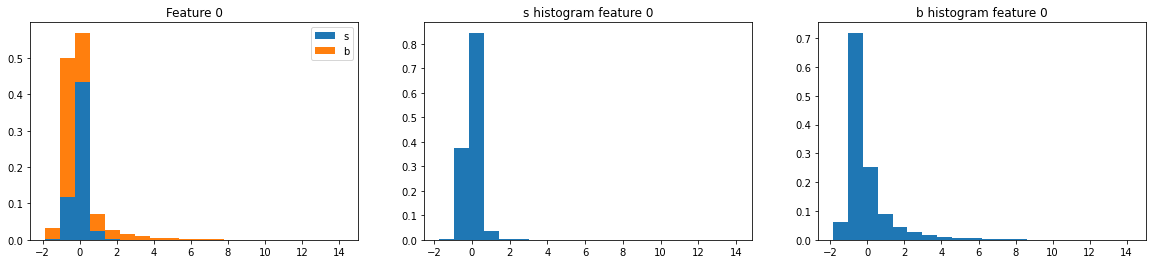

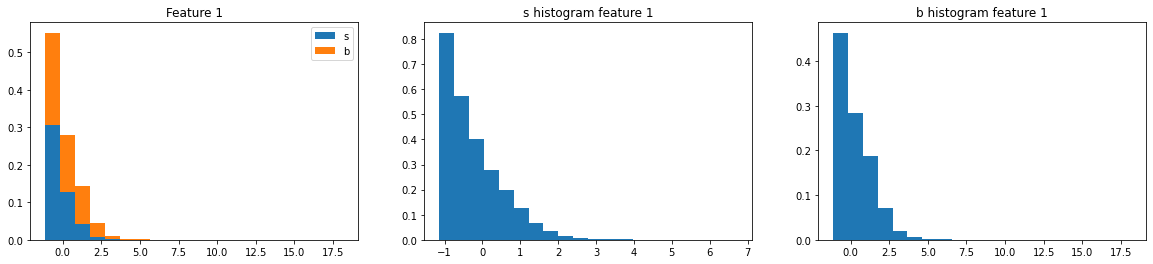

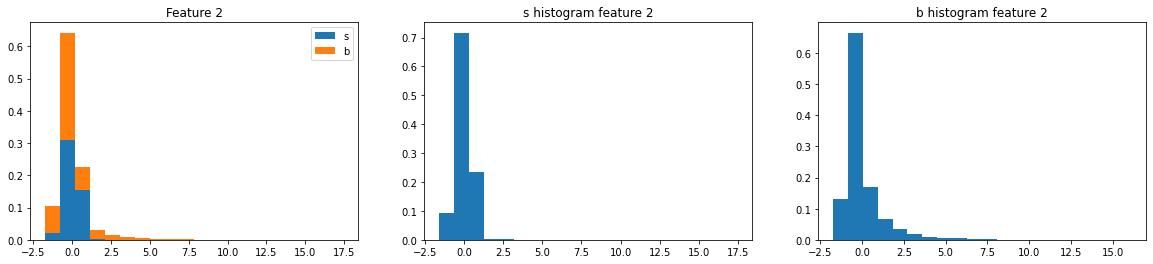

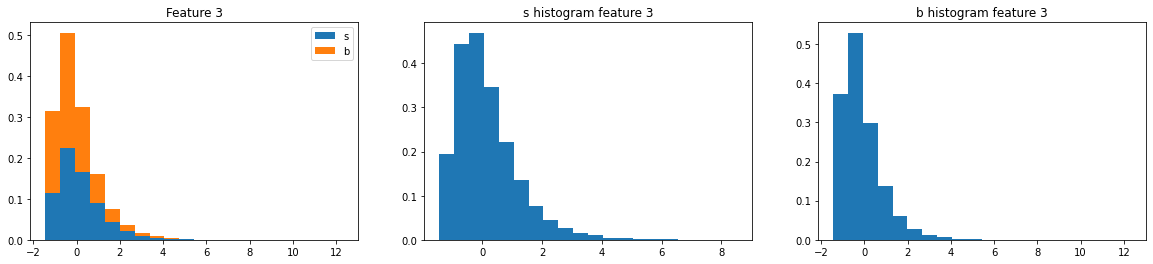

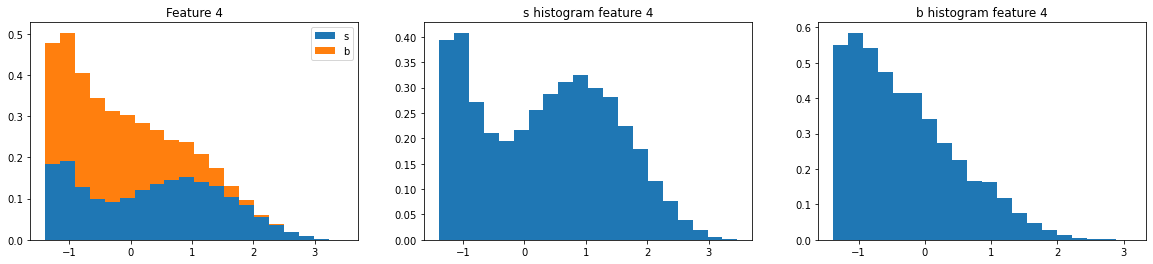

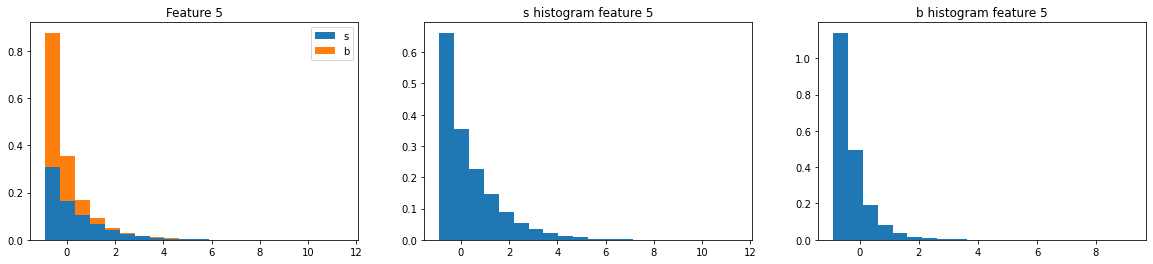

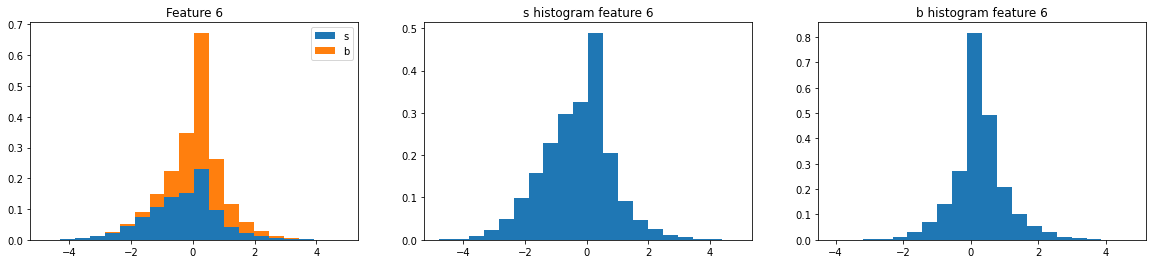

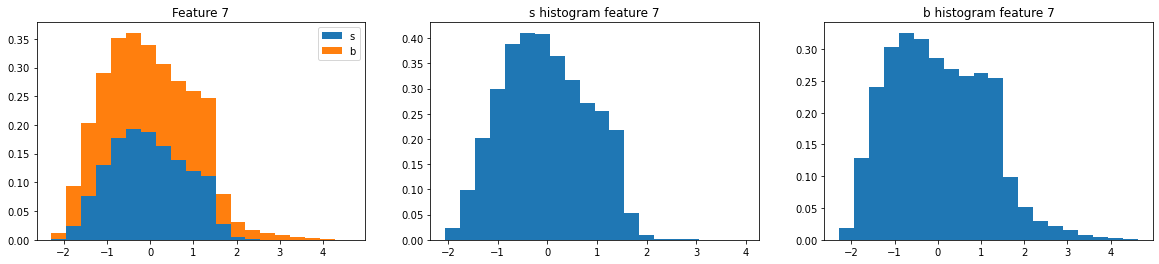

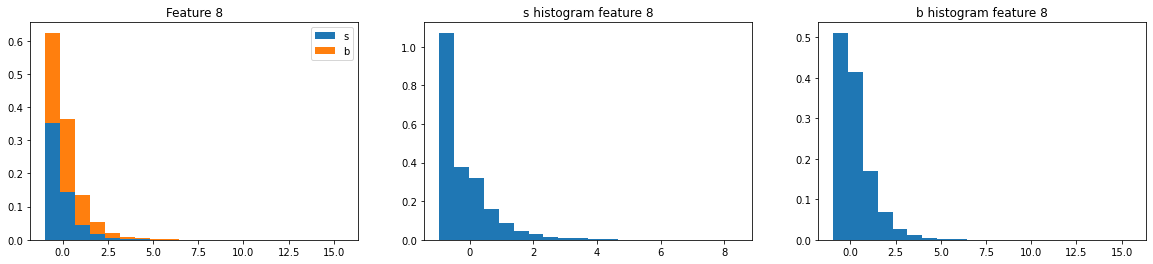

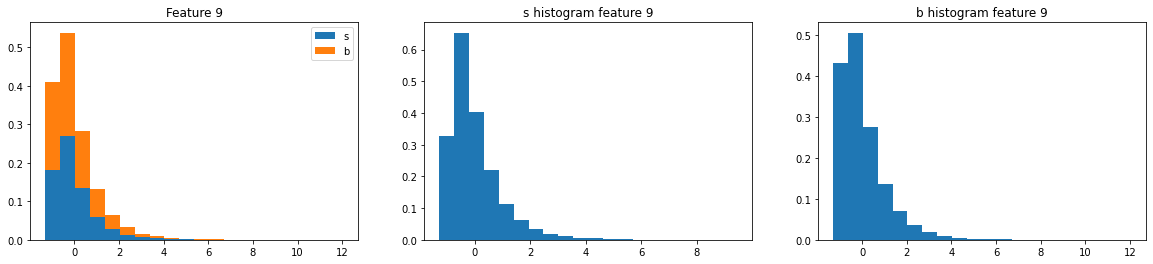

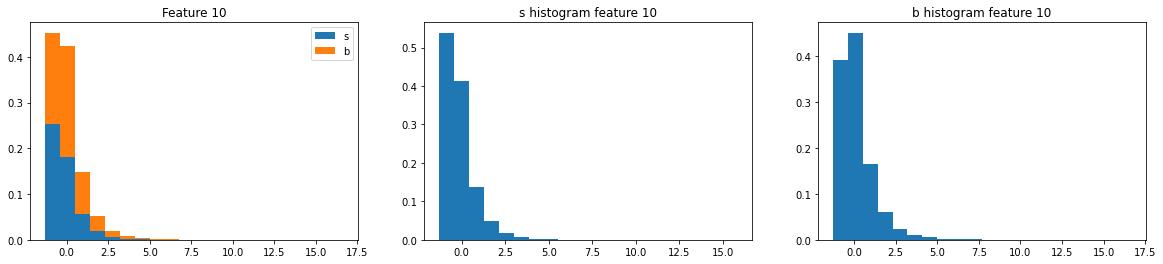

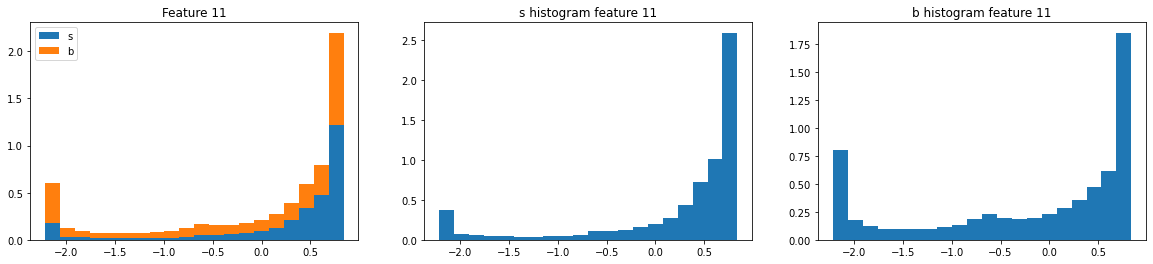

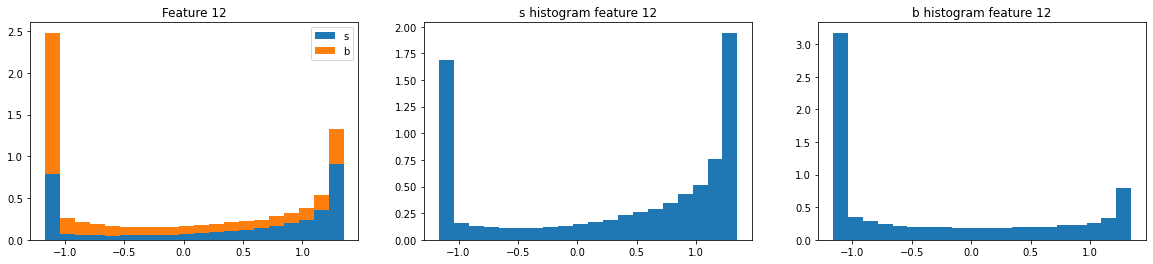

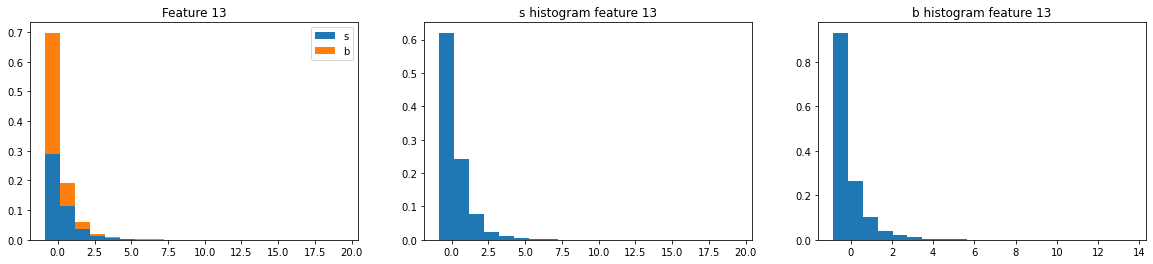

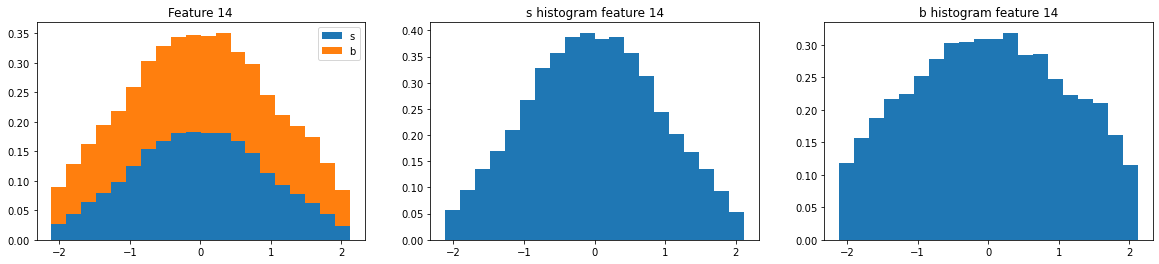

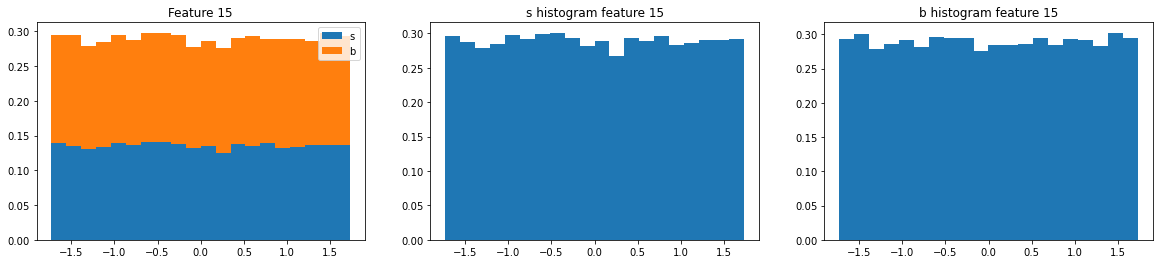

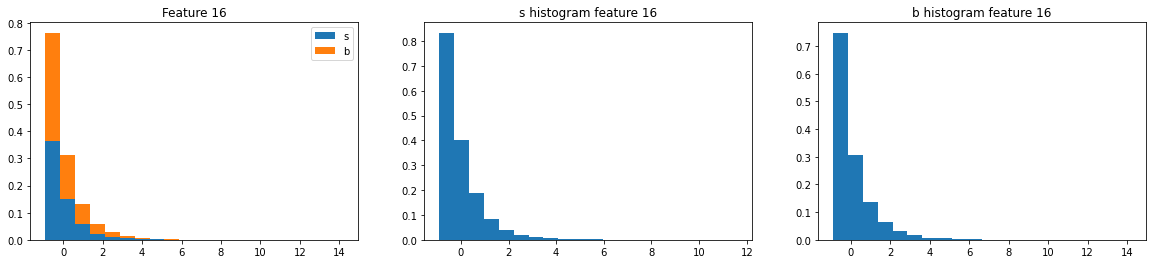

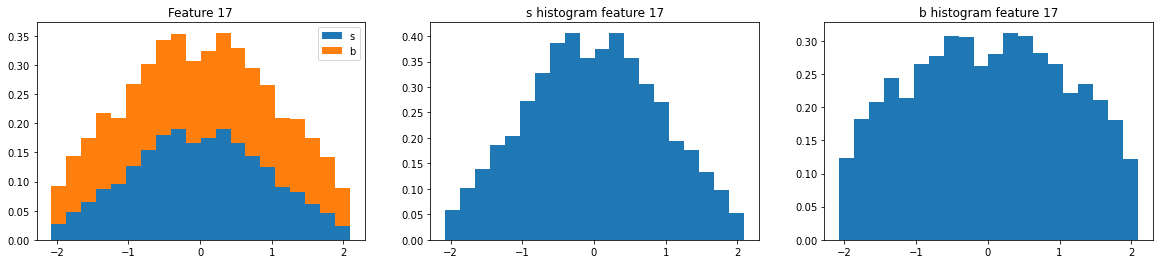

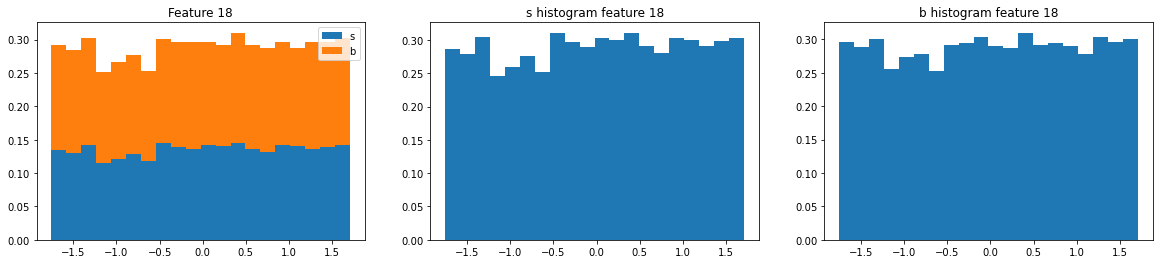

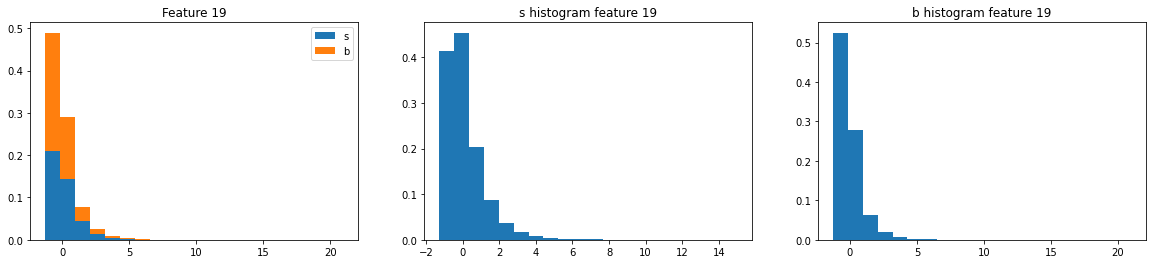

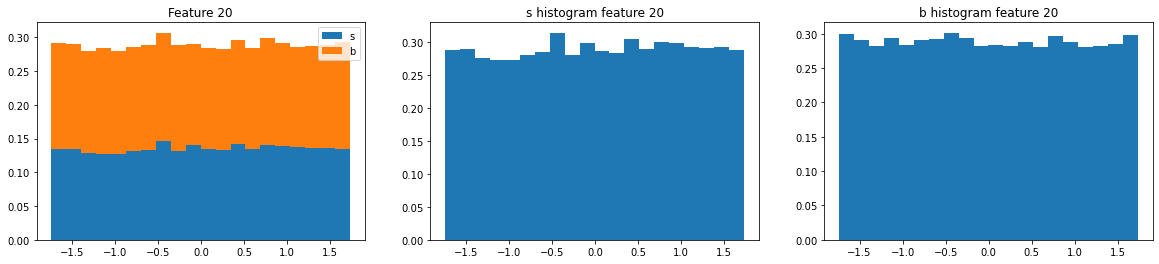

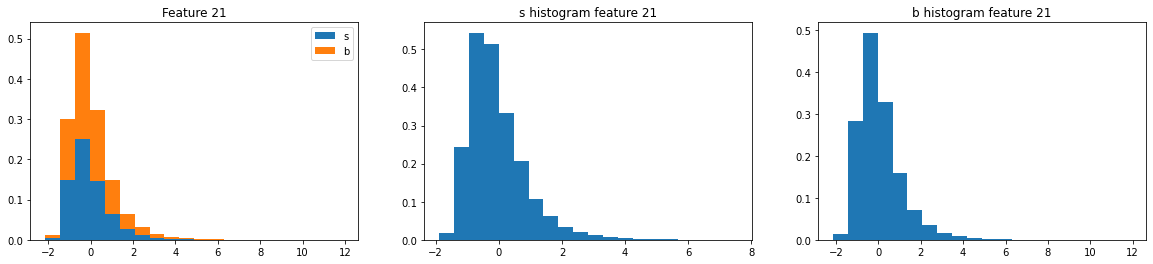

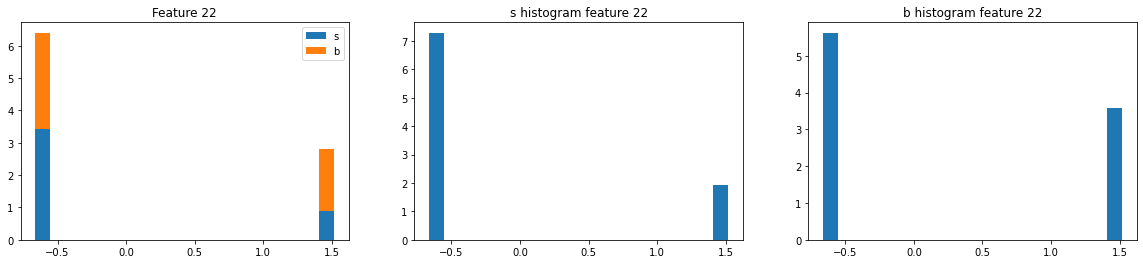

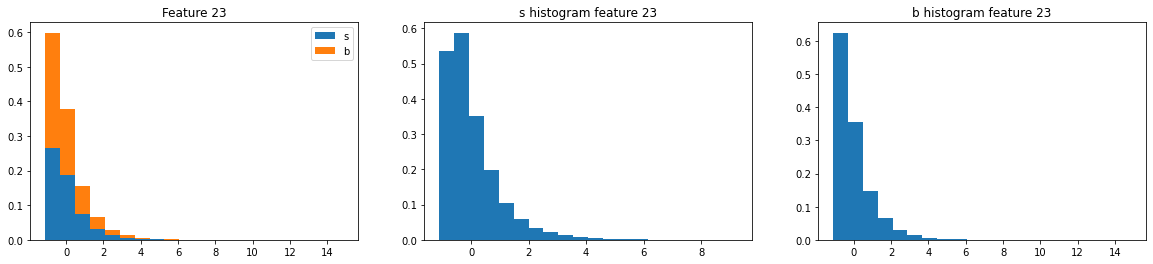

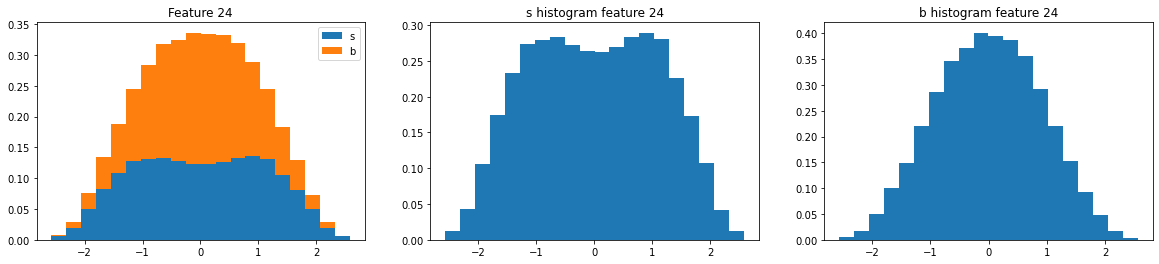

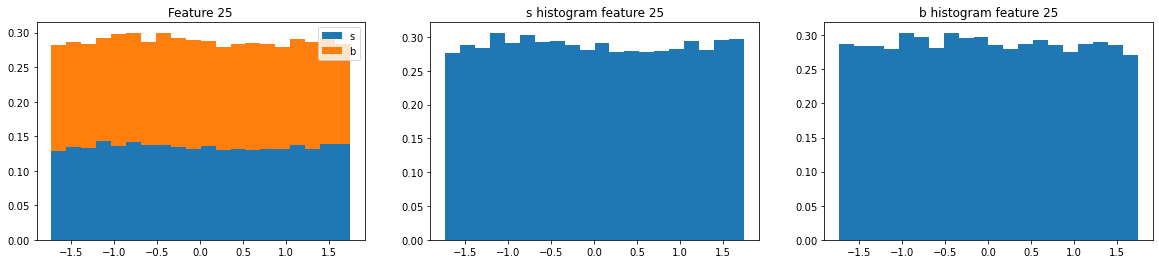

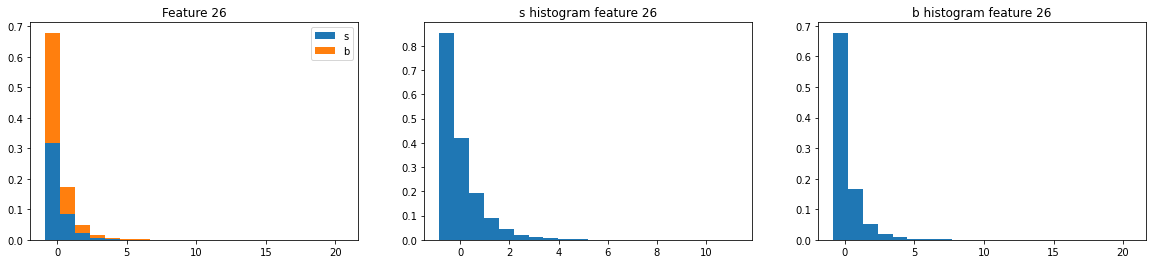

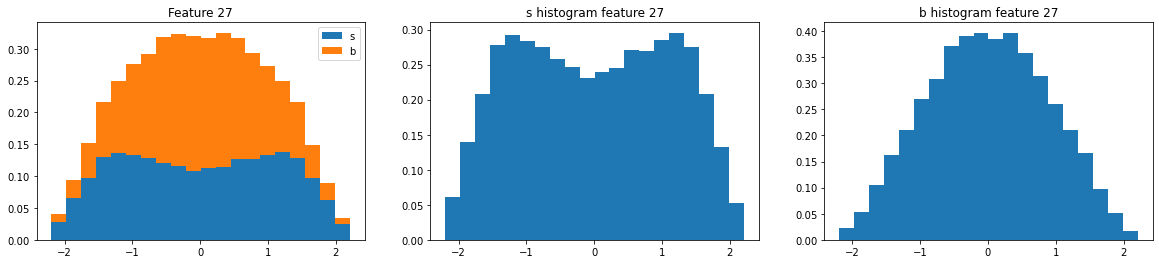

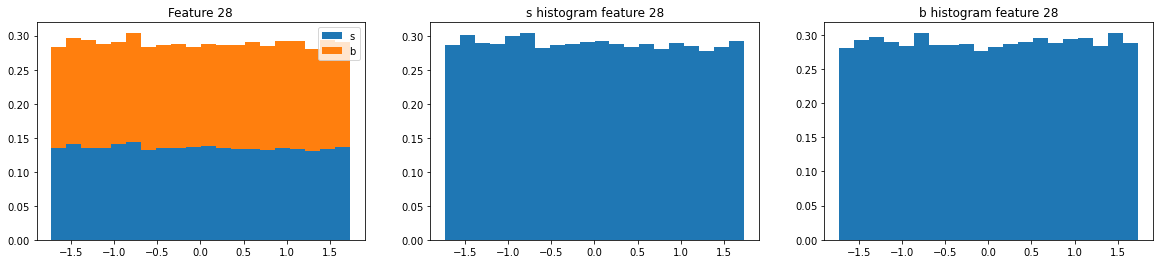

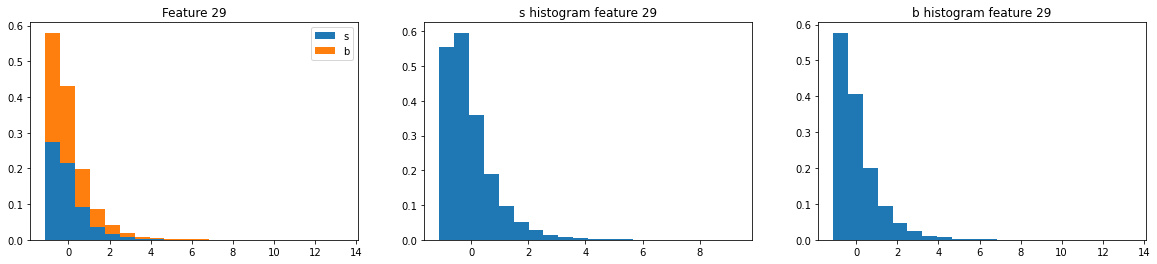

In [6]:
print("Overall: s: ",np.sum(y==1),", b: ",np.sum(y==-1)," ,total:",len(y))
print("NoErrors: s: ",np.sum(y_c==1),", b: ",np.sum(y_c==-1)," ,total:",len(y_c))
for n in range(tX_c.shape[1]):
    plt.figure(figsize=(20,4))
    plt.subplot(131)
    plt.hist([tX_c[y_c==1,n],tX_c[y_c==-1,n]], 20, density=True, histtype='bar', stacked=True)
    plt.legend(['s','b'])
    plt.title('Feature '+str(n))
    plt.subplot(132)
    plt.title('s histogram feature '+str(n))
    plt.hist(tX_c[y_c==1,n], 20, density=True, histtype='bar', stacked=True)
    plt.subplot(133)
    plt.title('b histogram feature '+str(n))
    plt.hist(tX_c[y_c==-1,n], 20, density=True, histtype='bar', stacked=True)    
    plt.show()

In [7]:
# remove features with error values
idx_gf = np.arange(tX.shape[1])[np.all(tX!=-999, axis=0)]
y_gf = y
tX_gf = tX[:,idx_gf]
# regularize
mean = np.mean(tX_gf, axis=0)
std = np.std(tX_gf, axis=0)
tX_gf = (tX_gf-mean)/std

Overall: s:  85667 , b:  164333  ,total: 250000


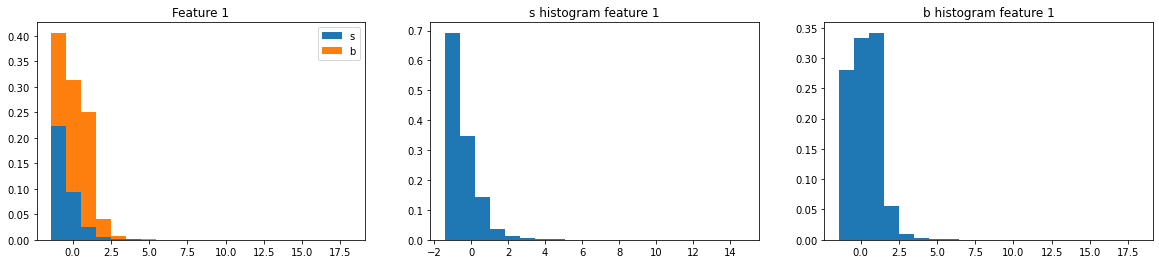

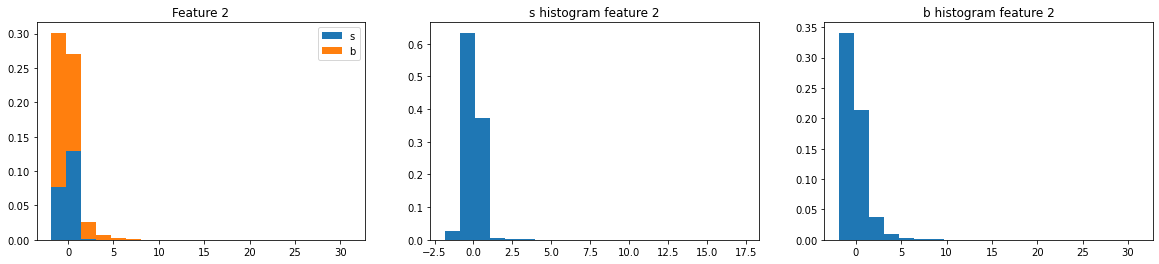

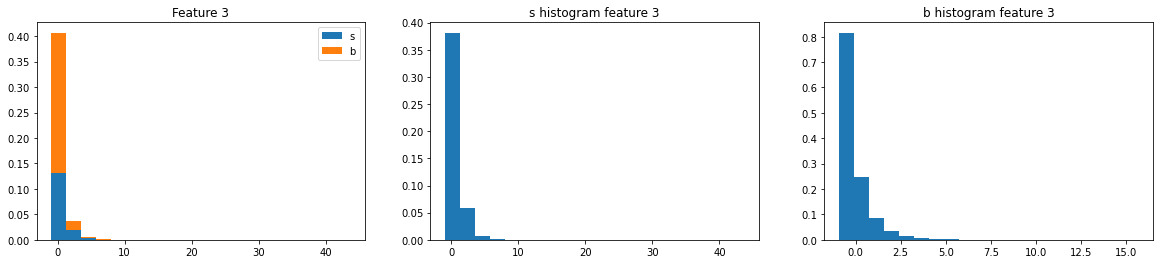

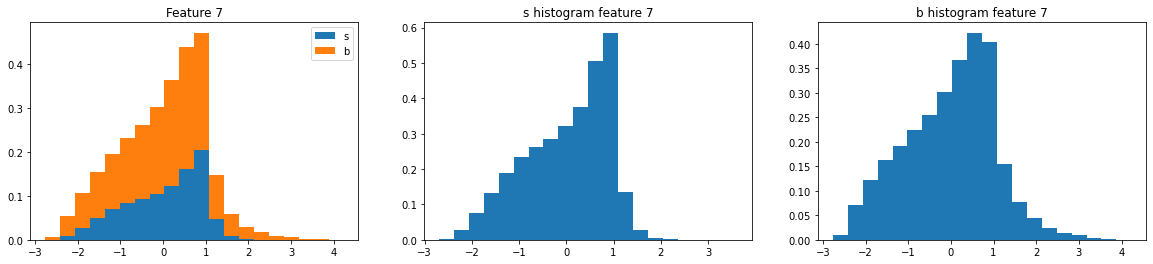

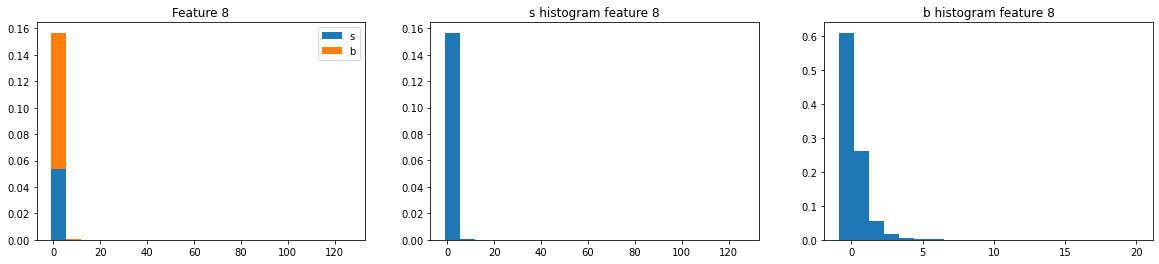

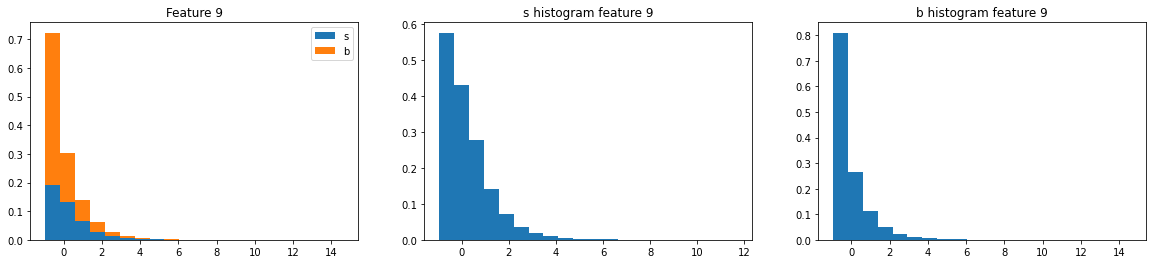

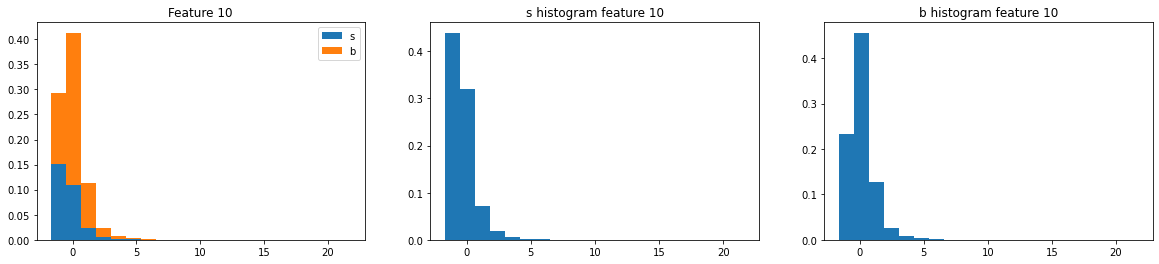

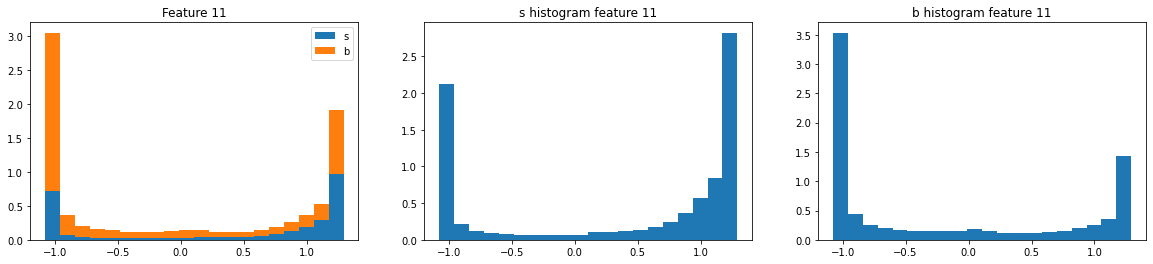

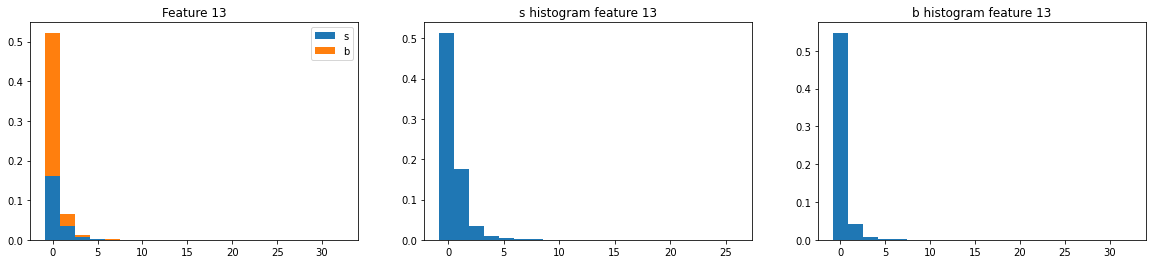

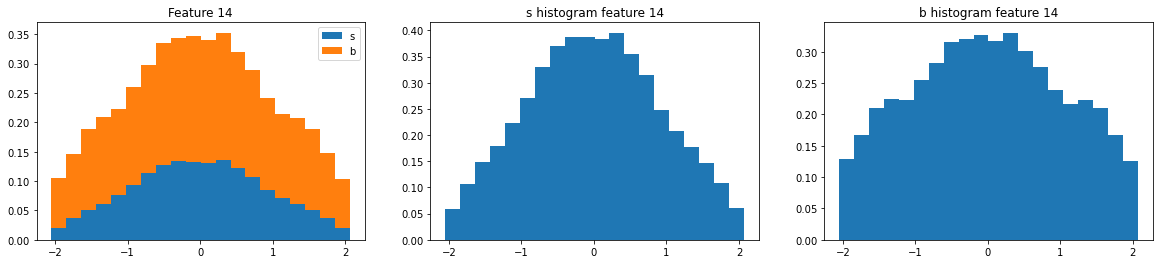

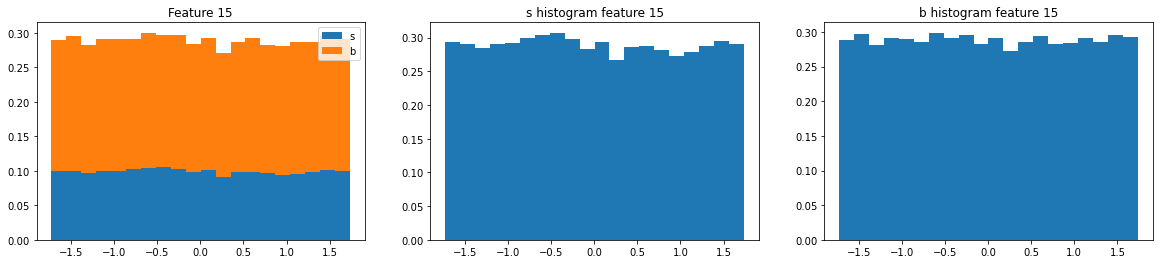

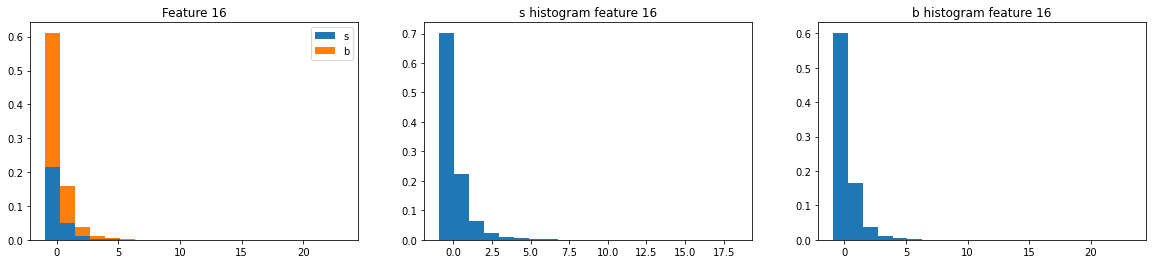

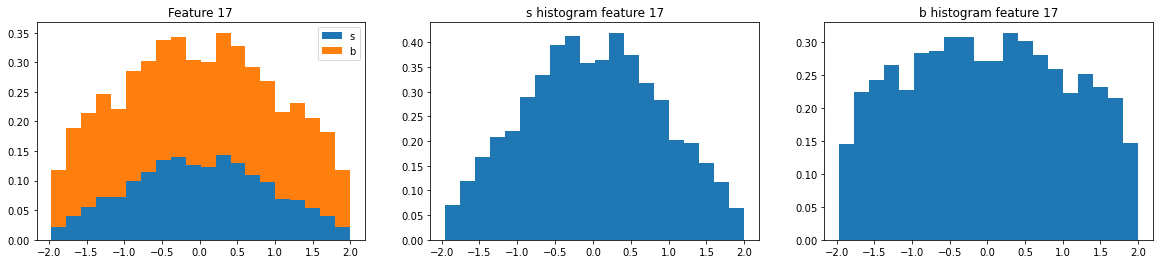

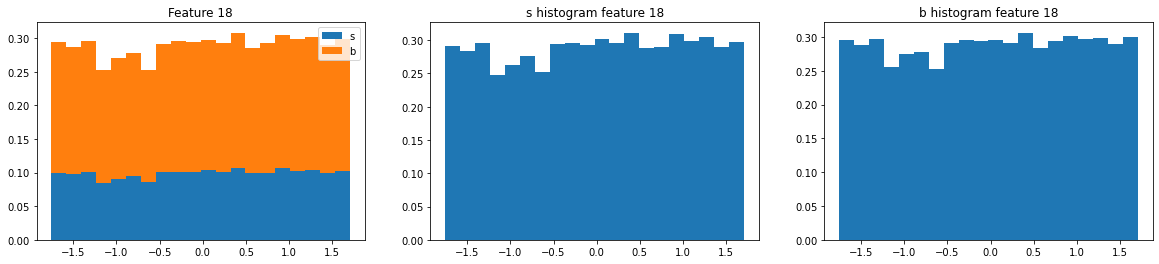

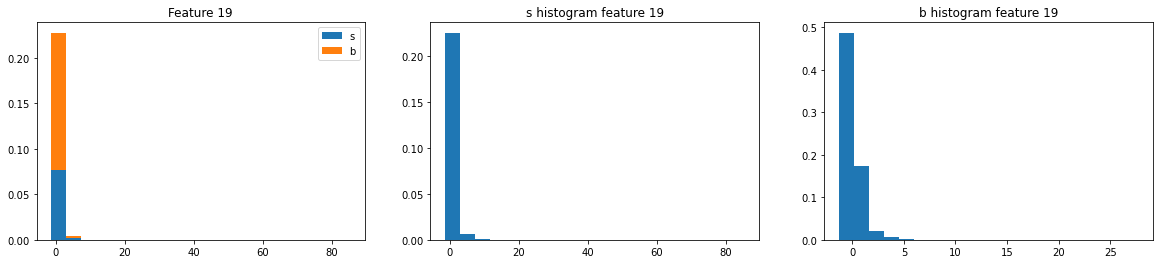

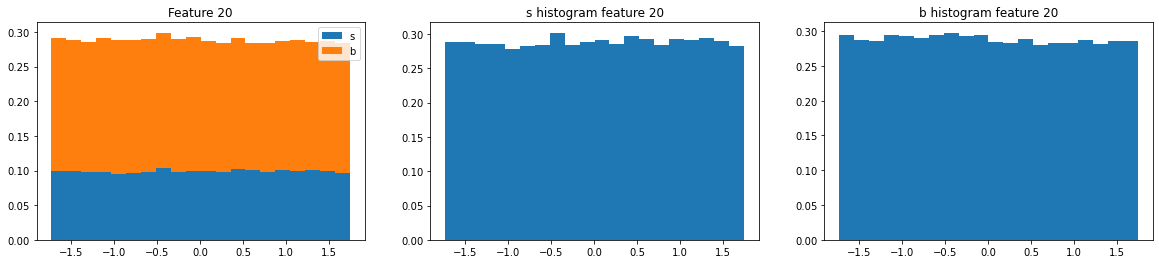

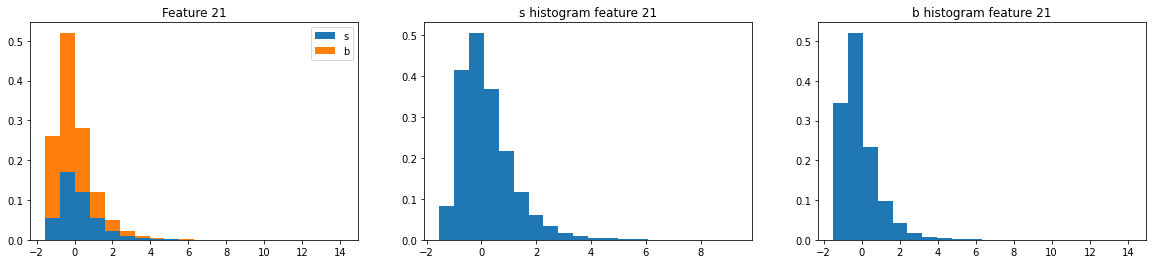

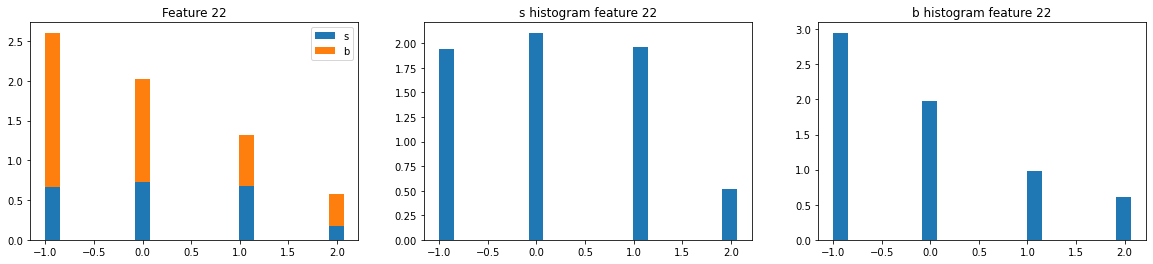

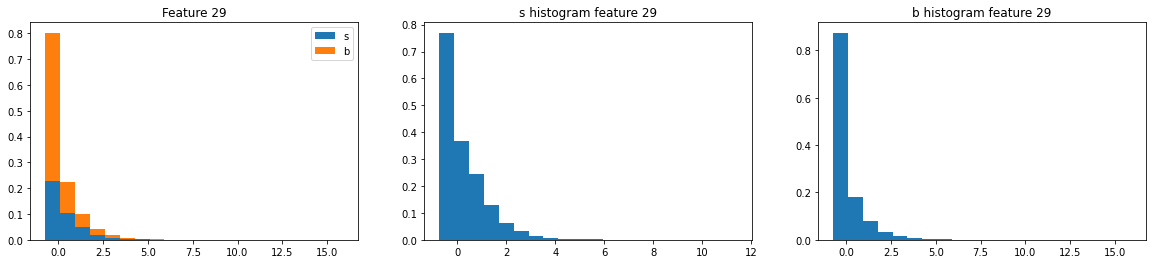

In [8]:
print("Overall: s: ",np.sum(y==1),", b: ",np.sum(y==-1)," ,total:",len(y))
for n in range(tX_gf.shape[1]):
    plt.figure(figsize=(20,4))
    plt.subplot(131)
    plt.hist([tX_gf[y_gf==1,n],tX_gf[y_gf==-1,n]], 20, density=True, histtype='bar', stacked=True)
    plt.legend(['s','b'])
    plt.title('Feature '+str(idx_gf[n]))
    plt.subplot(132)
    plt.title('s histogram feature '+str(idx_gf[n]))
    plt.hist(tX_gf[y_gf==1,n], 20, density=True, histtype='bar', stacked=True)
    plt.subplot(133)
    plt.title('b histogram feature '+str(idx_gf[n]))
    plt.hist(tX_gf[y_gf==-1,n], 20, density=True, histtype='bar', stacked=True)    
    plt.show()

In [9]:
# remove features with error values
y_jet = []
tx_jet = []
y_jet_nm = []
tx_jet_nm = []
# filtering according to undefinition due to jet number
idx_jet_undef = [np.array([0,1,2,3,7,10,11,13,14,15,16,17,18,19,20,21,29]),
                np.array([0,1,2,3,7,8,9,10,11,13,14,15,16,17,18,19,20,21,23,24,25,29]),
                np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29]),
                np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29])]
# Extra filtering according to definition of mass
idx_jet_undef_nm = [np.array([1,2,3,7,10,11,13,14,15,16,17,18,19,20,21,29]),
                    np.array([1,2,3,7,8,9,10,11,13,14,15,16,17,18,19,20,21,23,24,25,29]),
                    np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29]),
                    np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29])]
for jet in range(4):
    idx_jet = tX[:,22]==jet
    y_jet.append(y[idx_jet])
    tx_jet.append(tX[idx_jet][:,idx_jet_undef[jet]])
    # tx_jet.append(standardize(tX[idx_jet]))
for jet in range(4):
    idx_jet = tX[:,22]==jet
    y_jet_nm.append(y[idx_jet])
    tx_jet_nm.append(tX[idx_jet][:,idx_jet_undef_nm[jet]])
    # tx_jet.append(standardize(tX[idx_jet]))

for jet in range(4):
    print('Jet {:} shape is {:}'.format(jet,tx_jet[jet].shape))

Jet 0 shape is (99913, 17)
Jet 1 shape is (77544, 22)
Jet 2 shape is (50379, 29)
Jet 3 shape is (22164, 29)


Overall: s:  85667 , b:  164333  ,total: 250000
Jet 0: s: 25492, b: 74421 ,total: 99913


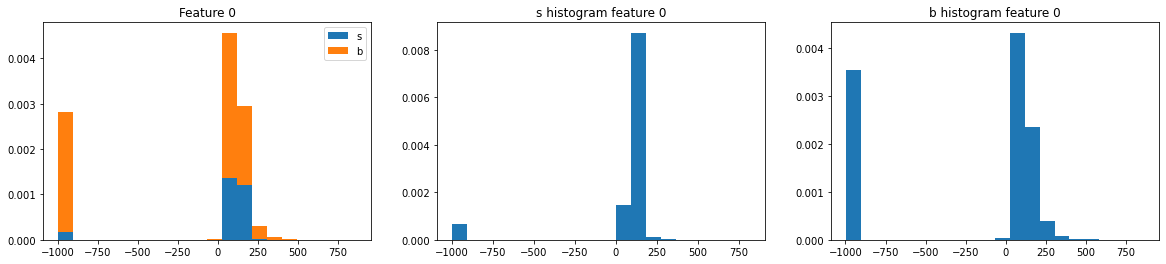

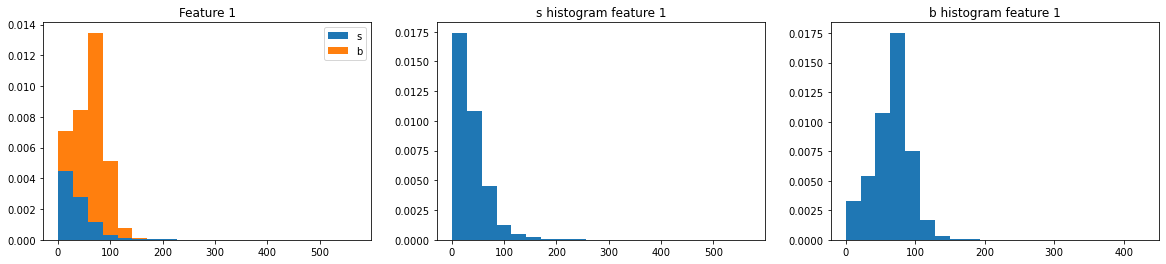

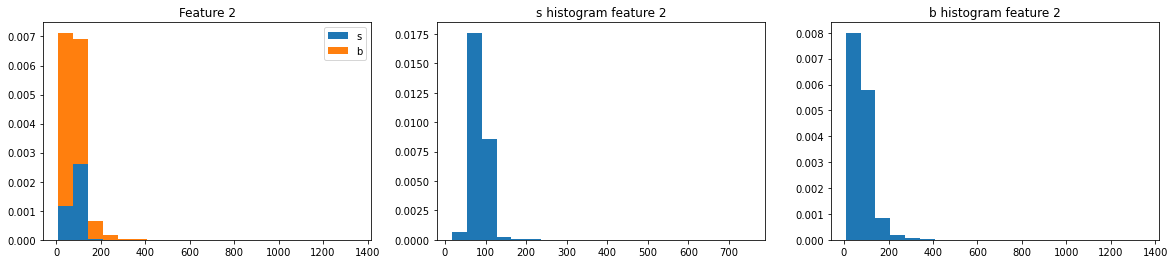

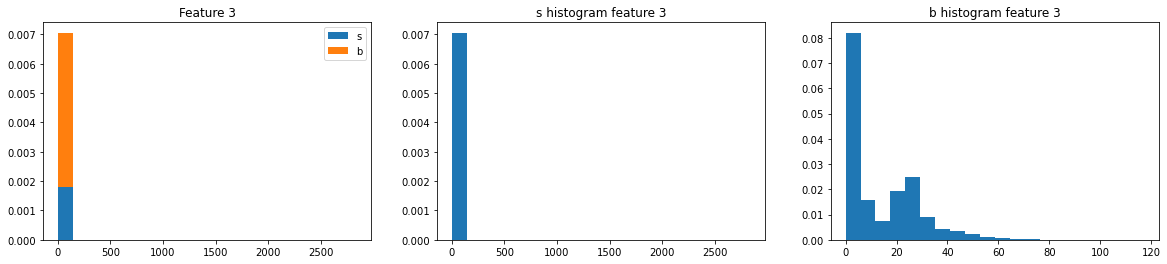

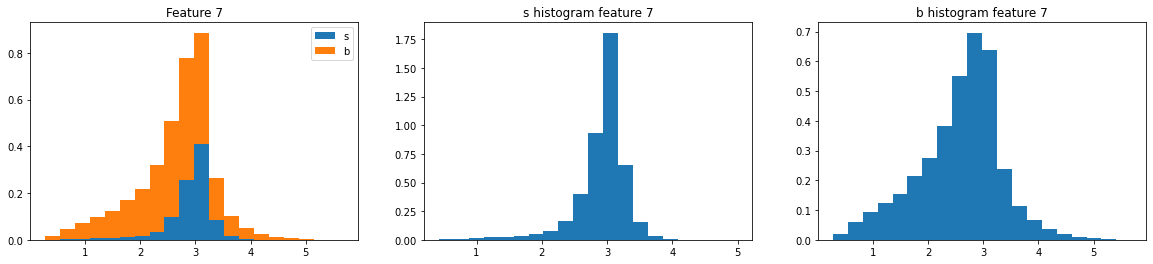

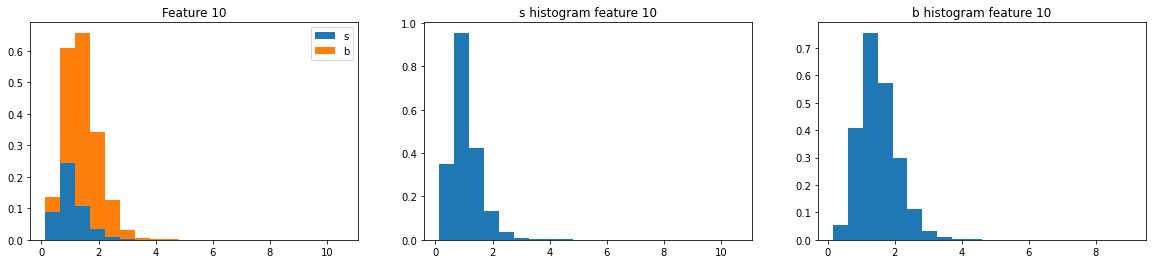

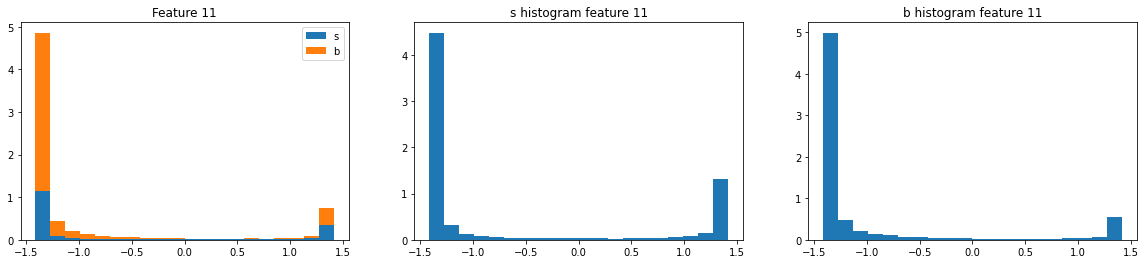

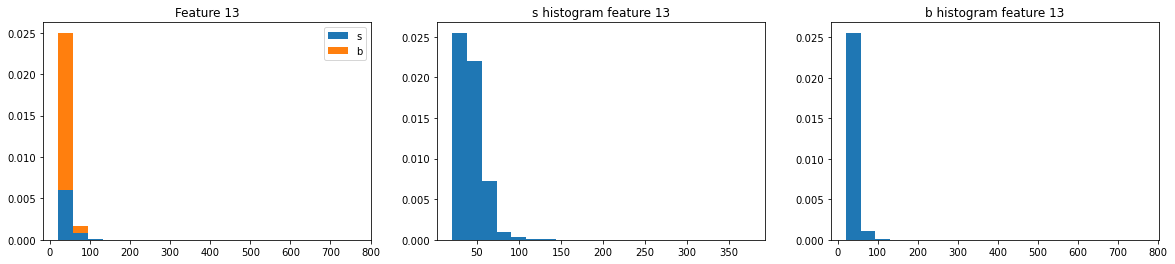

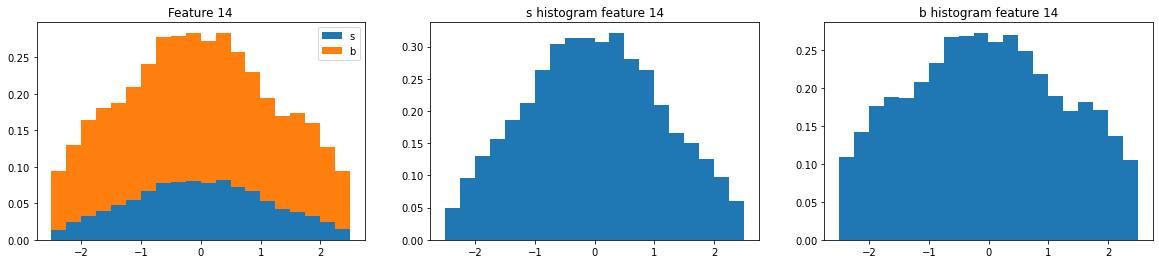

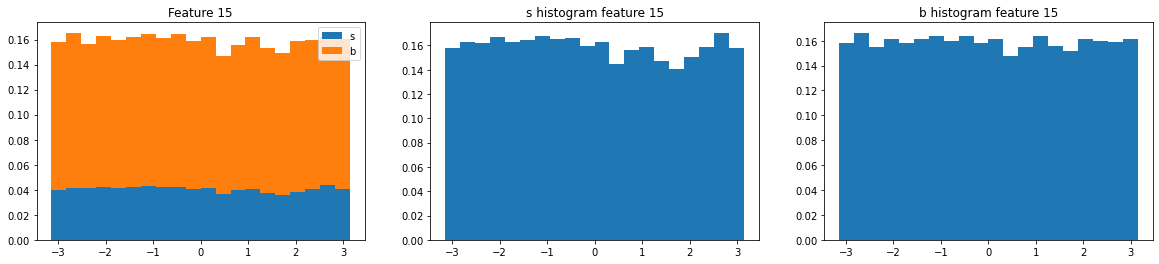

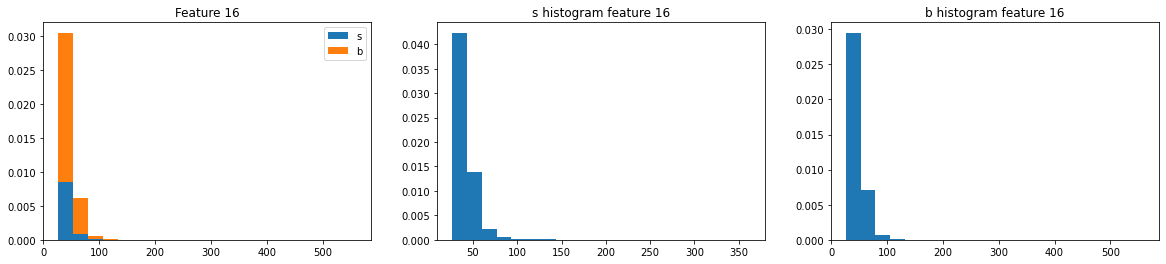

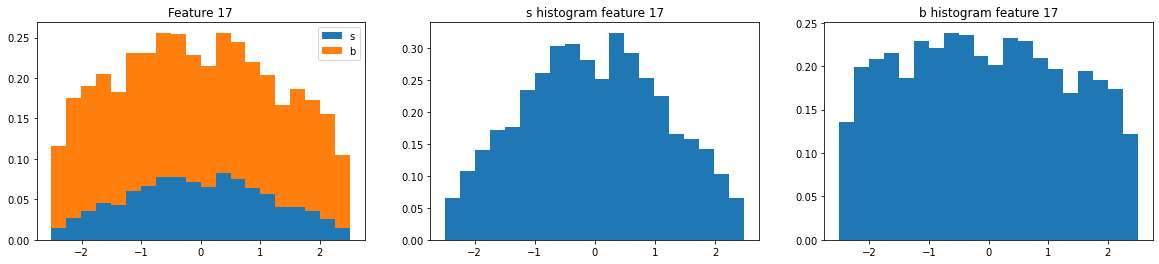

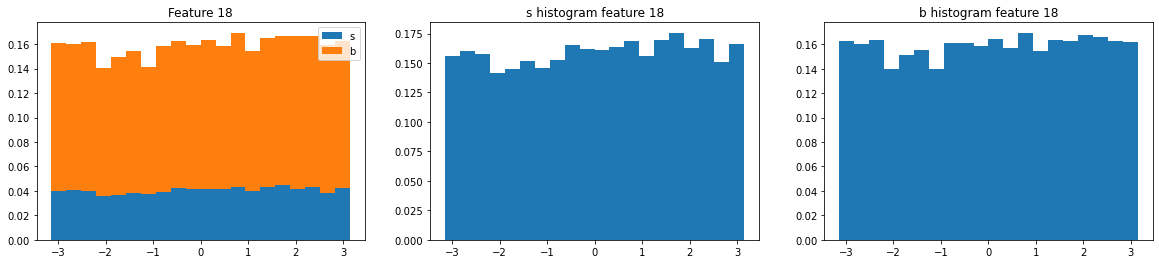

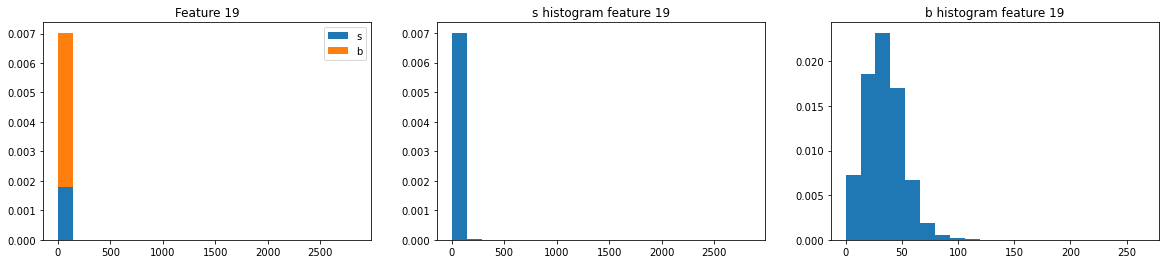

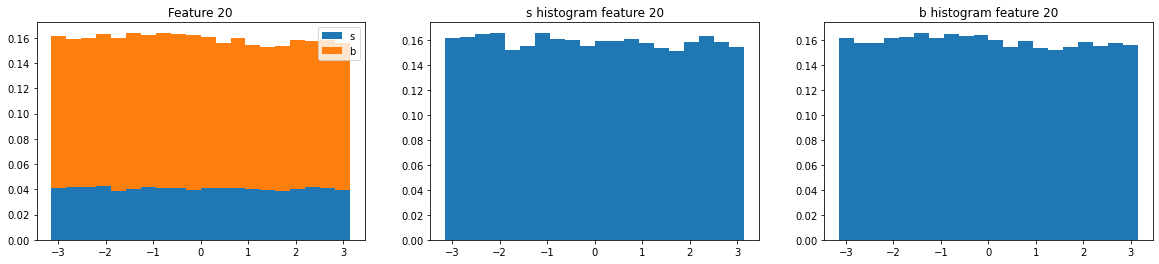

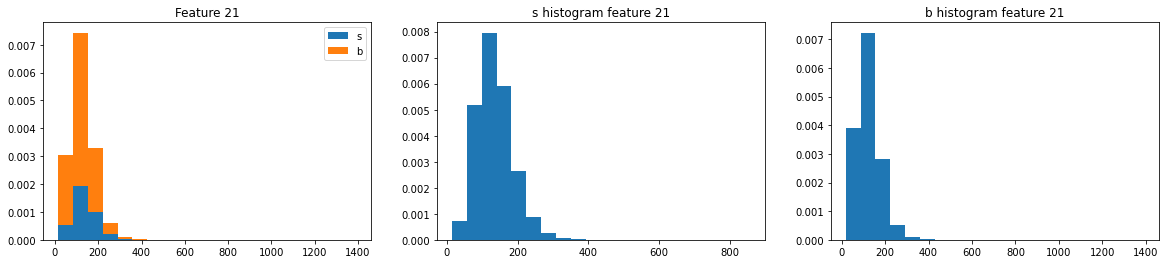

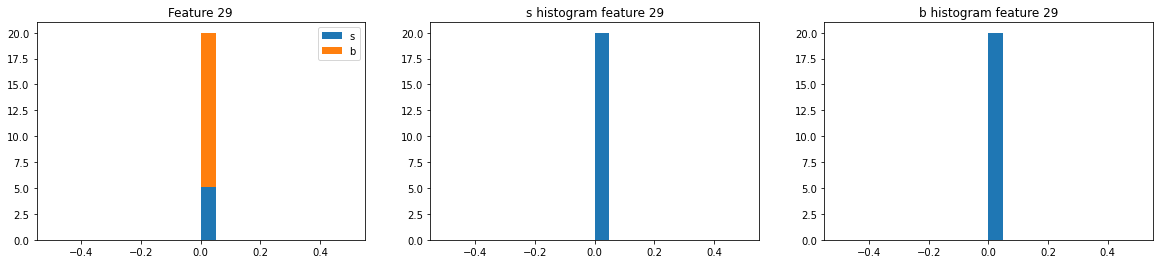

Jet 1: s: 27710, b: 49834 ,total: 77544


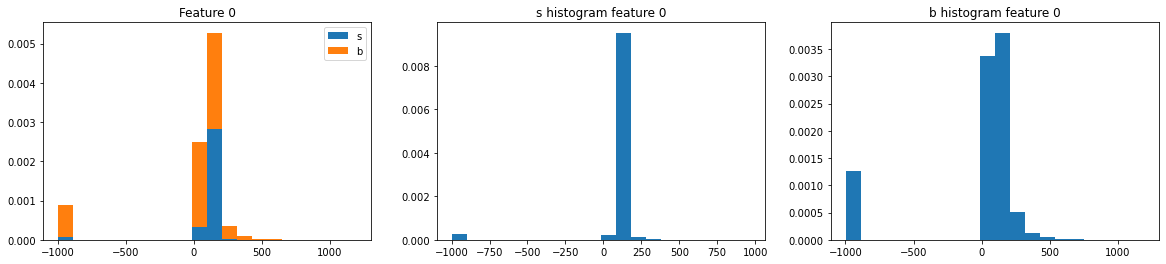

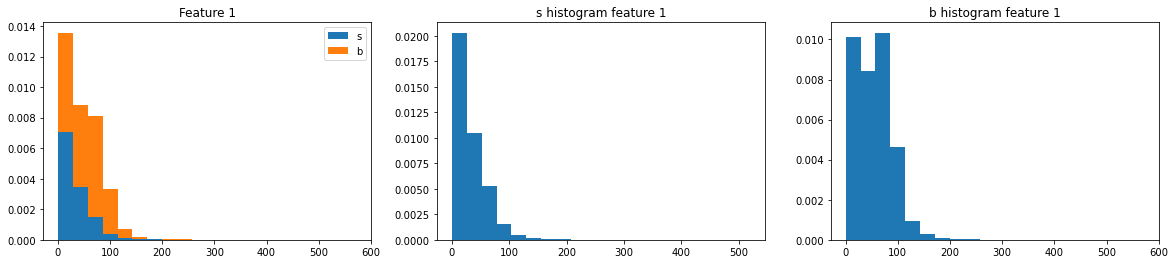

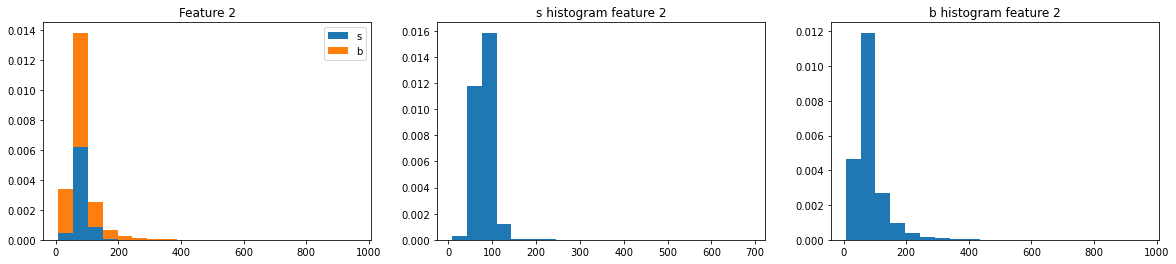

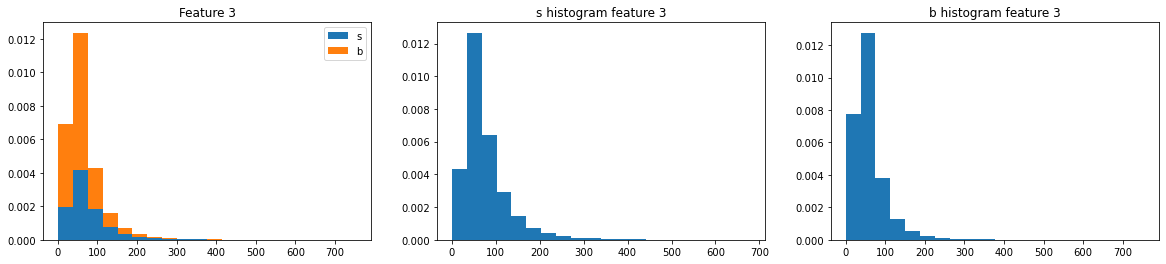

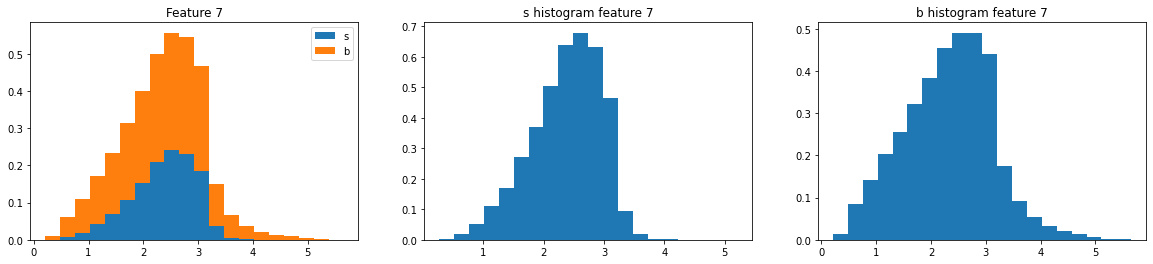

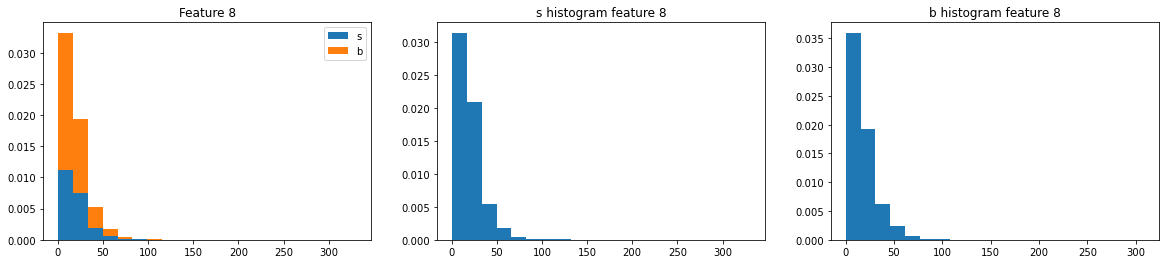

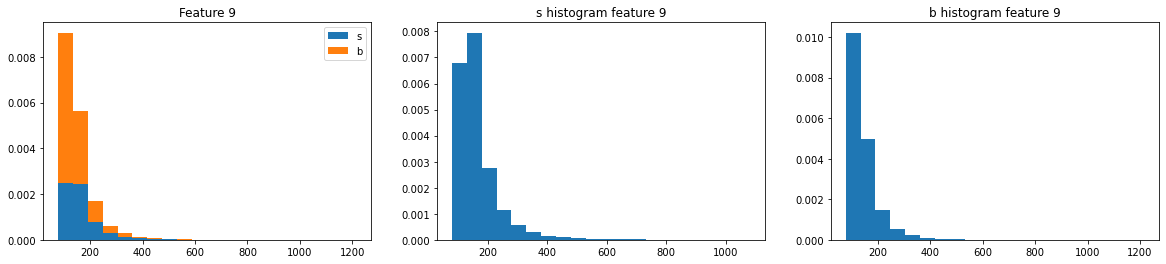

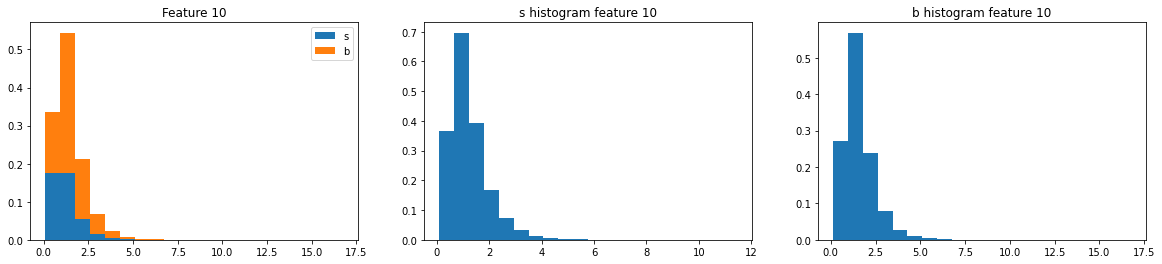

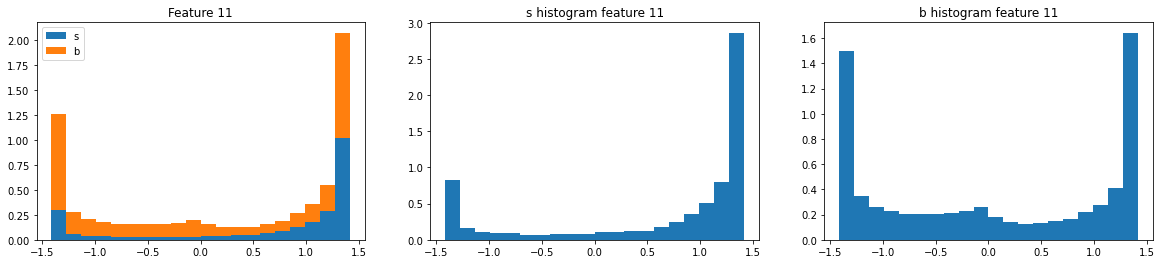

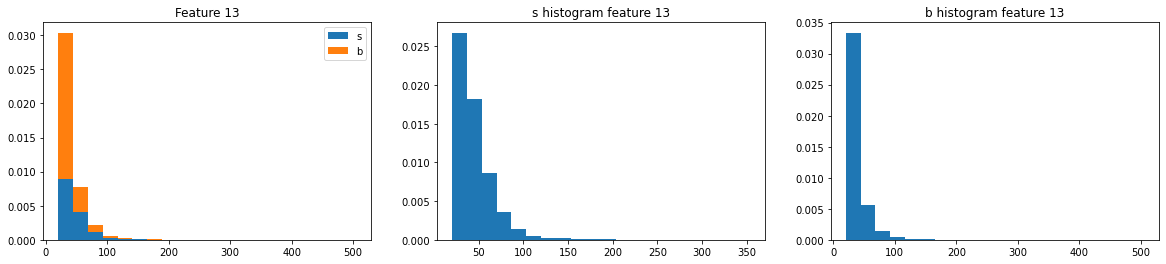

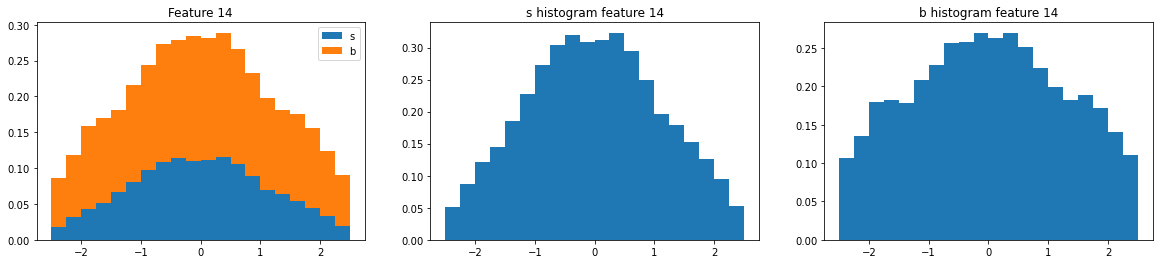

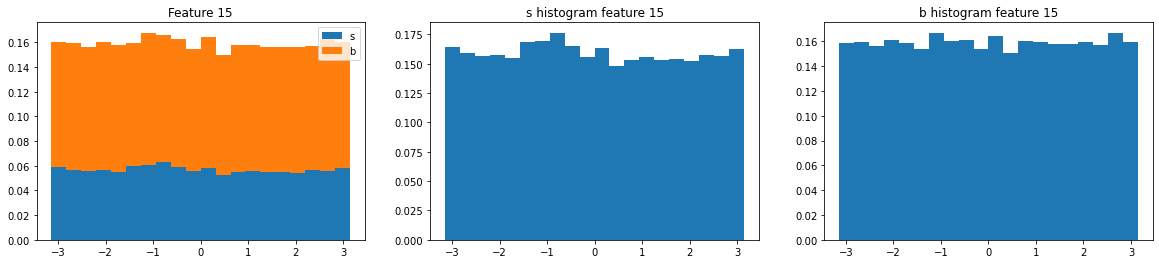

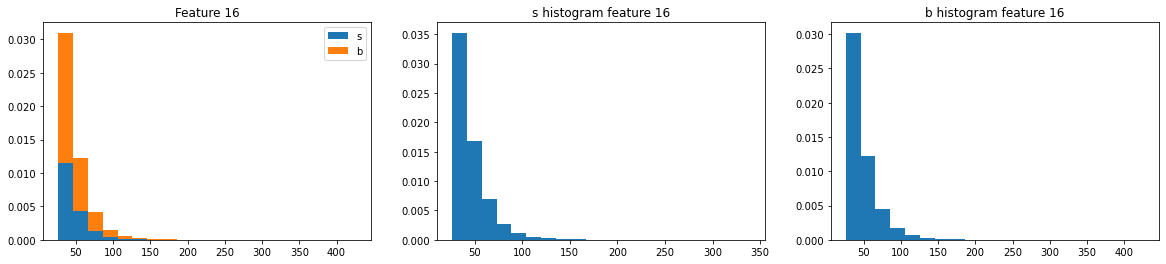

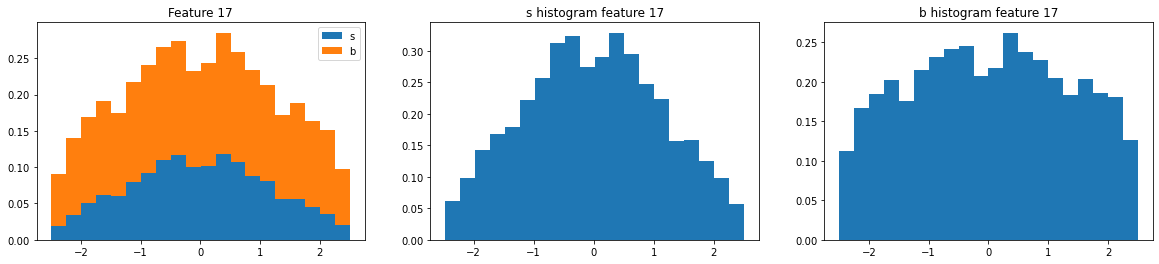

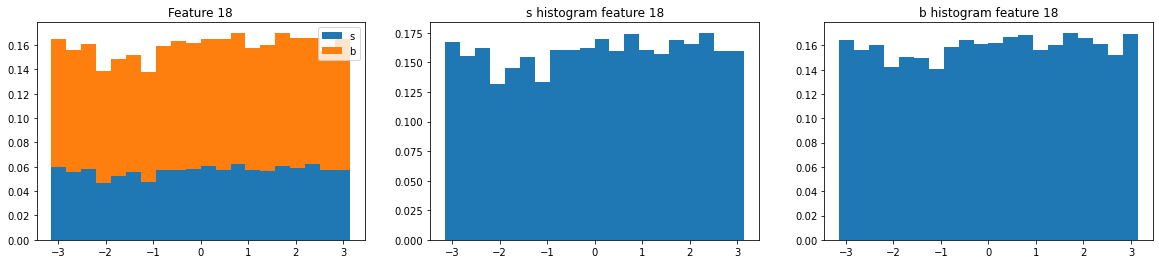

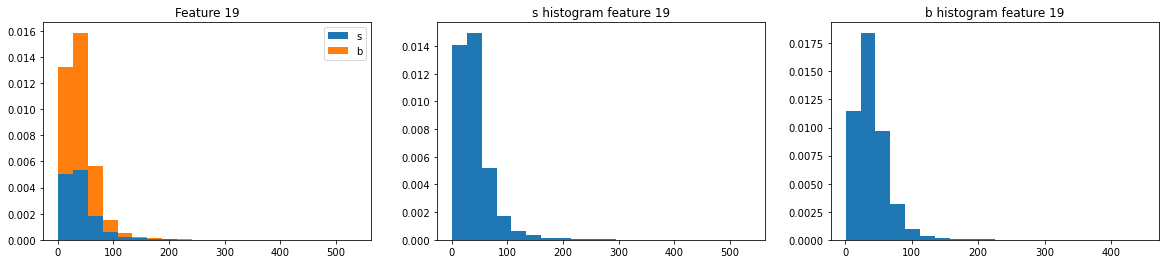

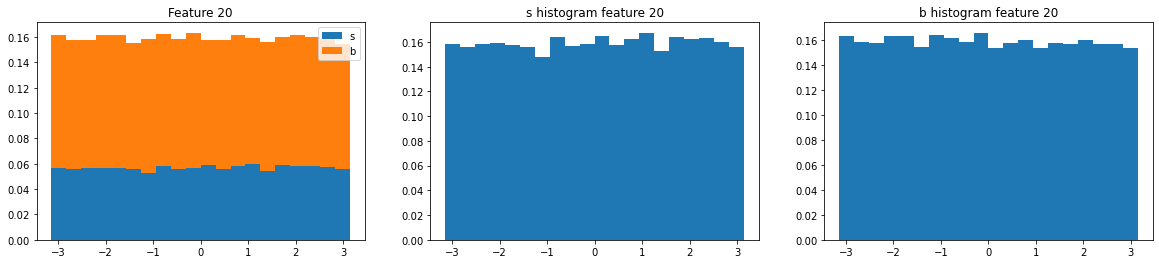

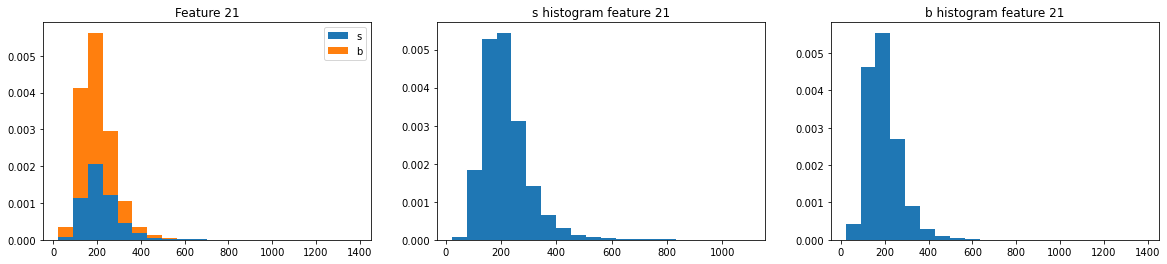

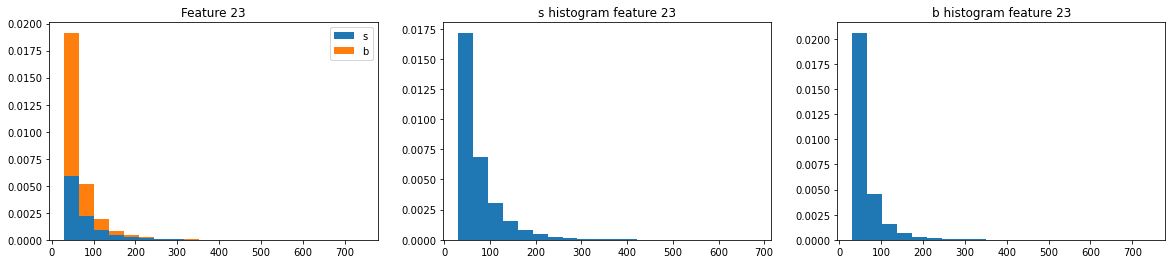

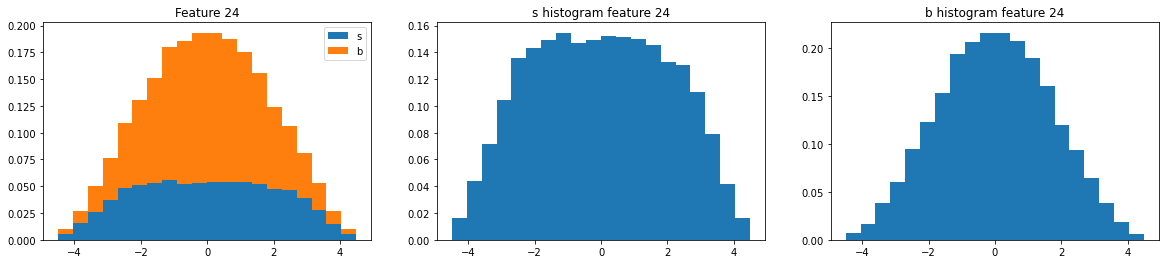

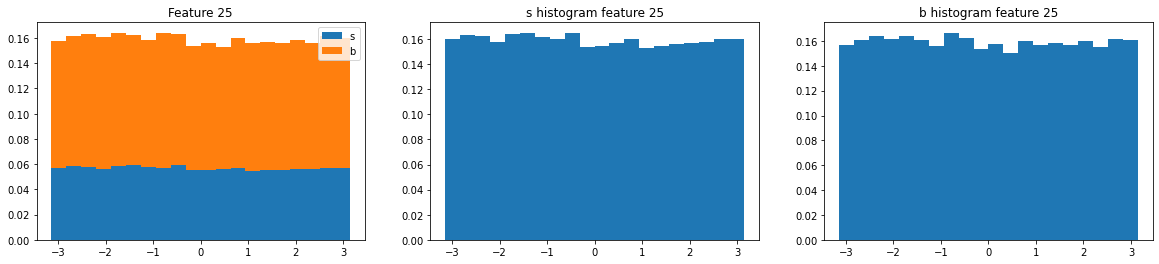

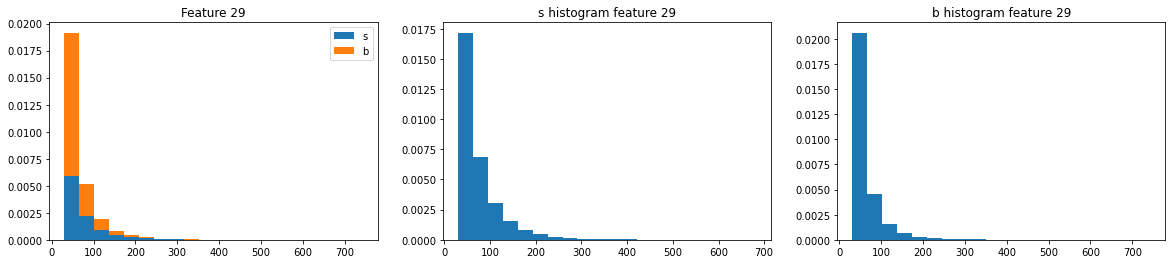

Jet 2: s: 25734, b: 24645 ,total: 50379


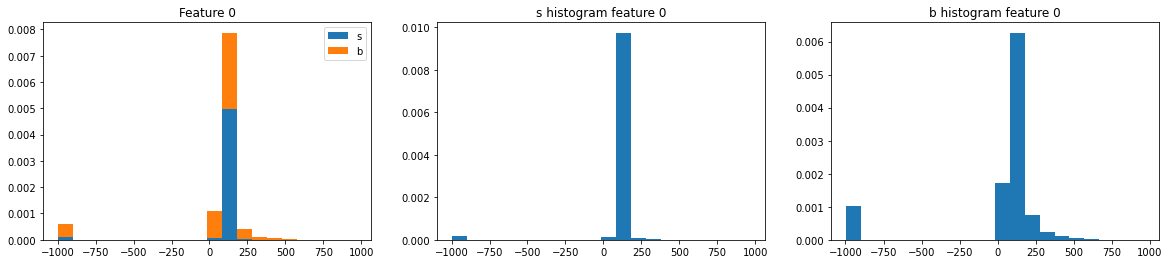

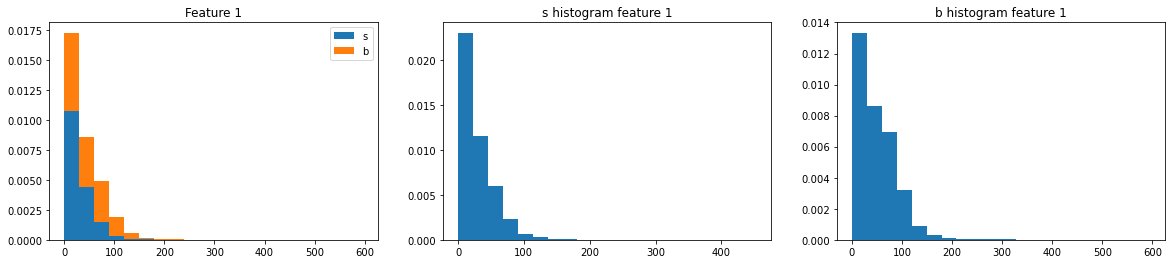

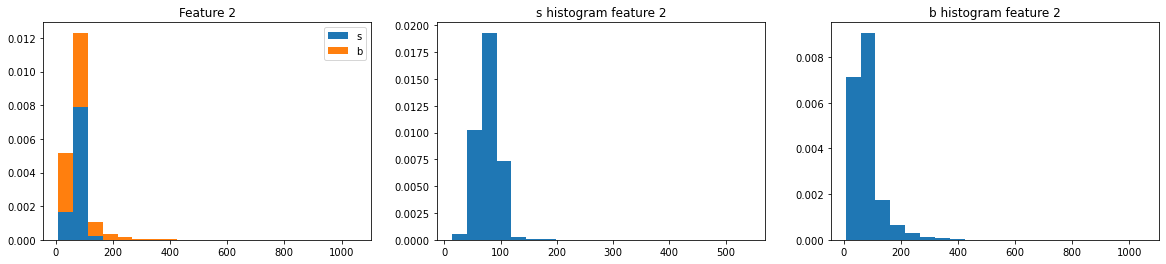

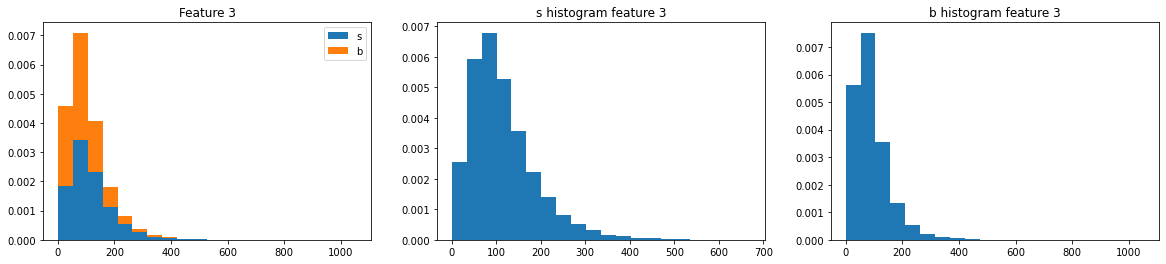

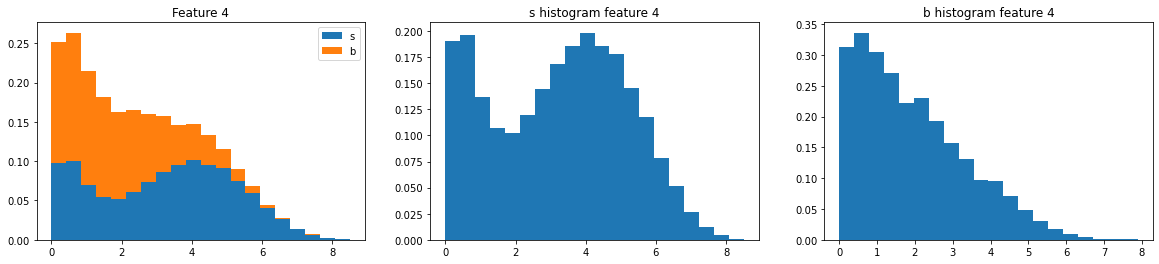

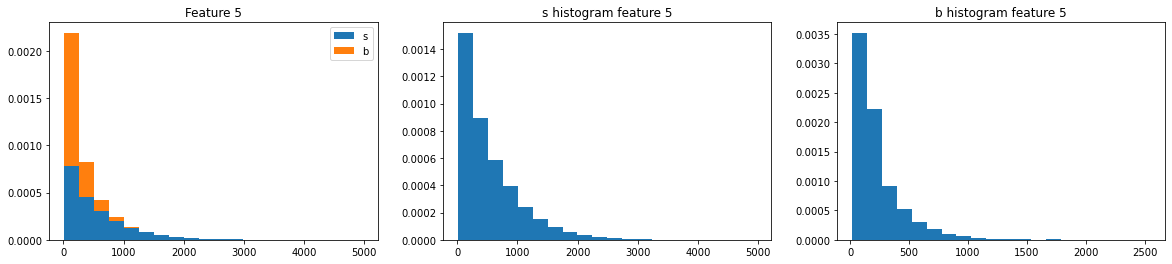

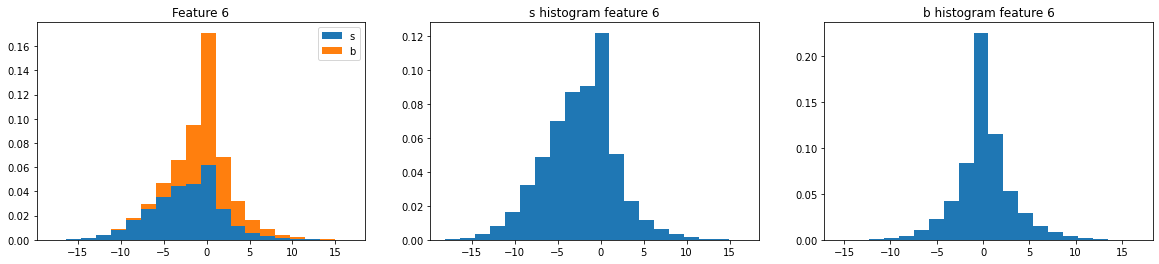

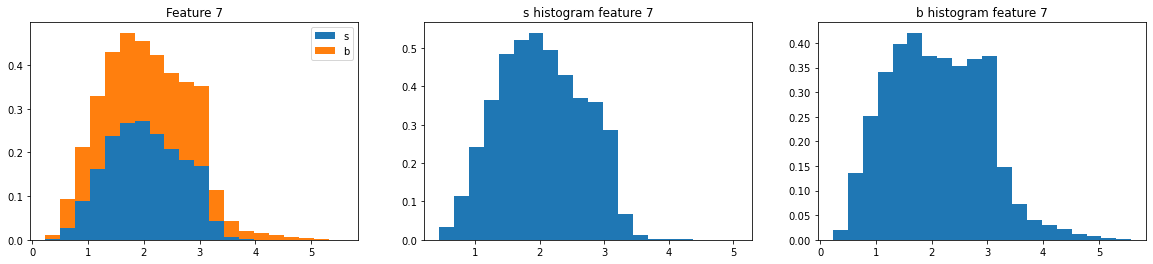

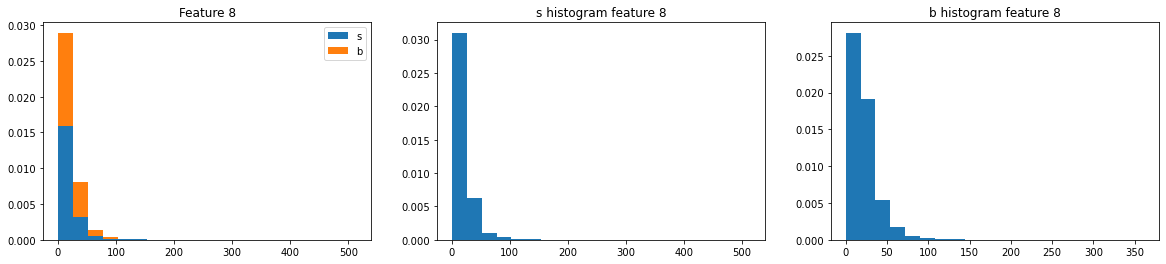

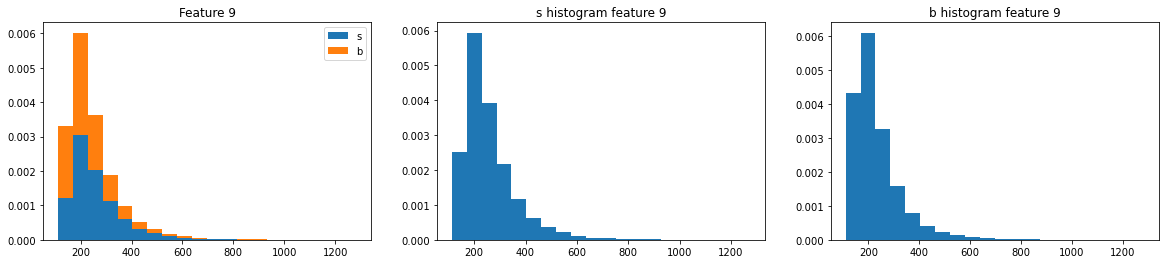

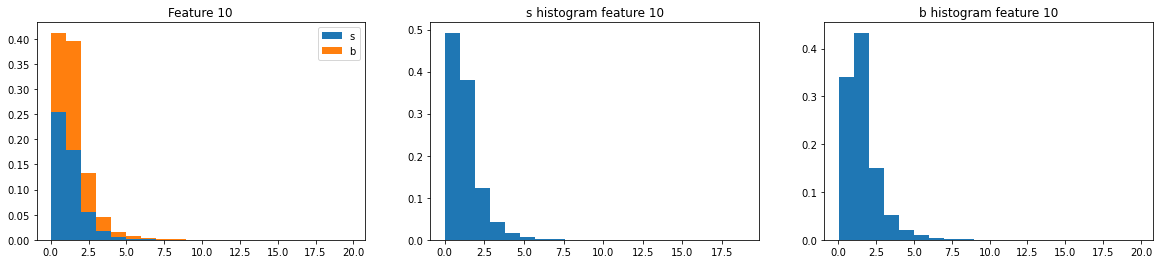

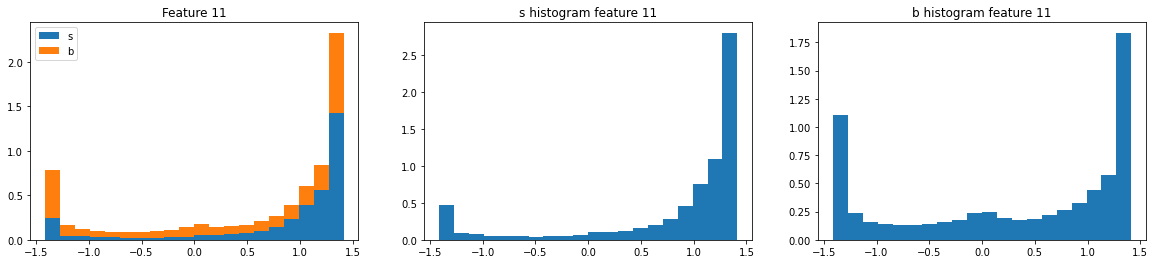

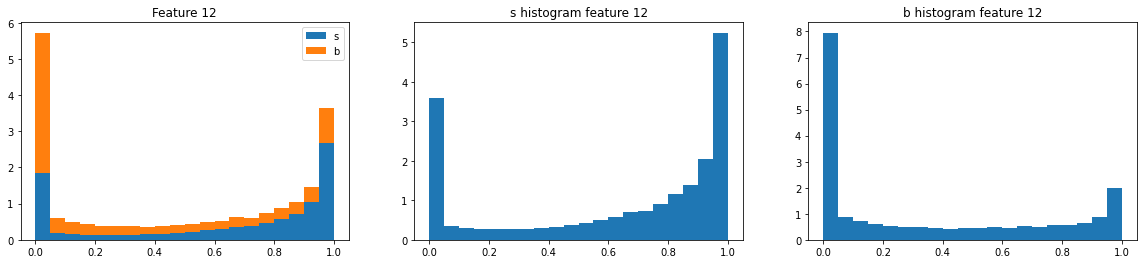

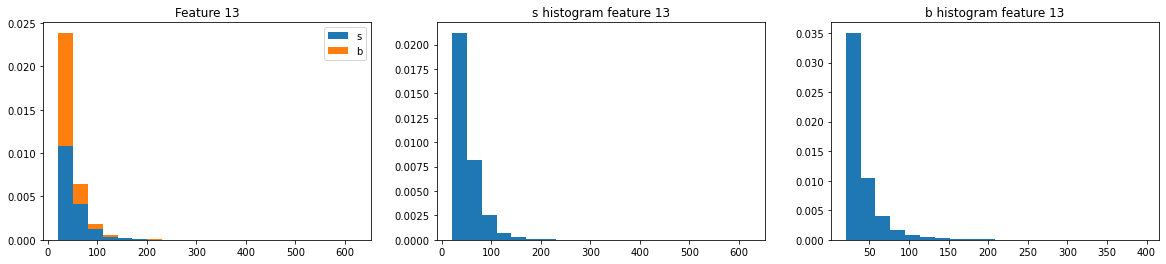

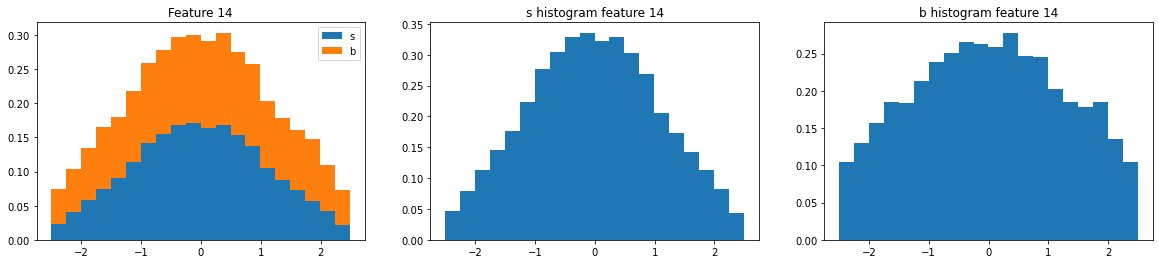

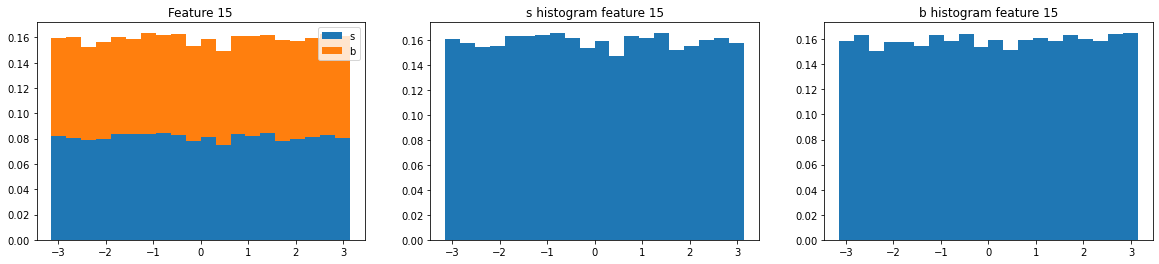

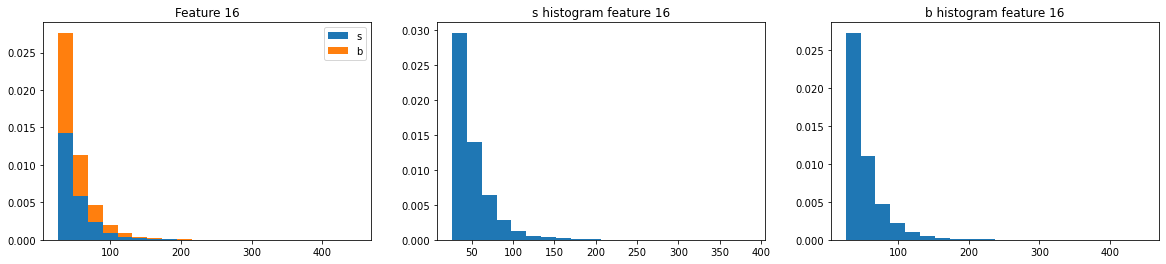

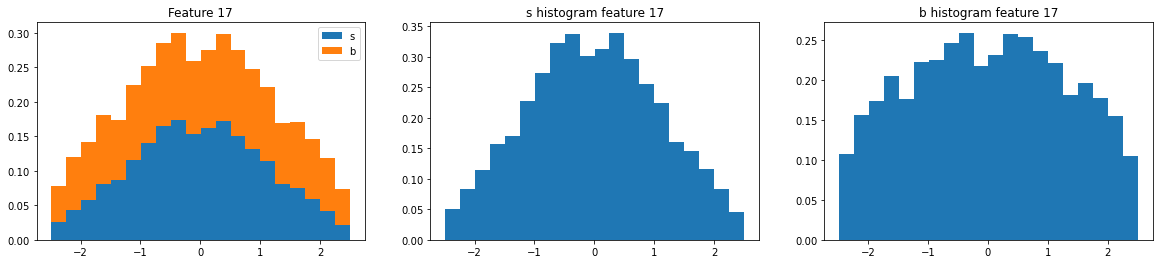

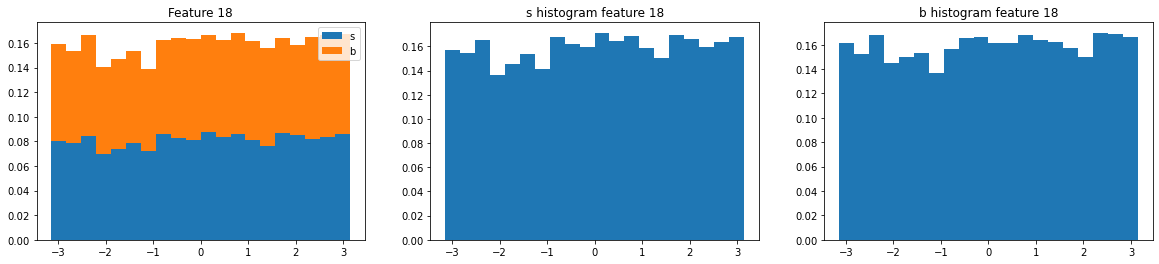

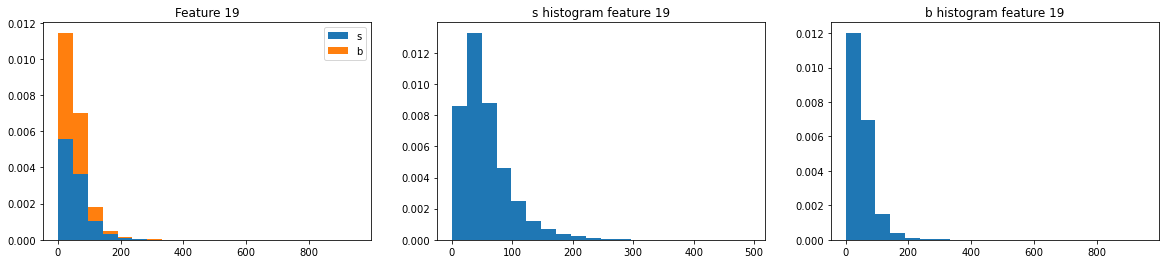

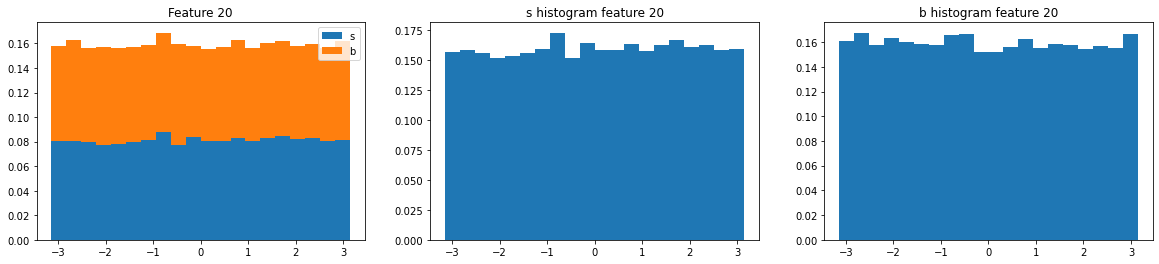

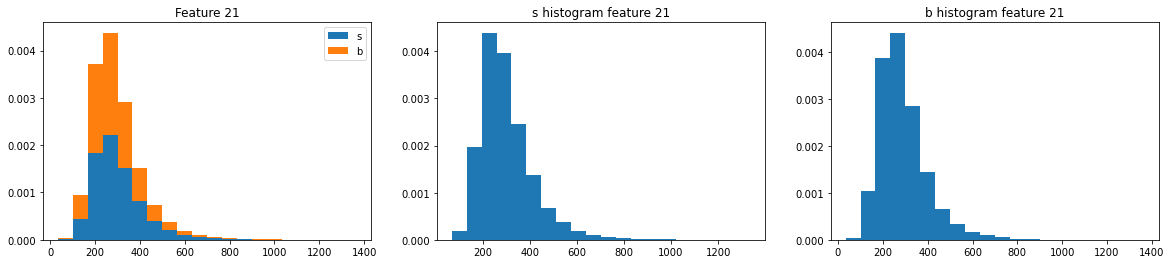

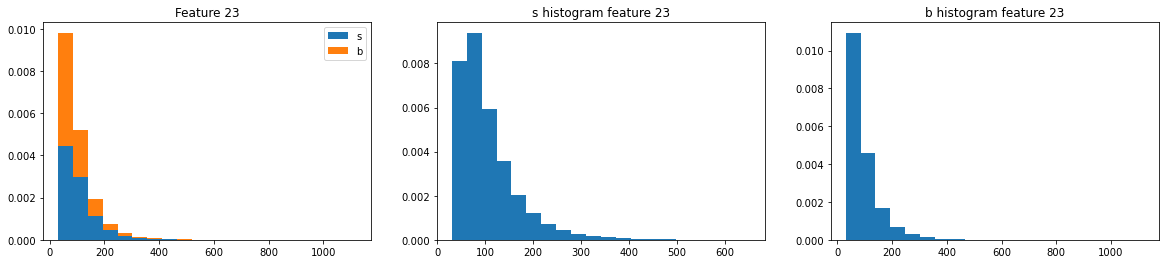

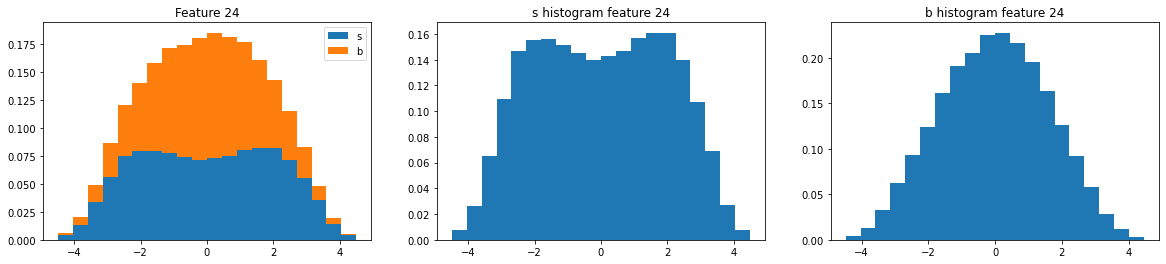

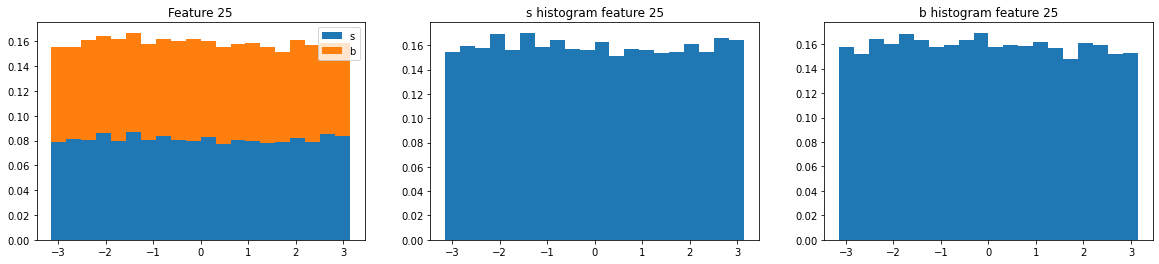

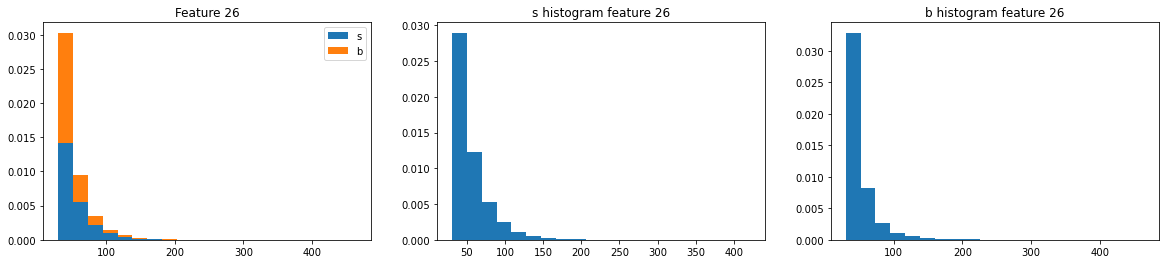

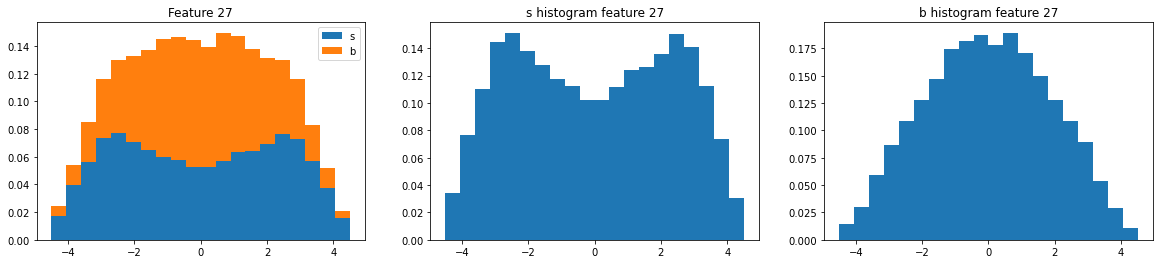

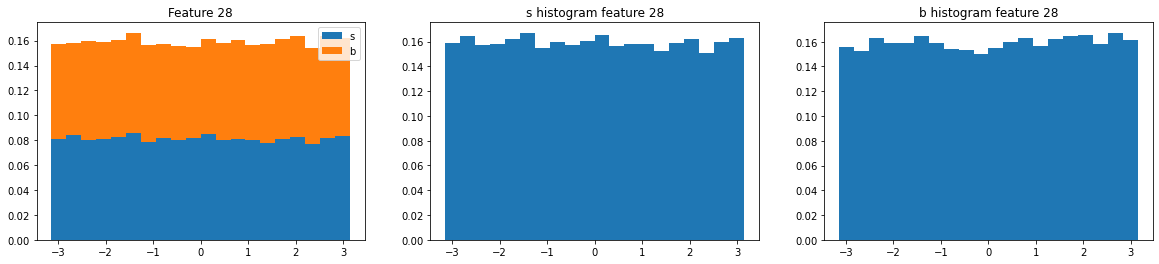

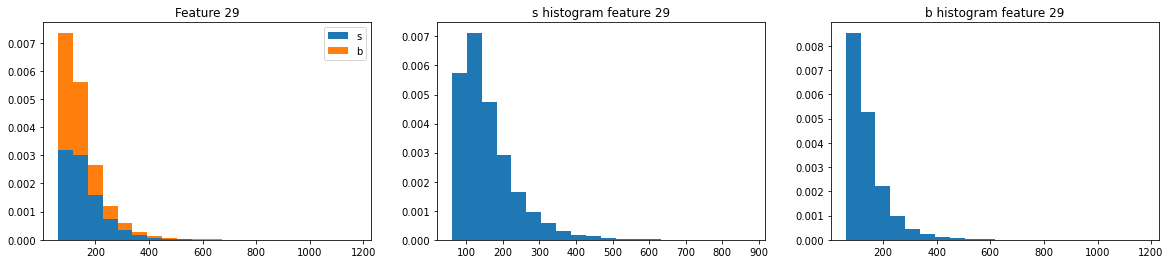

Jet 3: s: 6731, b: 15433 ,total: 22164


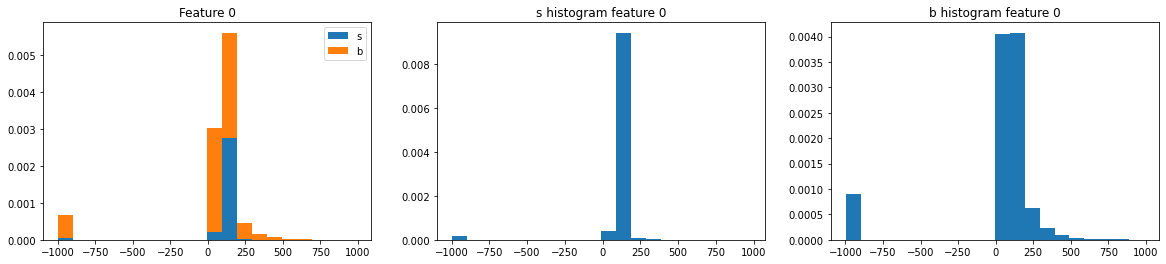

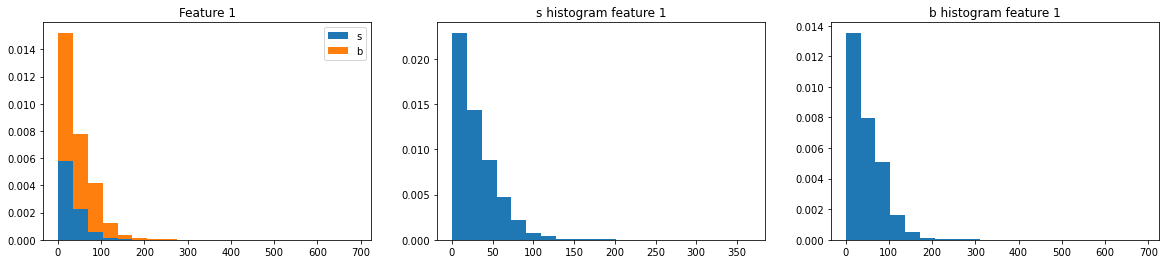

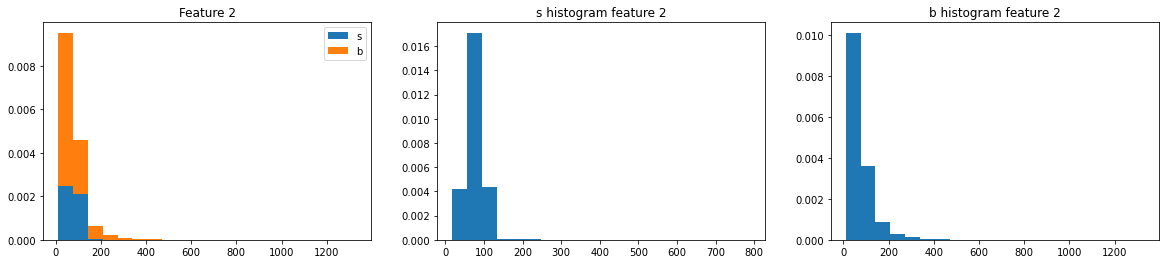

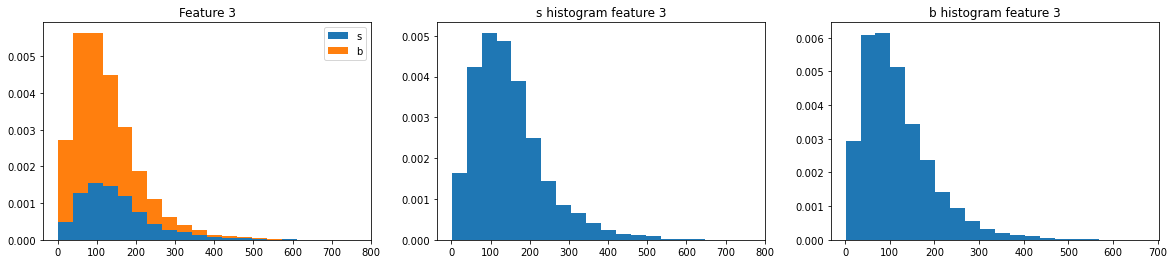

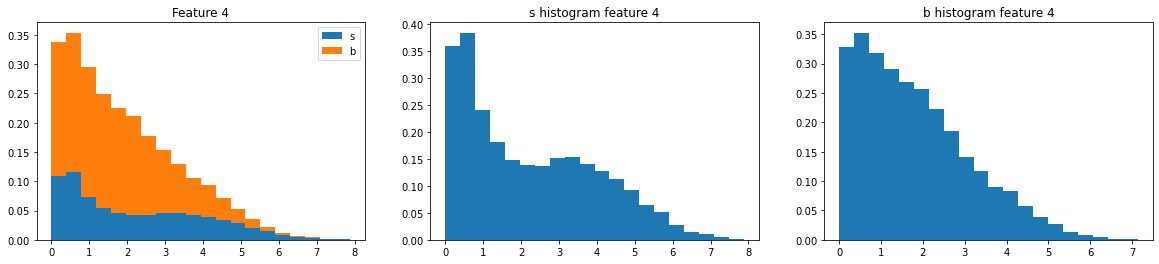

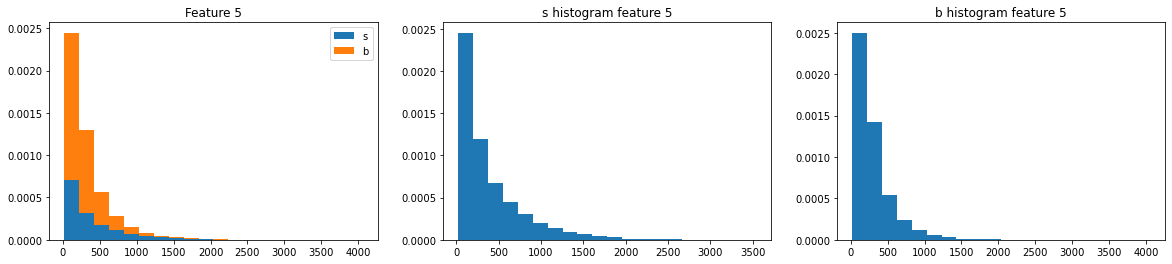

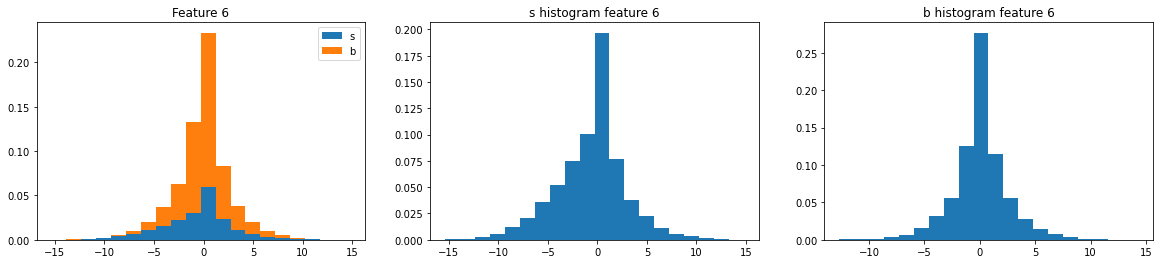

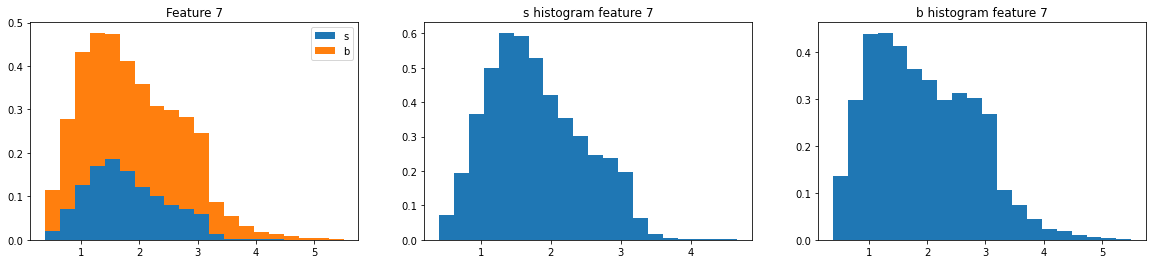

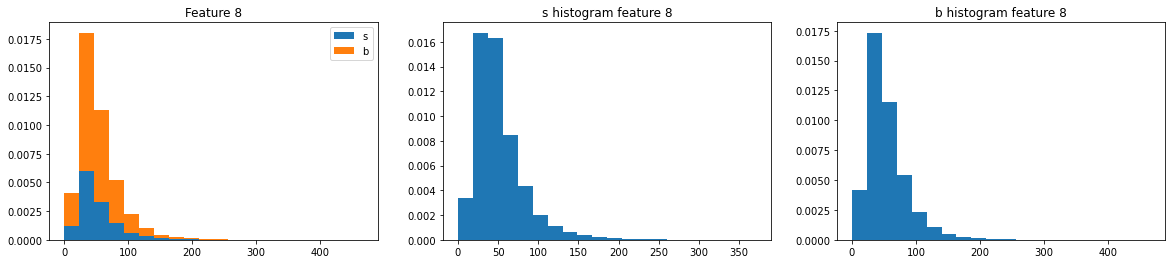

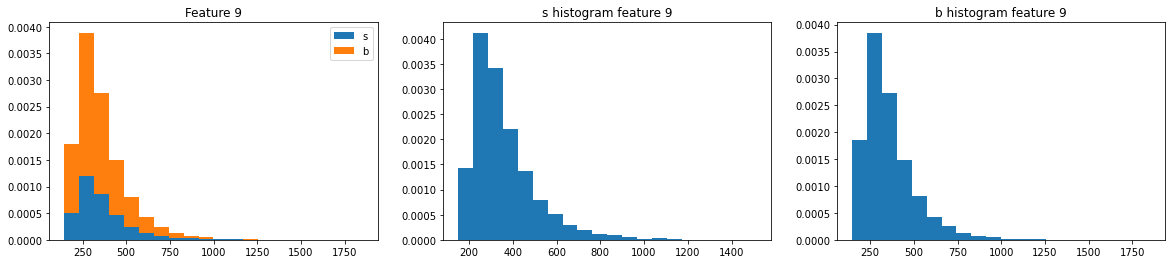

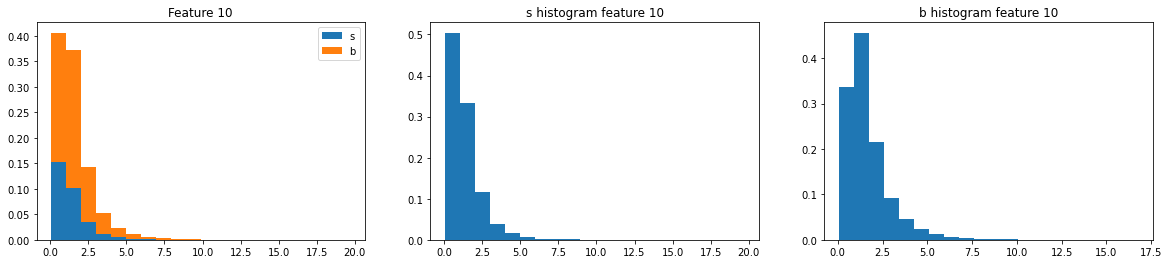

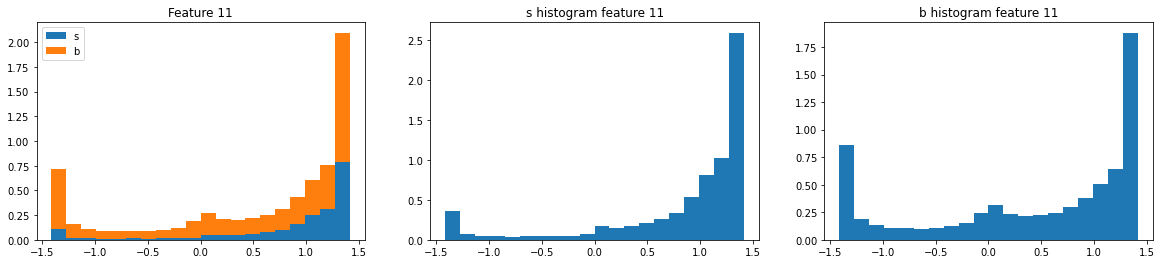

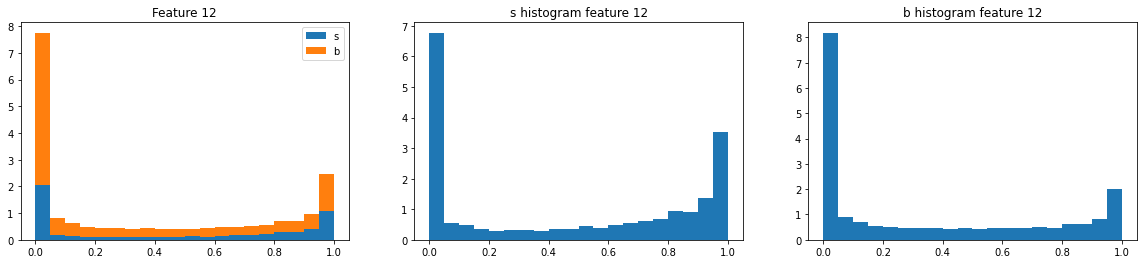

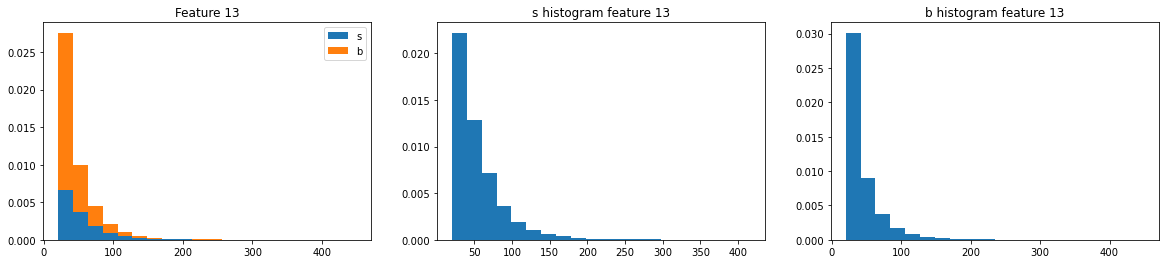

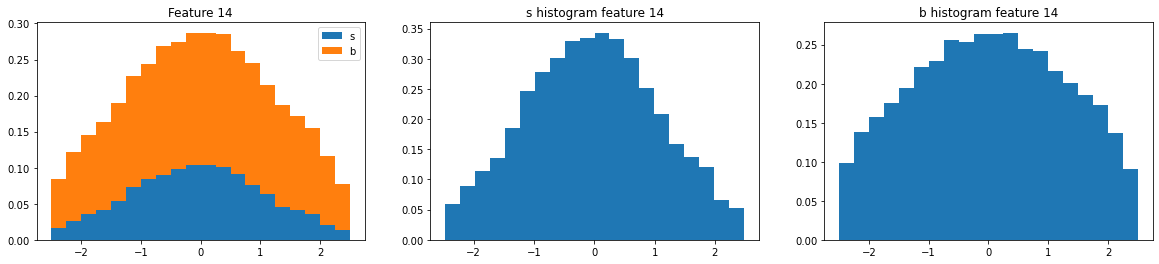

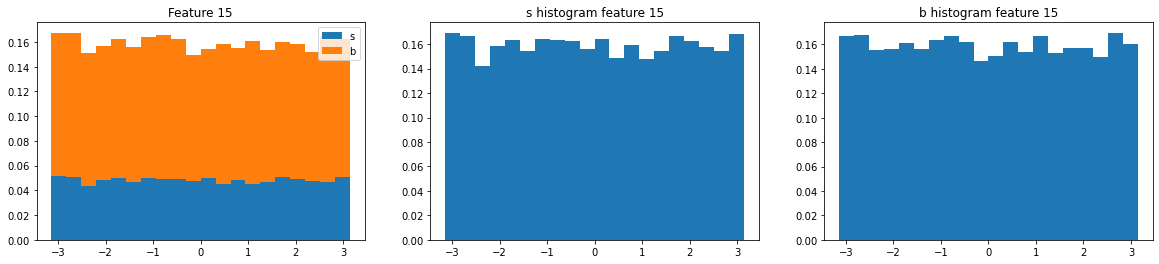

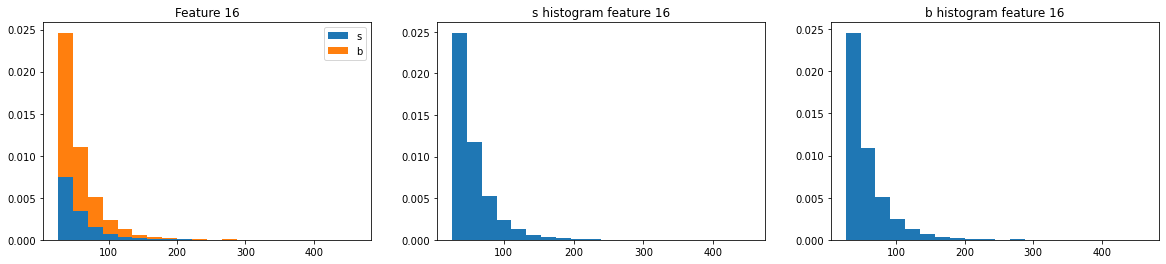

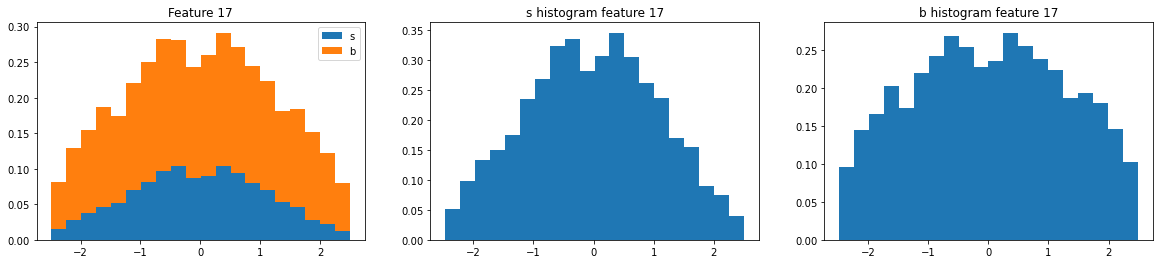

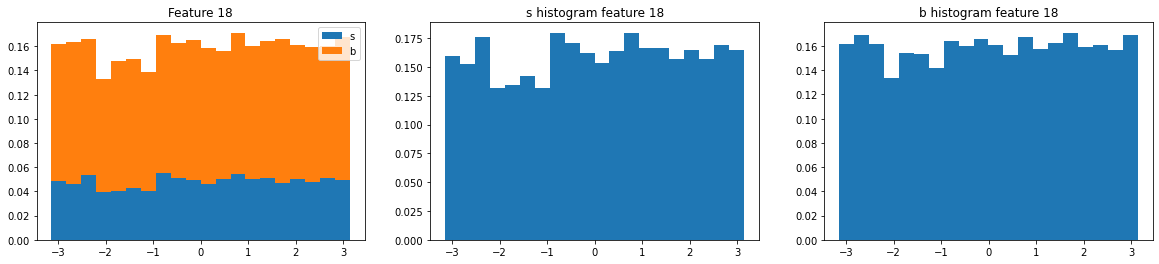

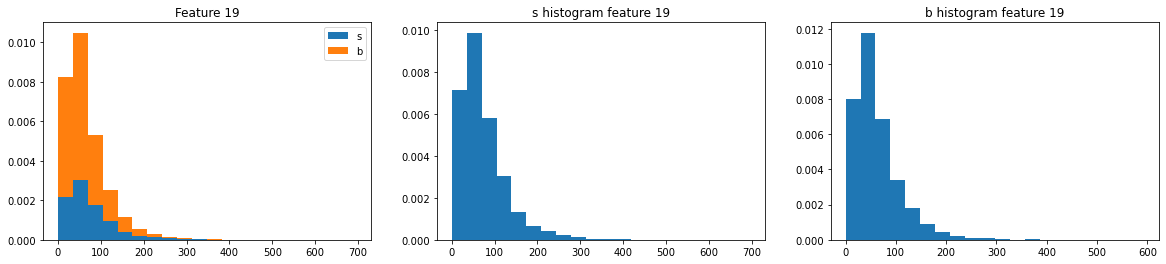

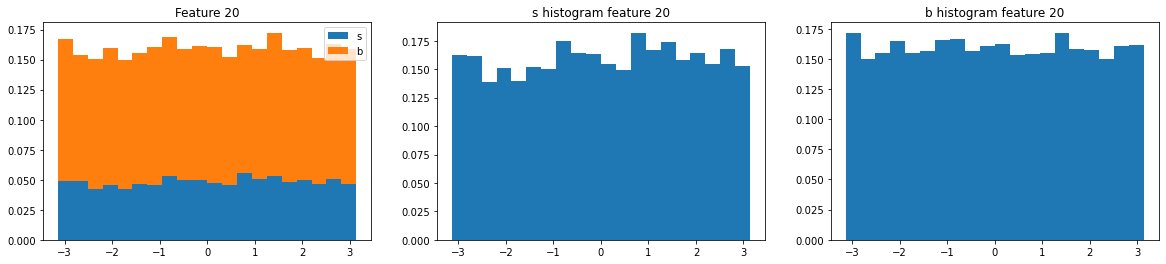

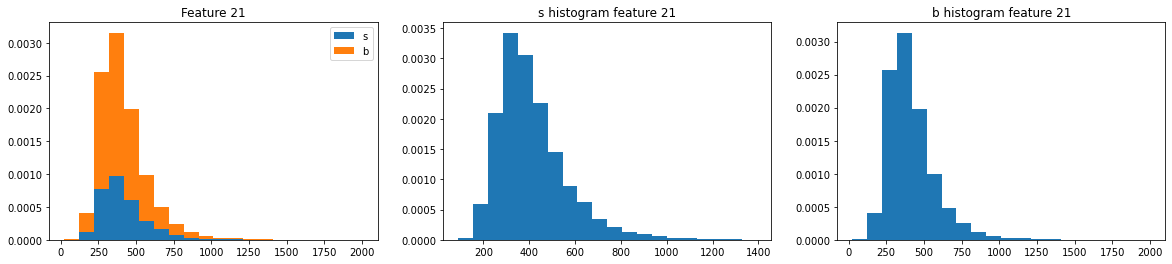

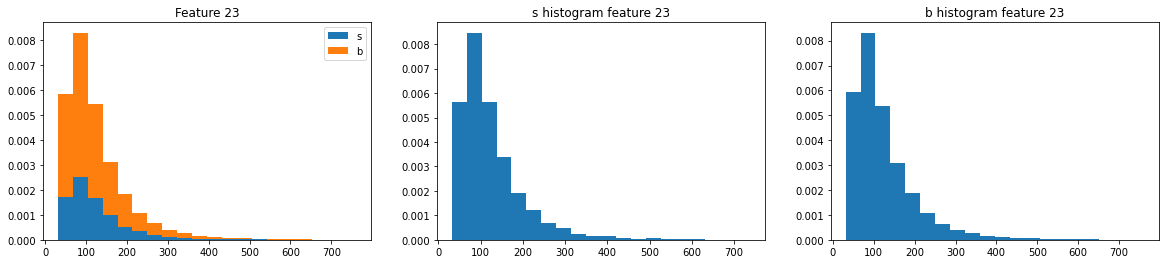

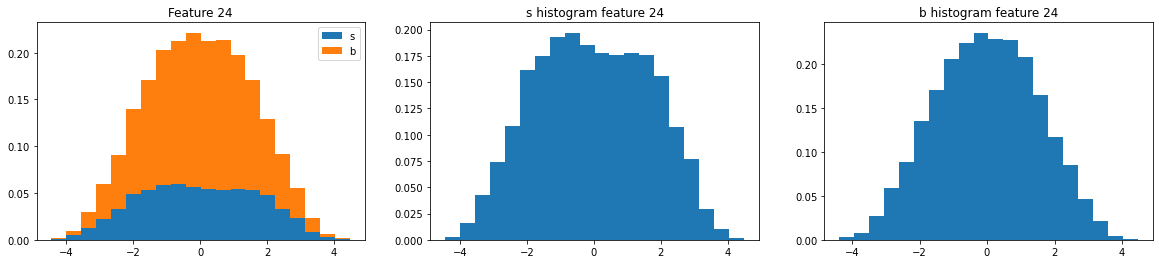

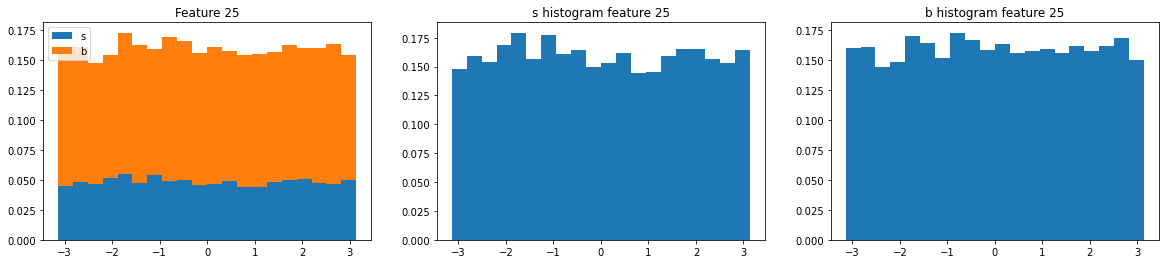

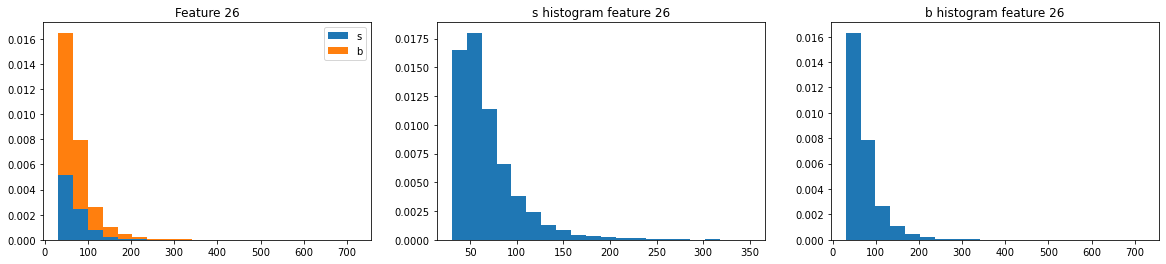

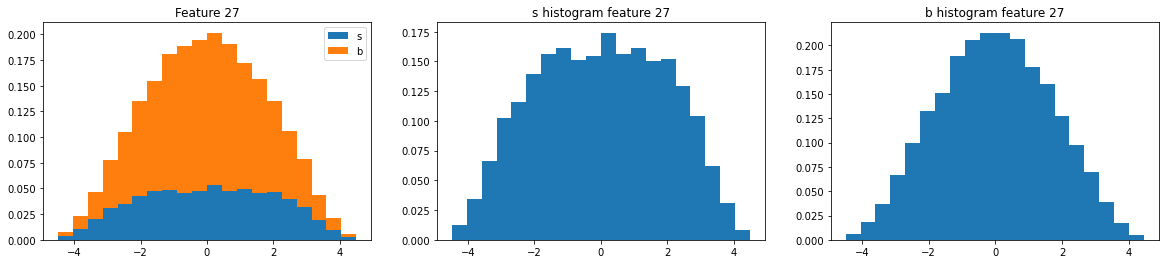

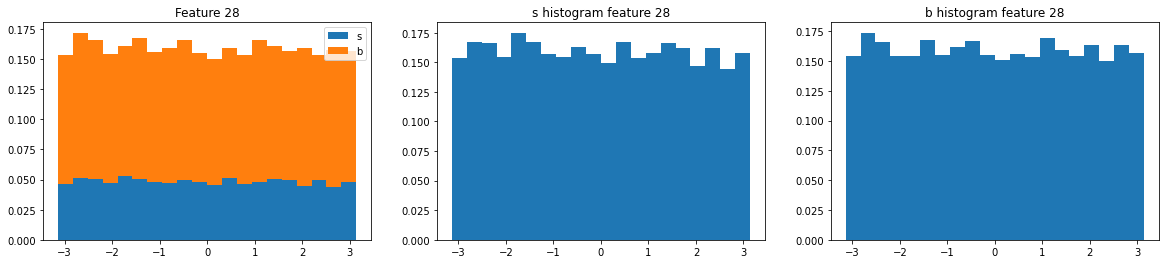

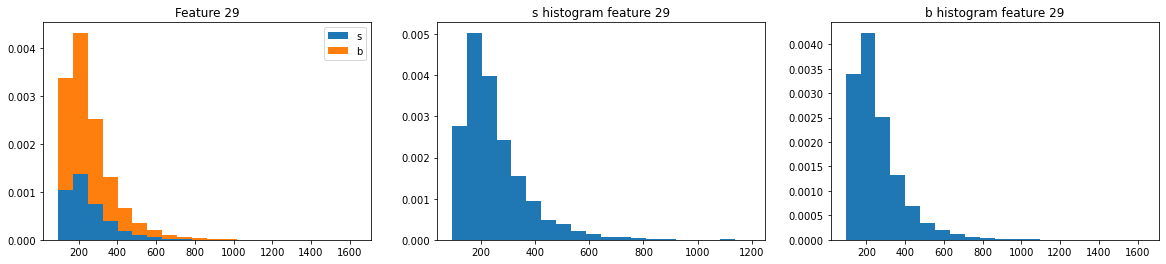

In [10]:
print("Overall: s: ",np.sum(y==1),", b: ",np.sum(y==-1)," ,total:",len(y))
for jet in range(4):
    print('Jet {:}: s: {:}, b: {:} ,total: {:}'.format(jet, np.sum(y_jet[jet]==1),np.sum(y_jet[jet]==-1),len(y_jet[jet])))
    for n,feat in enumerate(idx_jet_undef[jet]):
        plt.figure(figsize=(20,4))
        plt.subplot(131)
        plt.hist([tx_jet[jet][y_jet[jet]==1,n],tx_jet[jet][y_jet[jet]==-1,n]], 20, density=True, histtype='bar', stacked=True)
        plt.legend(['s','b'])
        plt.title('Feature '+str(feat))
        plt.subplot(132)
        plt.title('s histogram feature '+str(feat))
        plt.hist(tx_jet[jet][y_jet[jet]==1,n], 20, density=True, histtype='bar', stacked=True)
        plt.subplot(133)
        plt.title('b histogram feature '+str(feat))
        plt.hist(tx_jet[jet][y_jet[jet]==-1,n], 20, density=True, histtype='bar', stacked=True)    
        plt.show()

Overall: s:  85667 , b:  164333  ,total: 250000
Jet 0: s: 25492, b: 74421 ,total: 99913


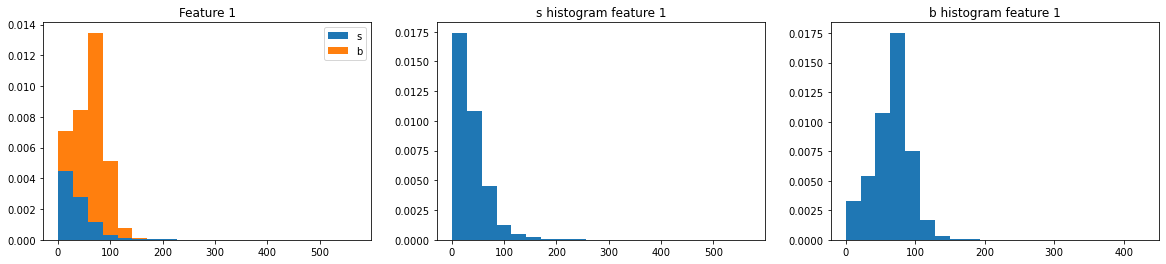

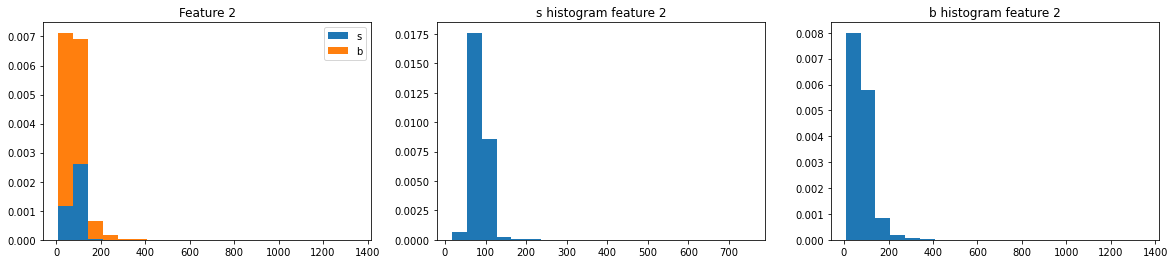

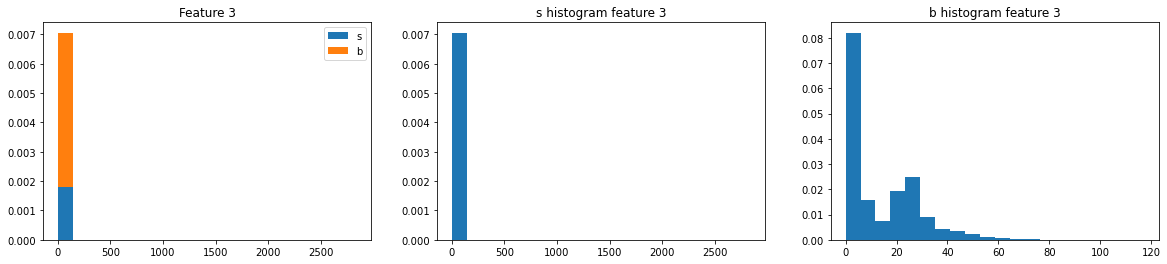

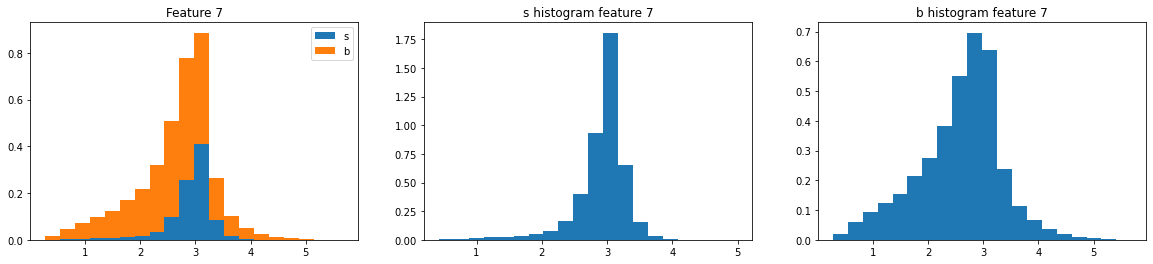

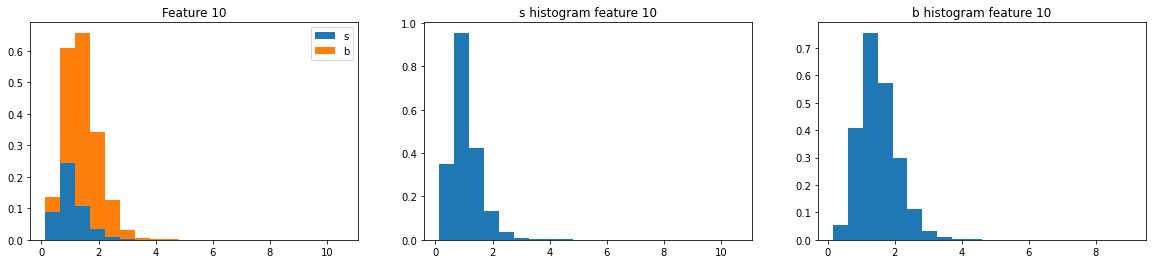

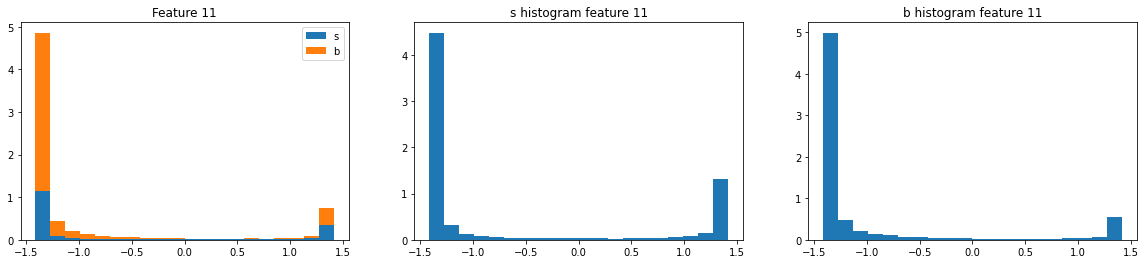

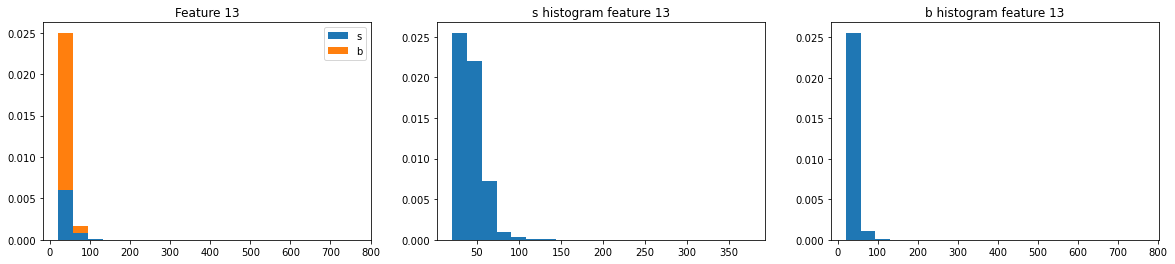

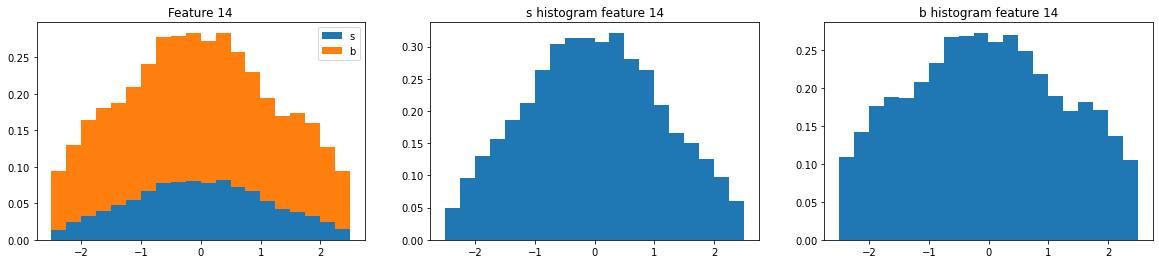

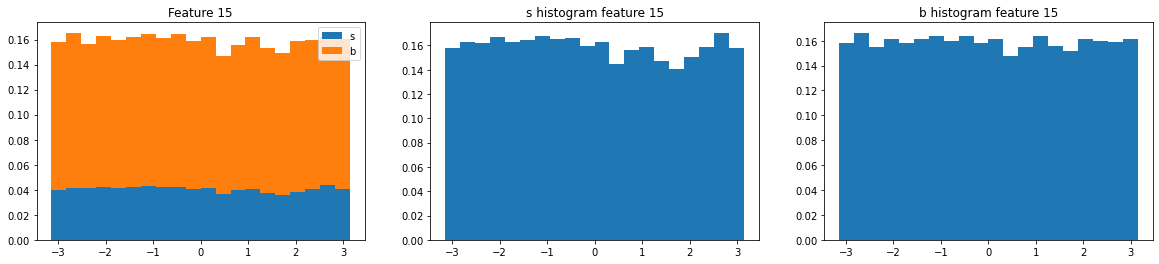

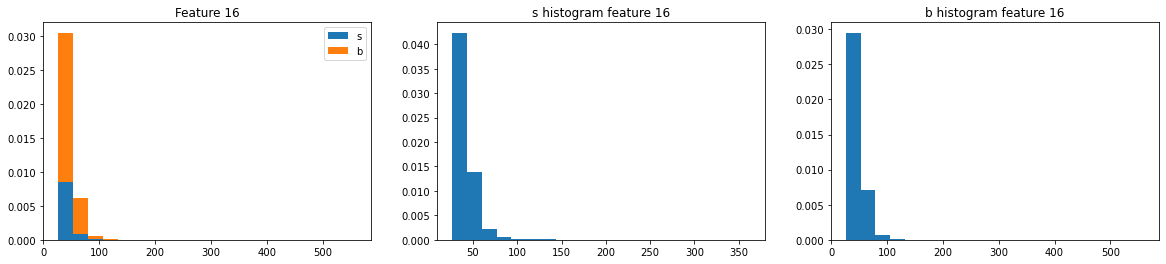

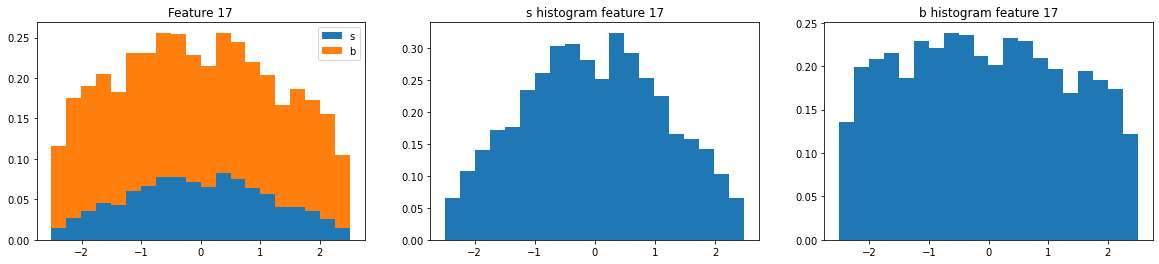

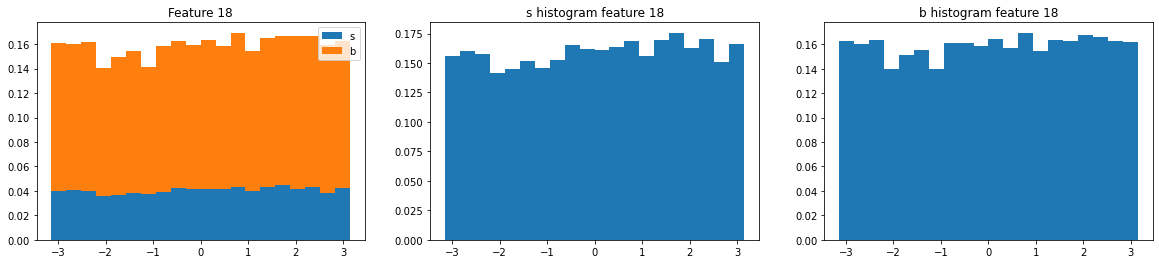

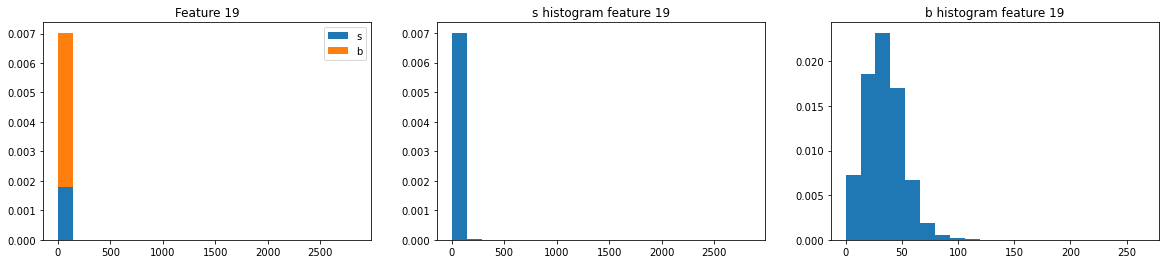

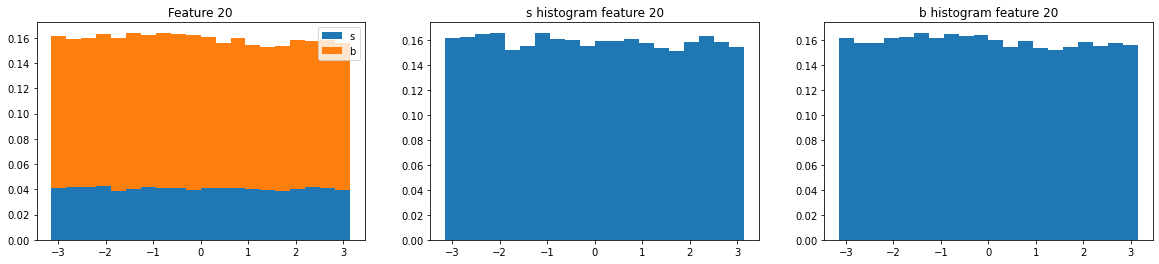

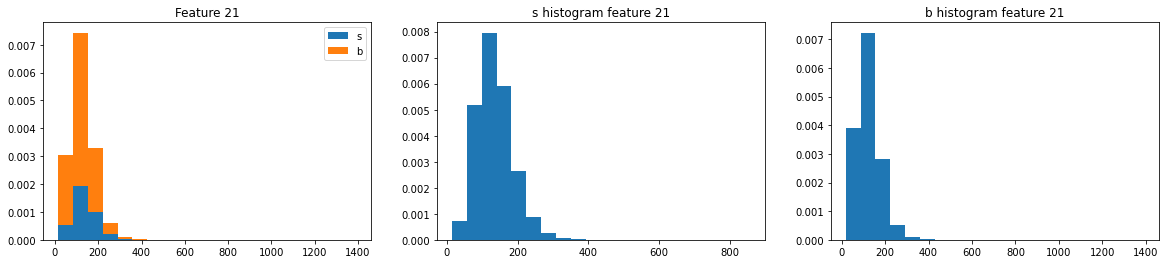

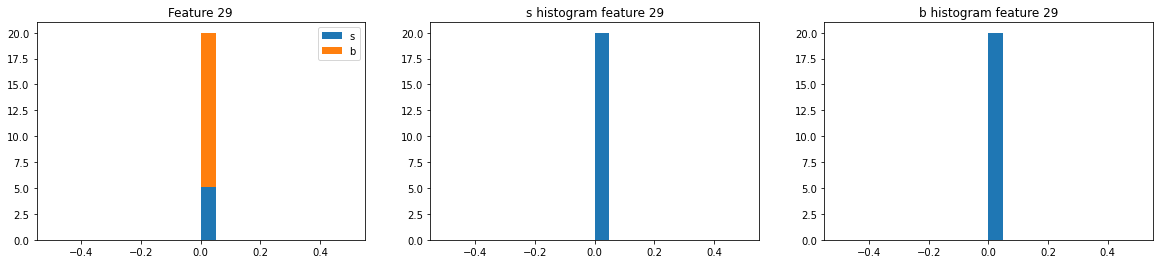

Jet 1: s: 27710, b: 49834 ,total: 77544


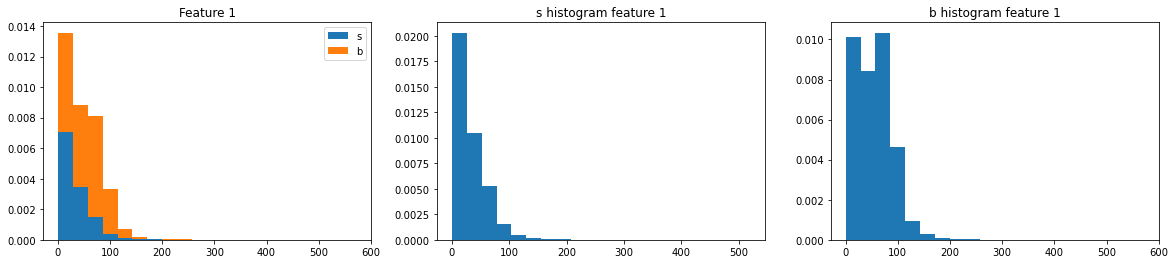

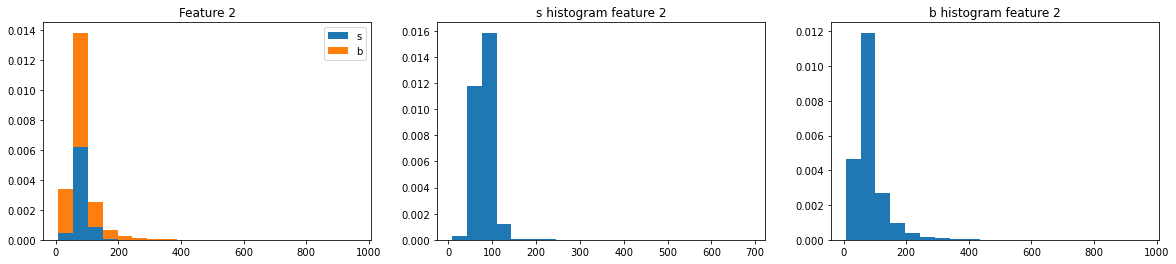

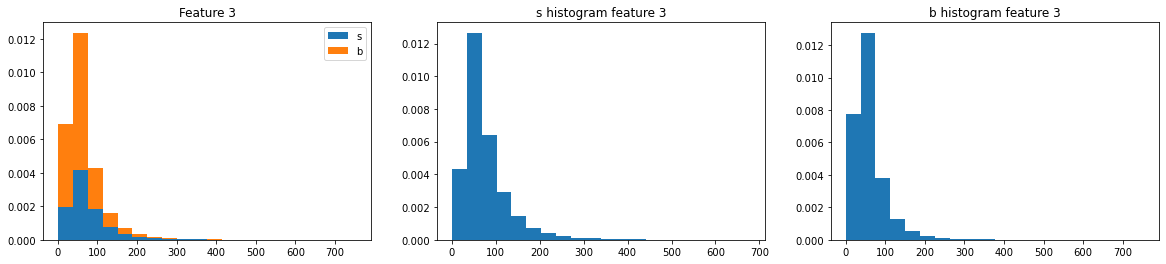

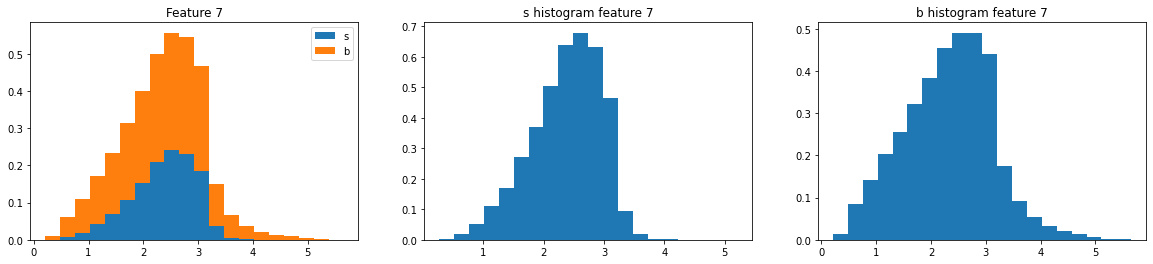

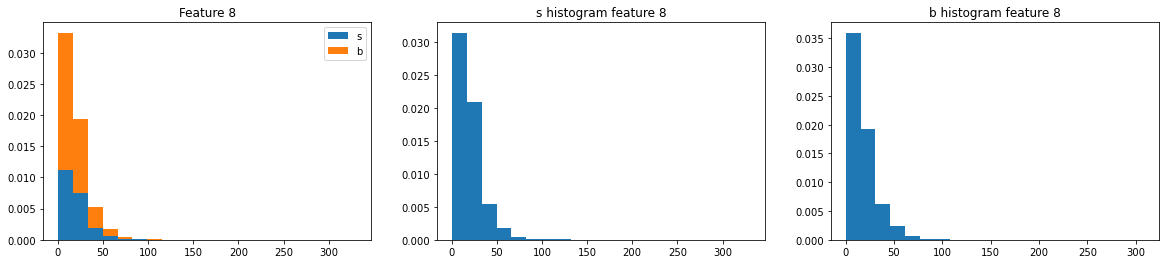

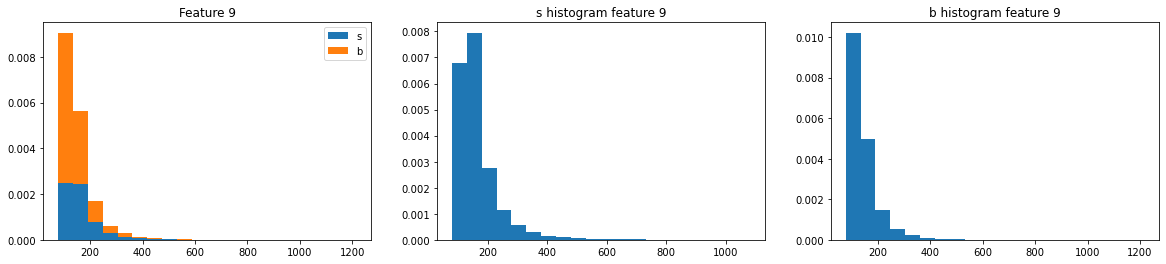

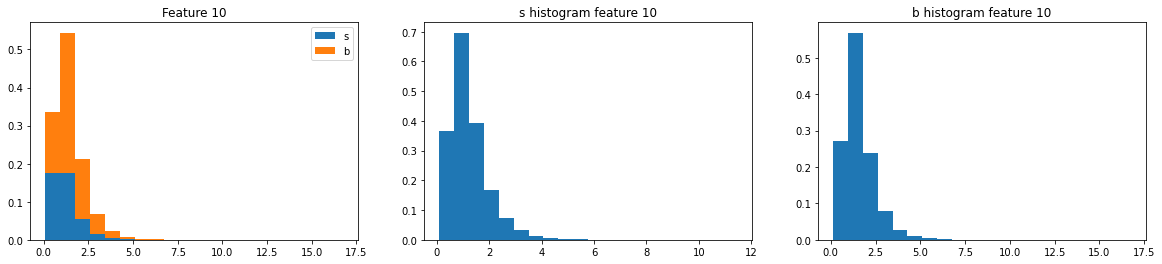

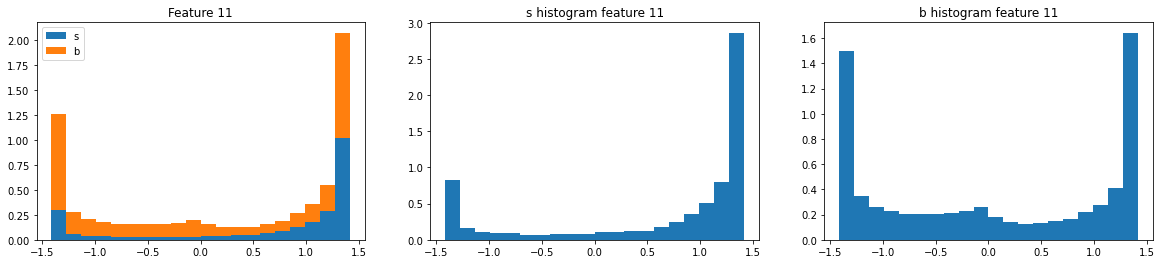

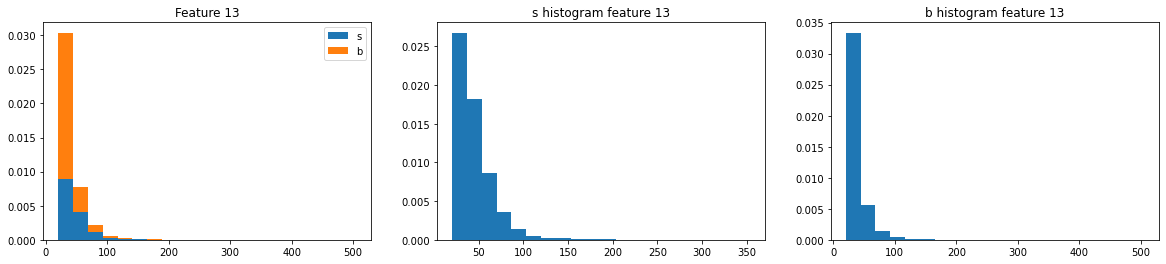

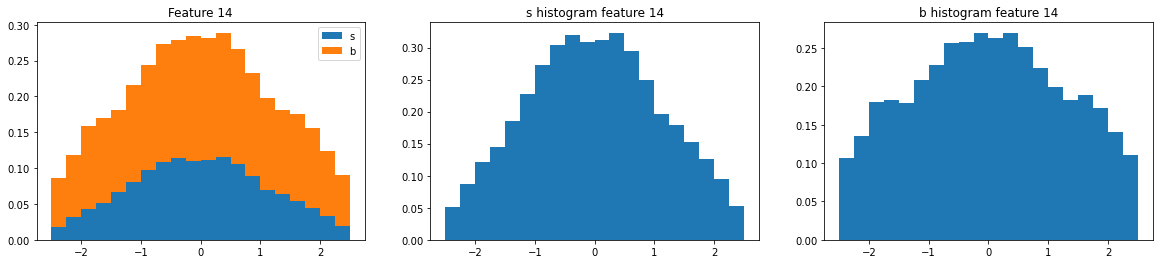

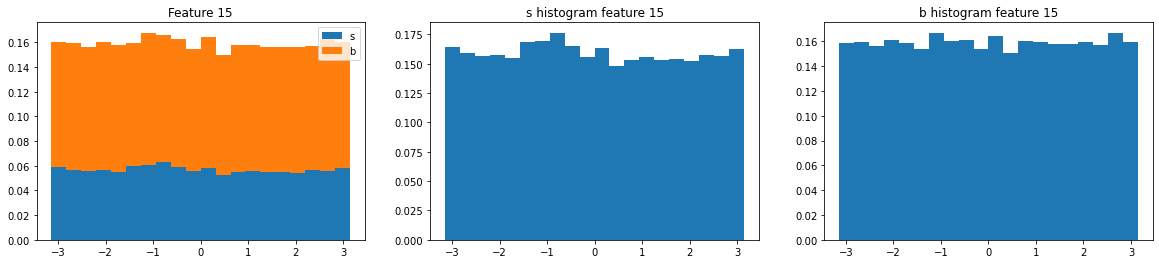

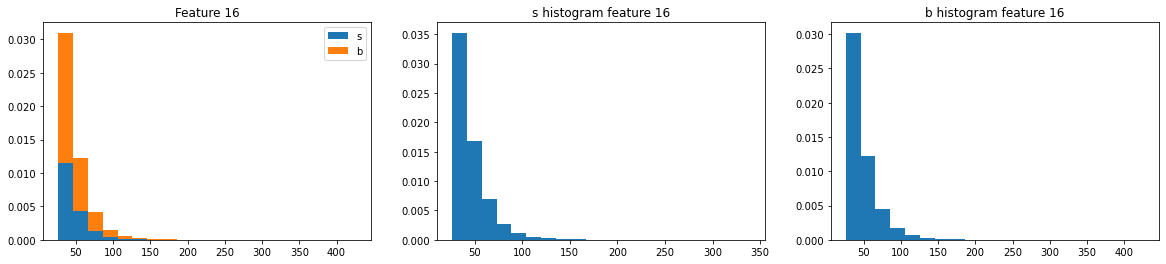

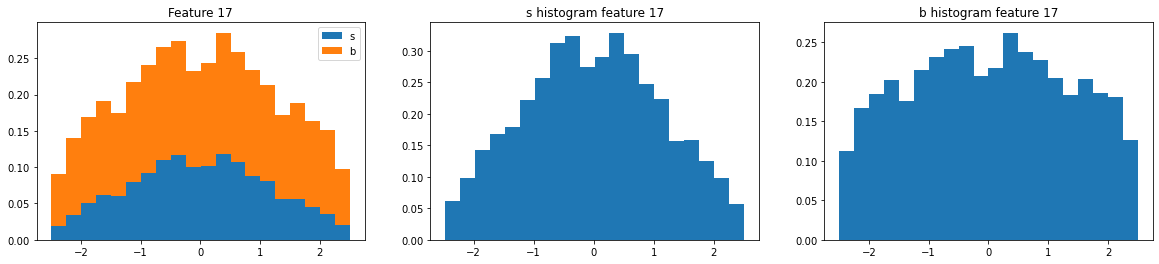

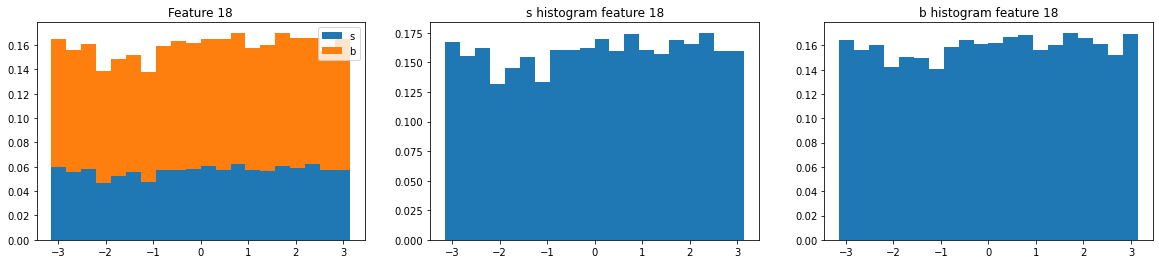

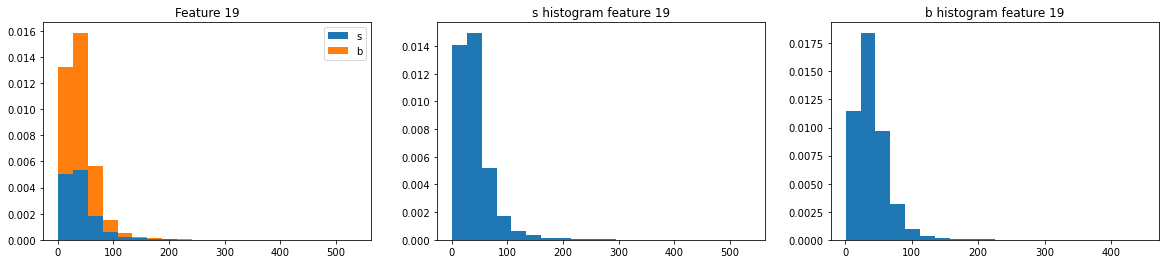

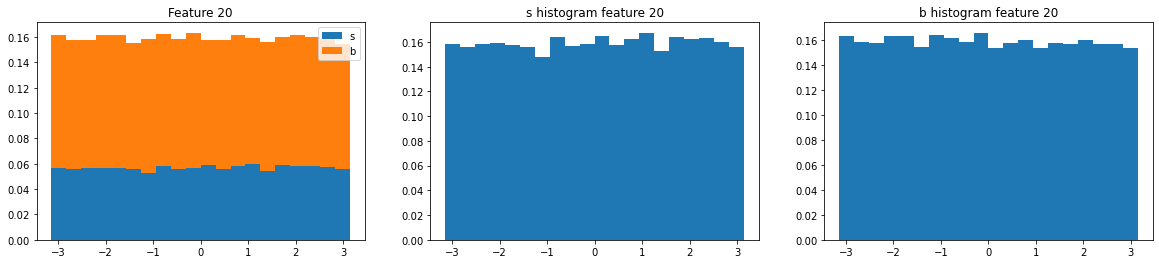

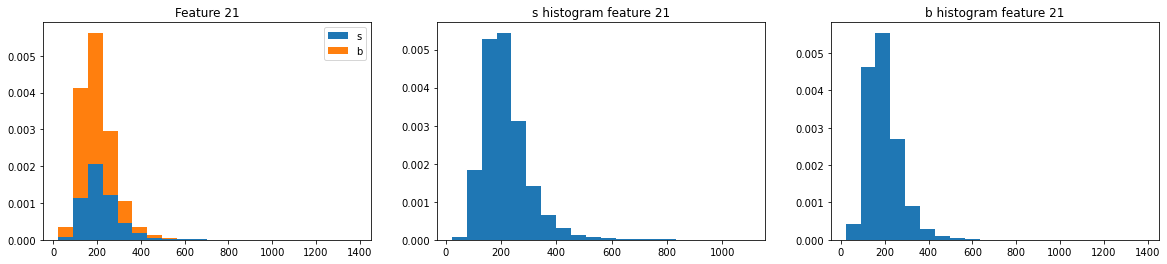

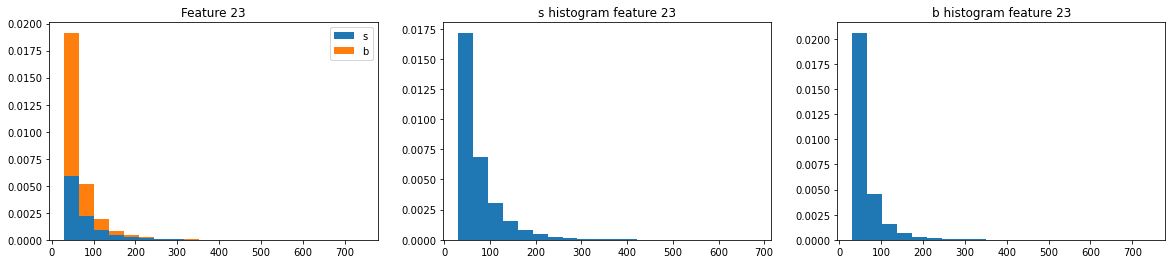

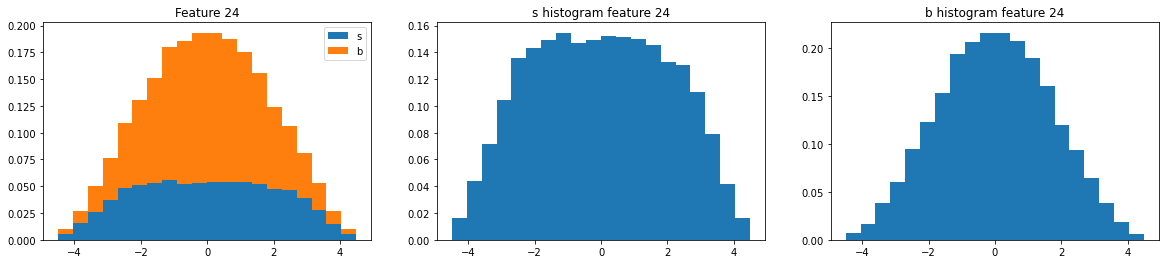

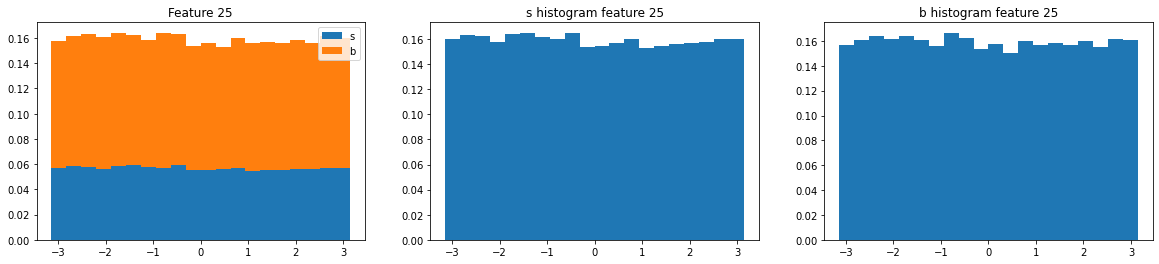

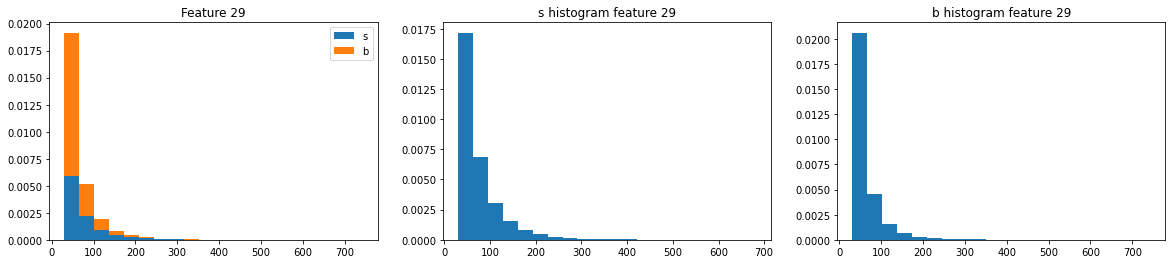

Jet 2: s: 25734, b: 24645 ,total: 50379


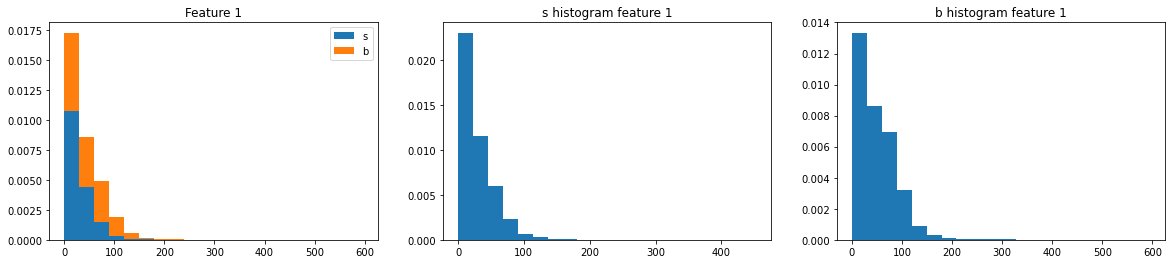

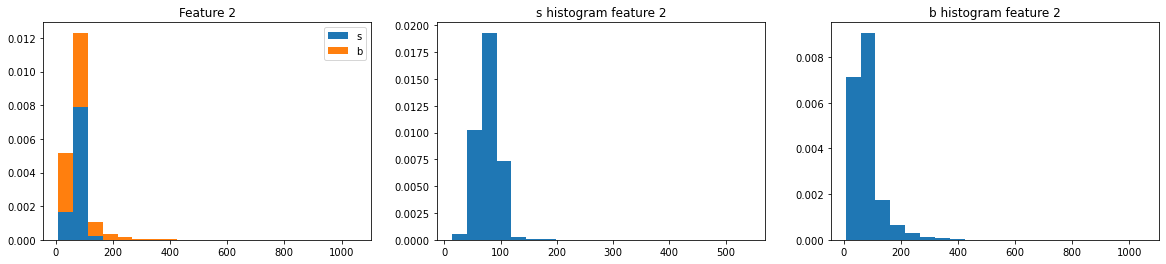

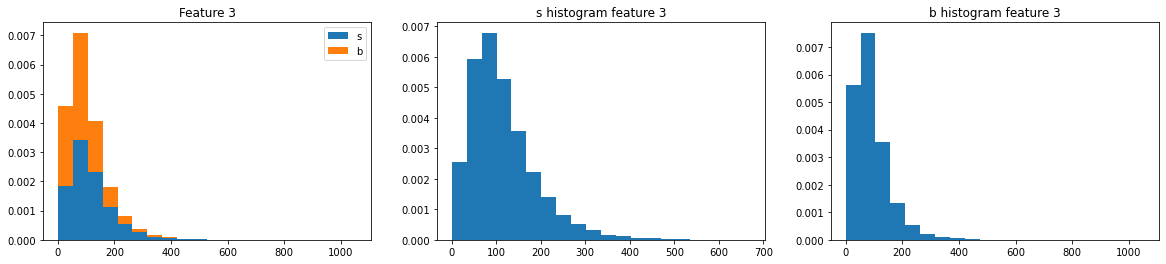

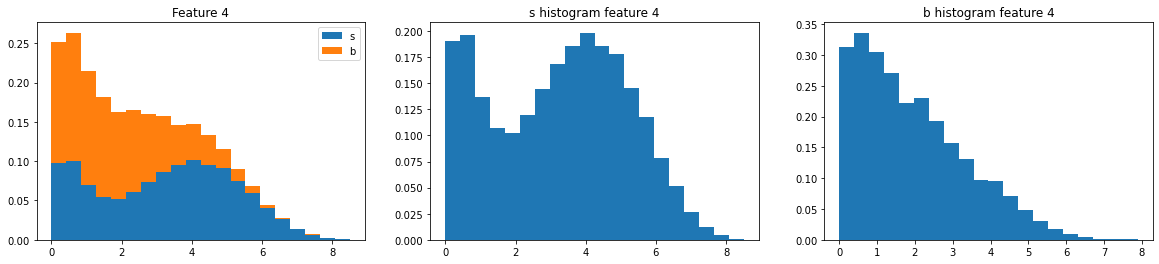

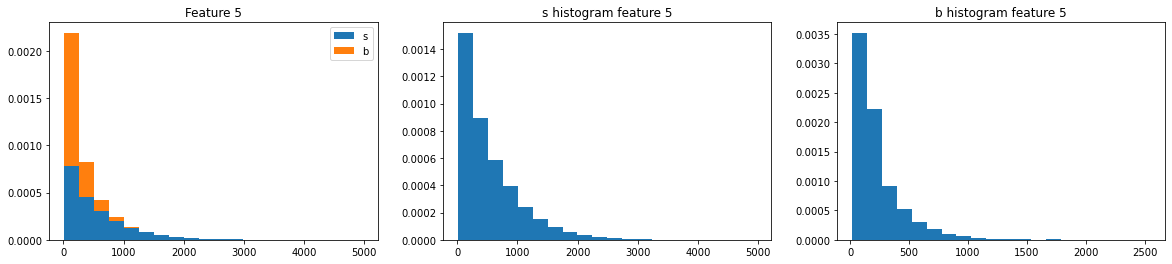

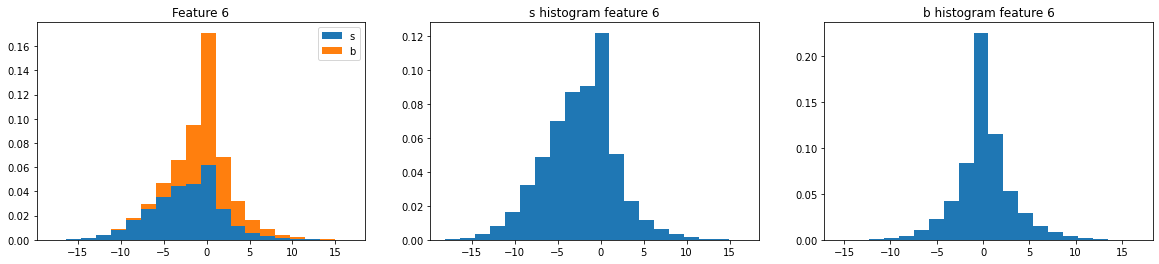

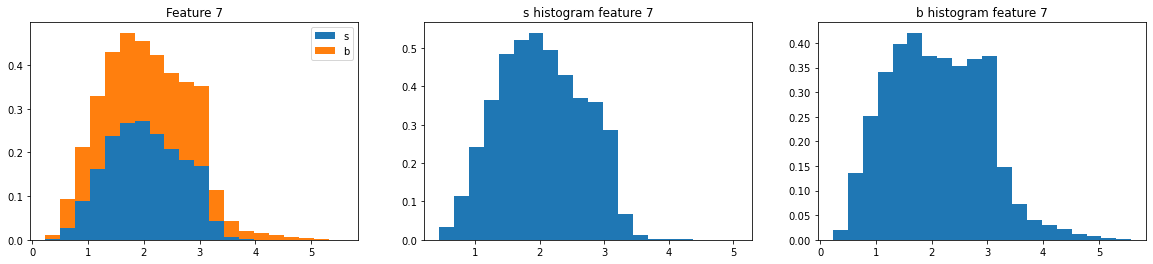

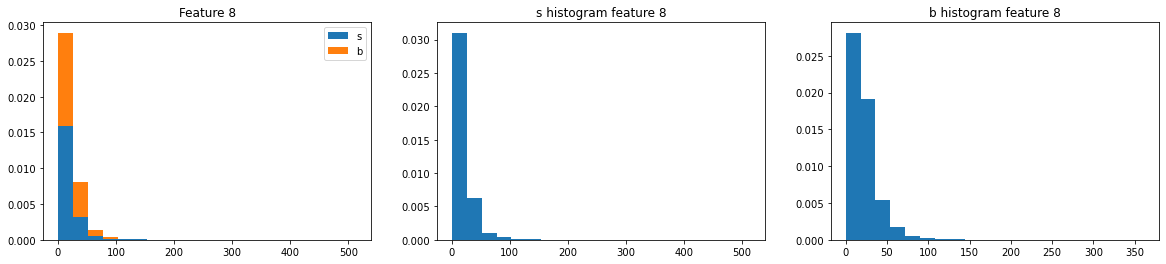

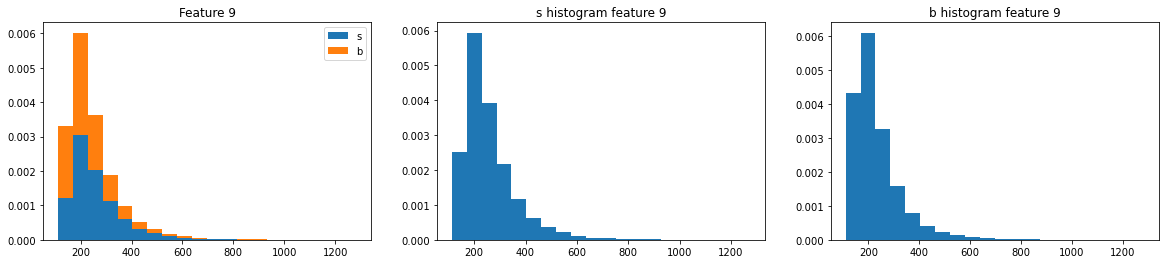

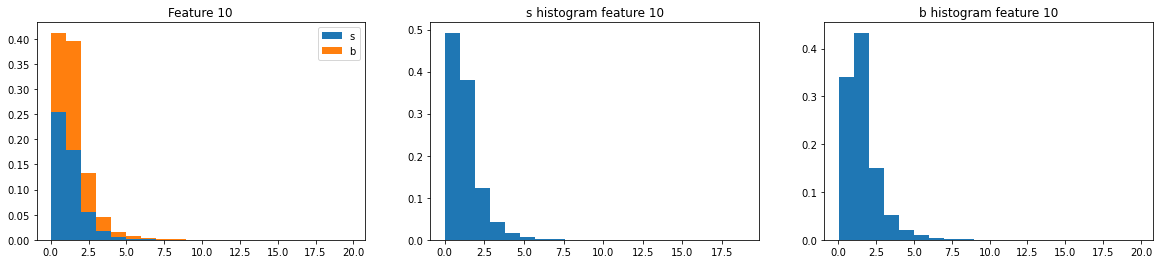

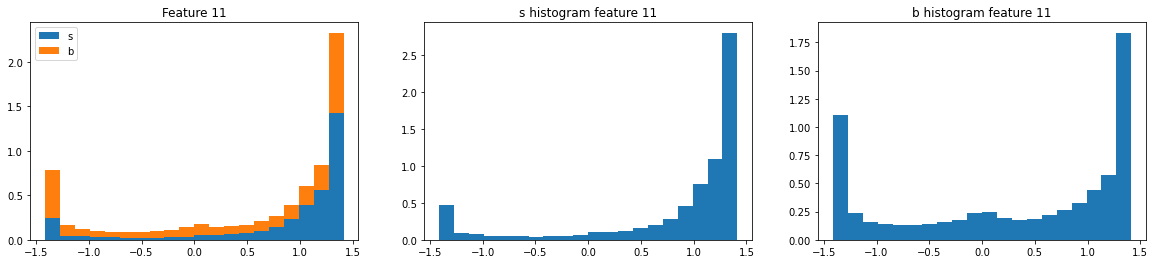

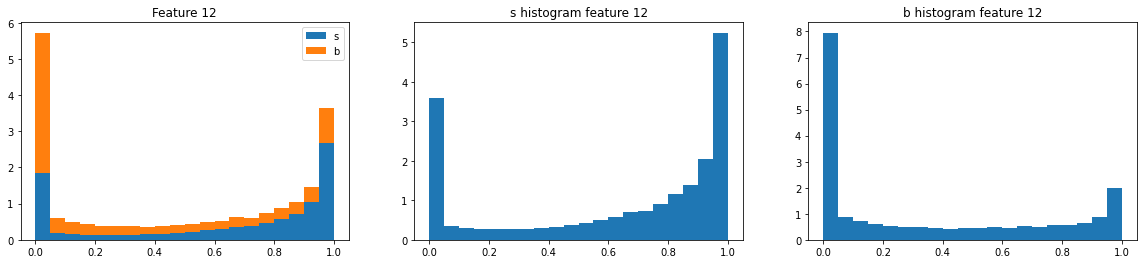

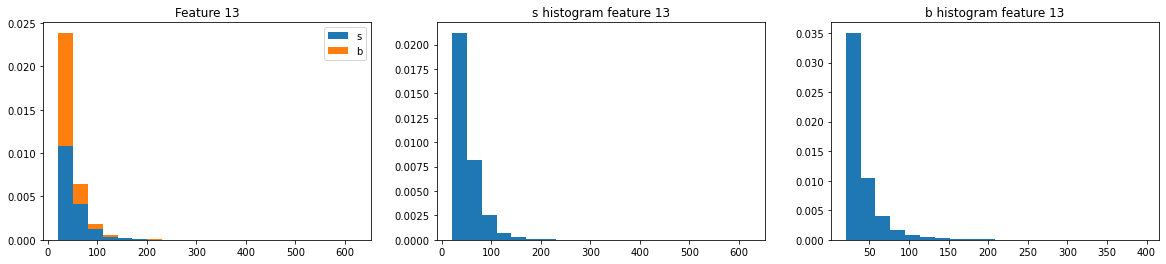

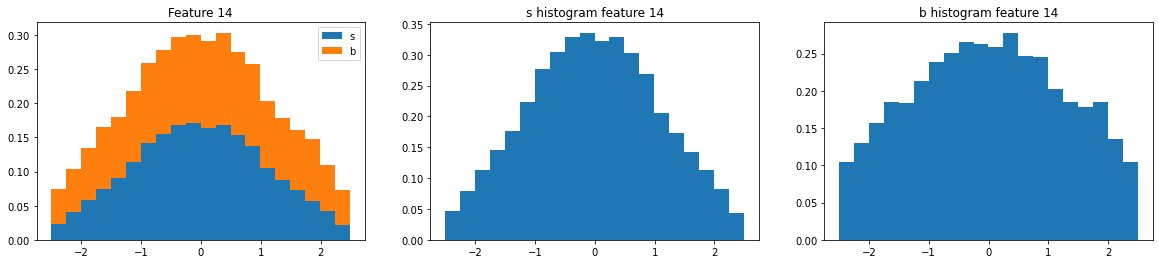

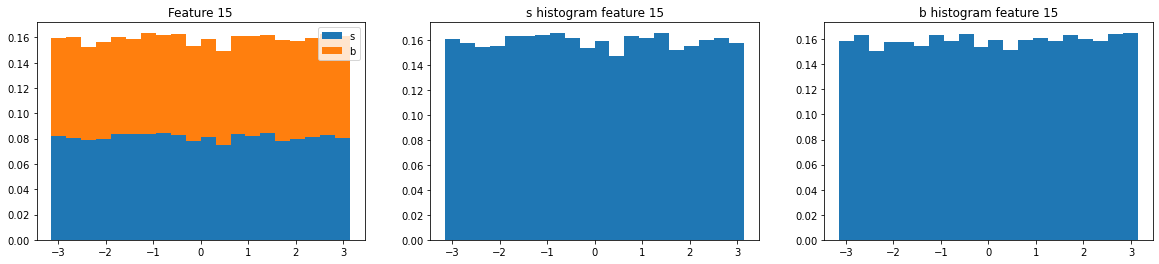

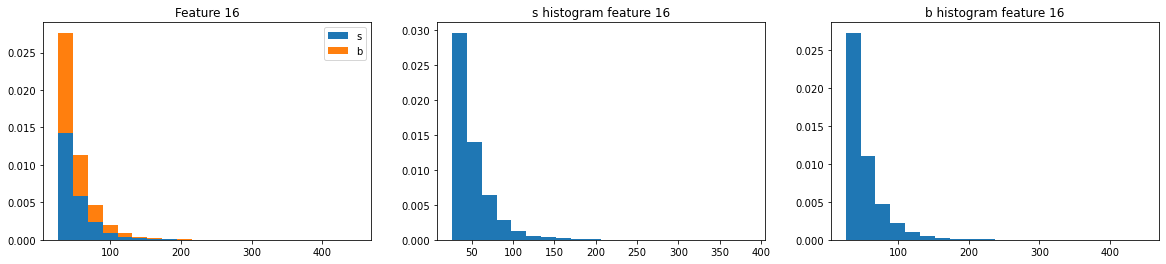

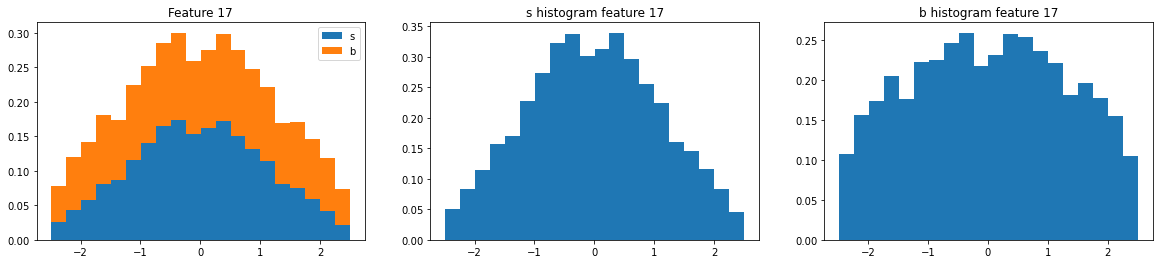

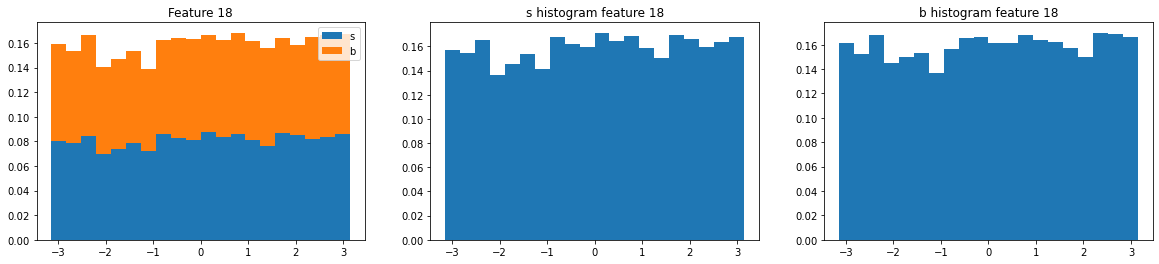

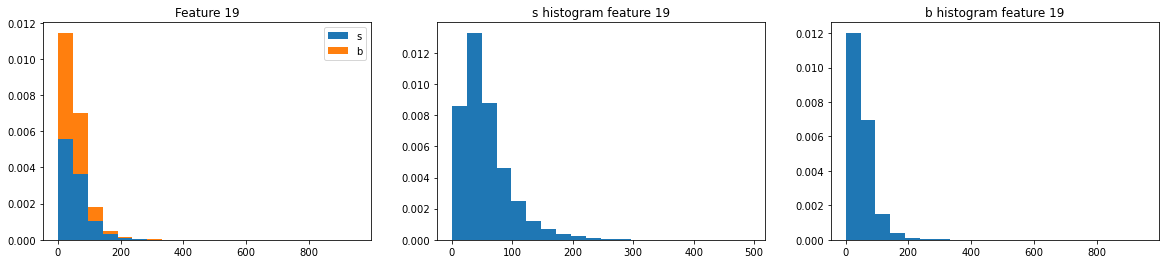

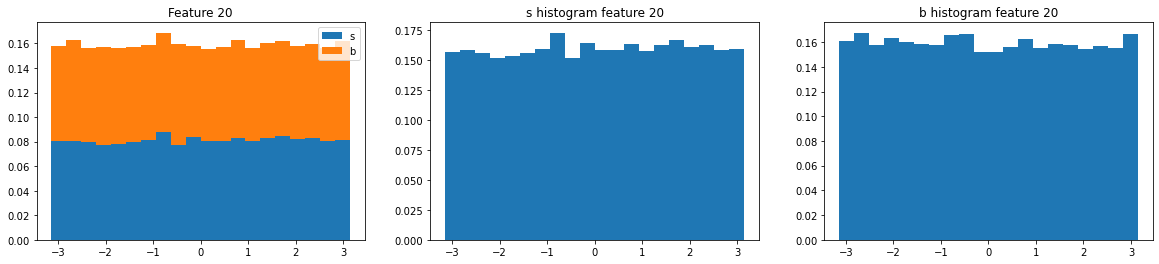

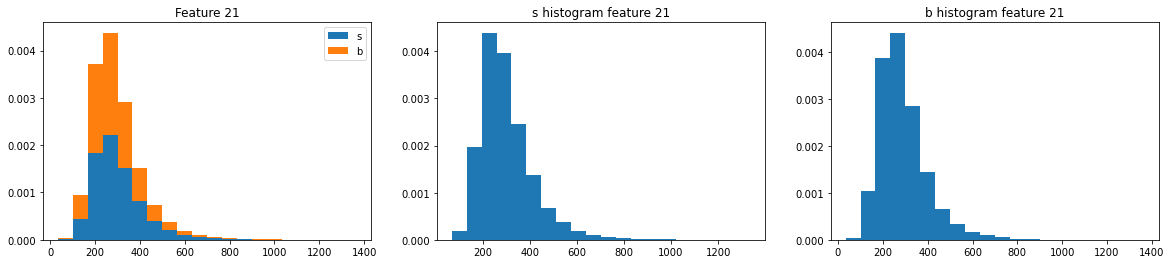

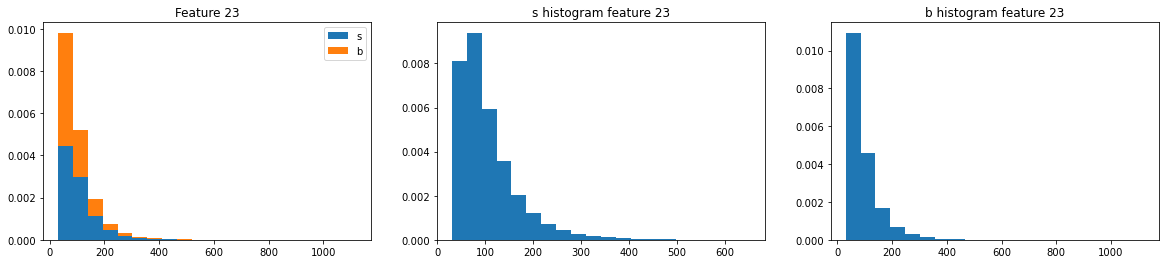

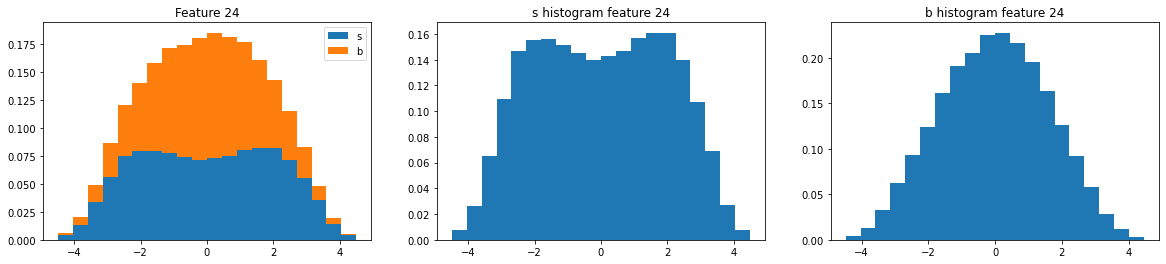

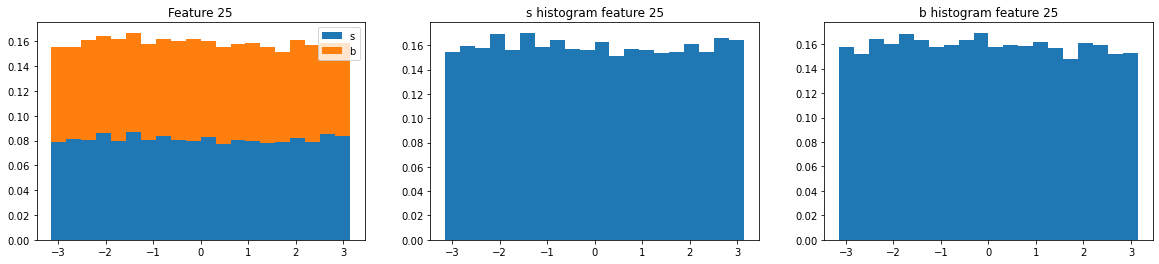

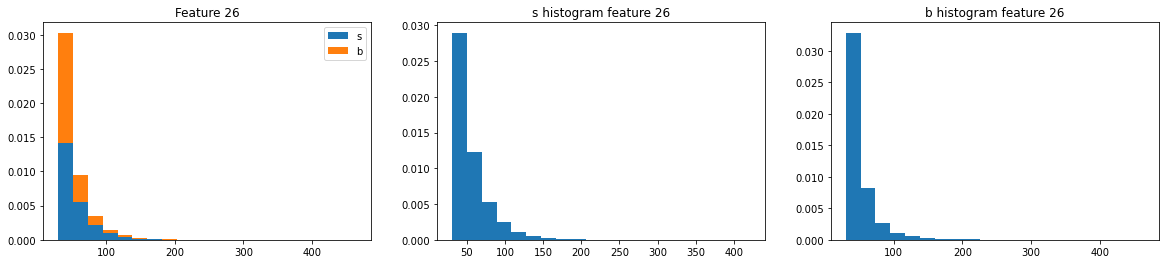

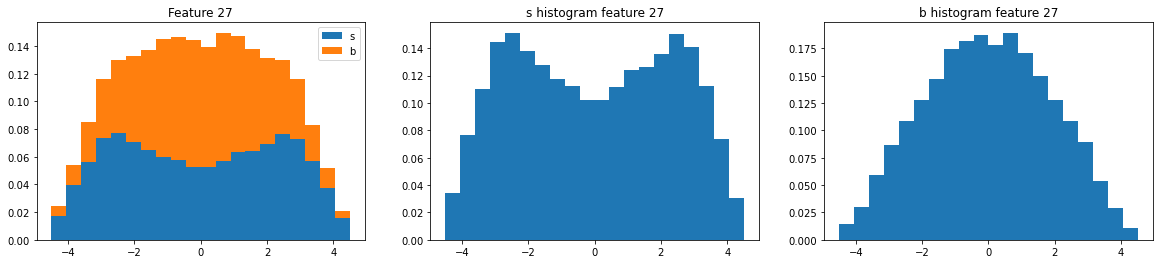

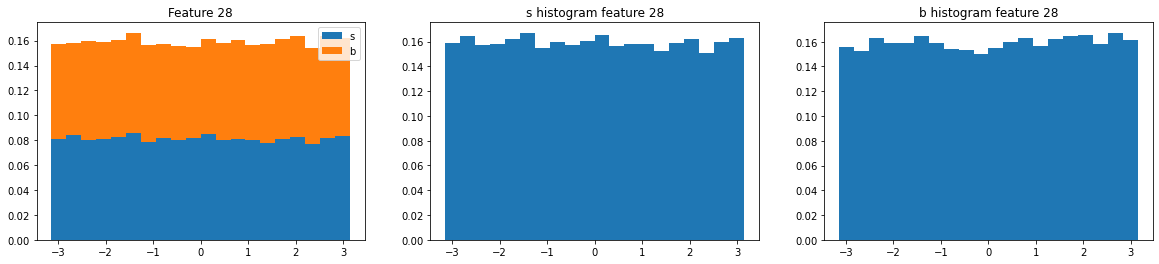

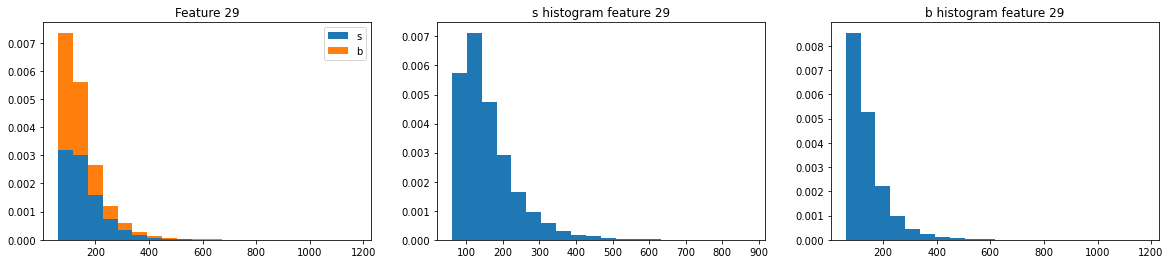

Jet 3: s: 6731, b: 15433 ,total: 22164


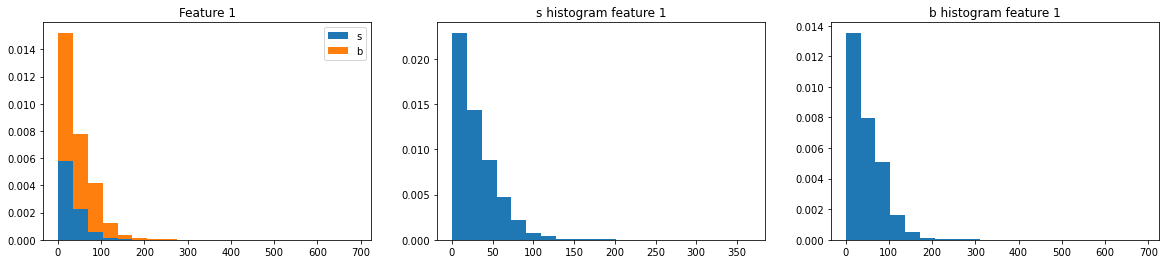

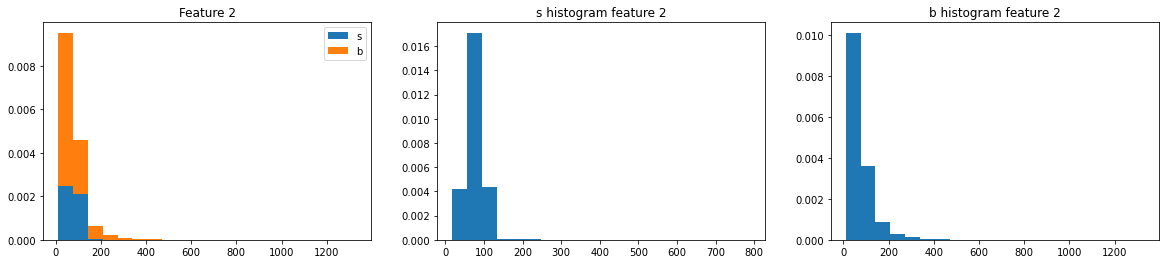

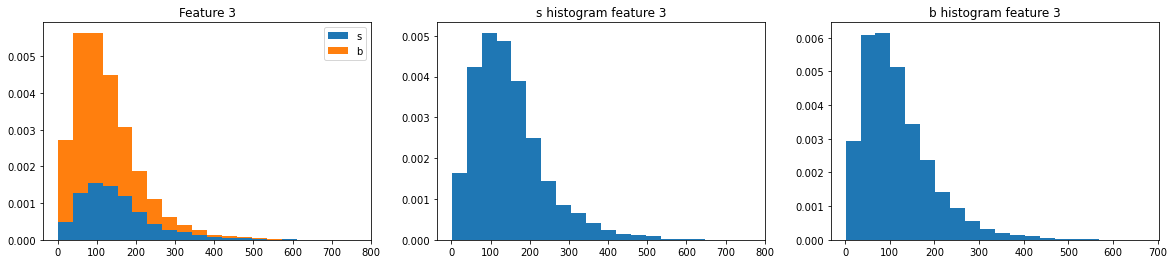

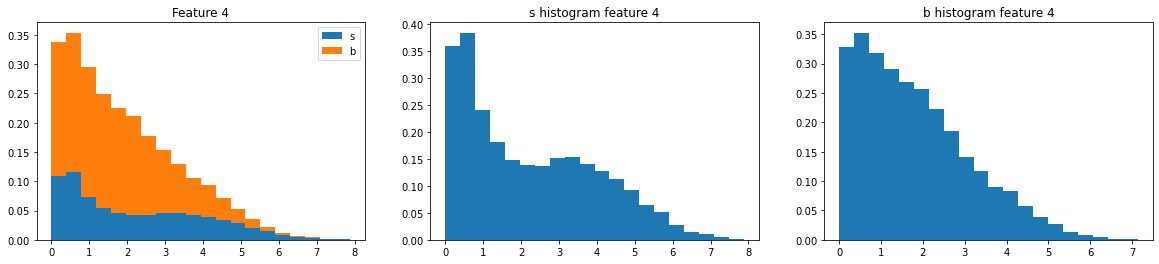

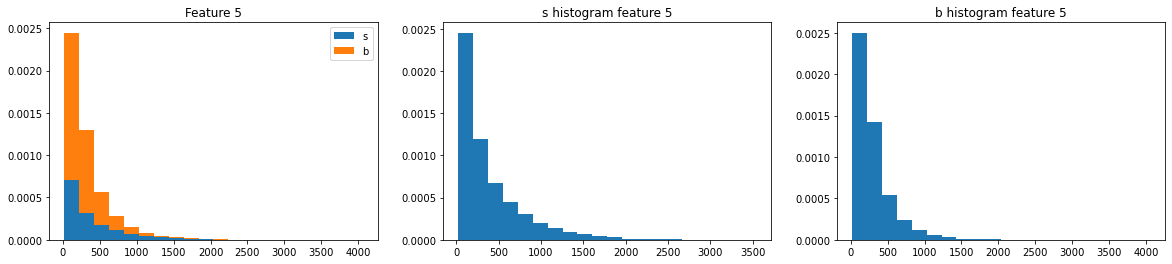

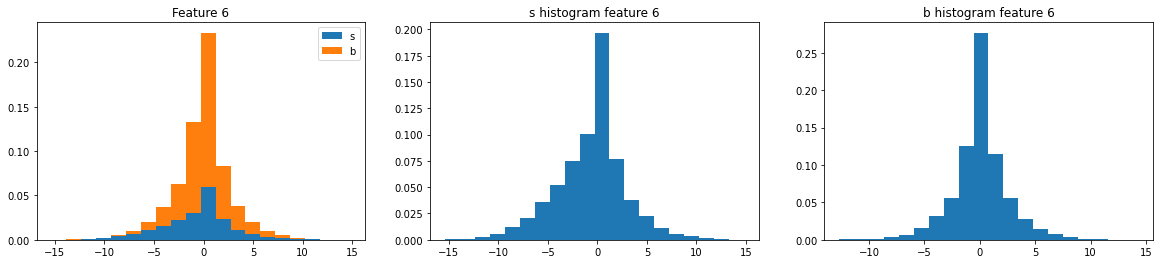

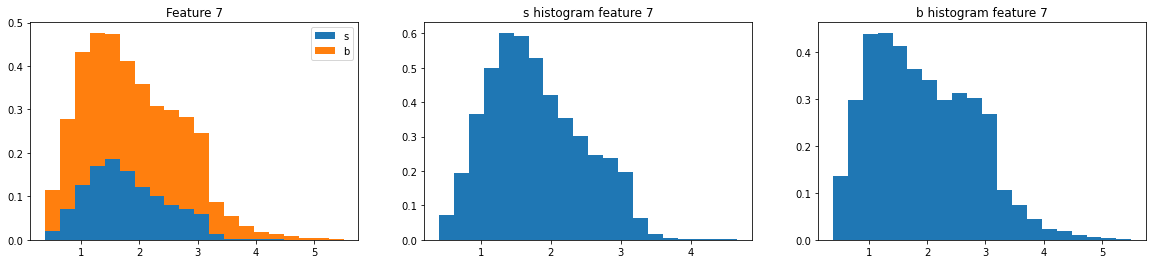

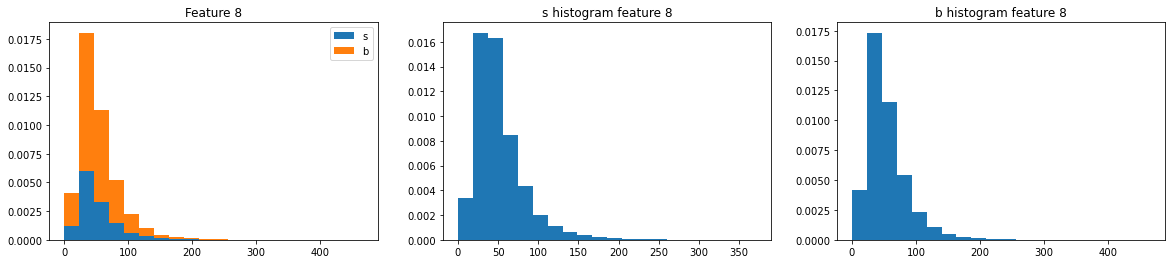

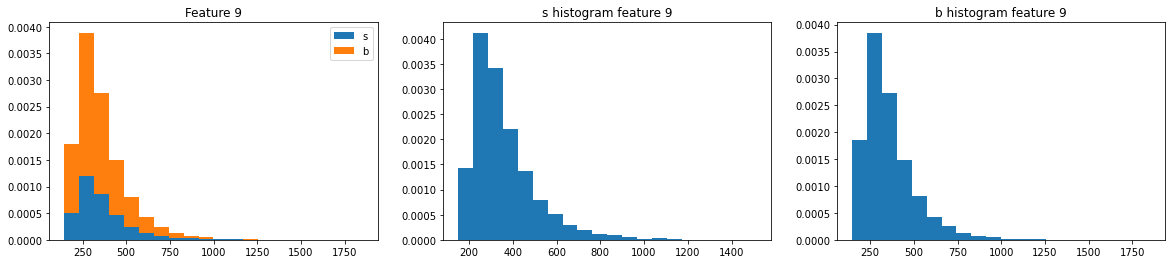

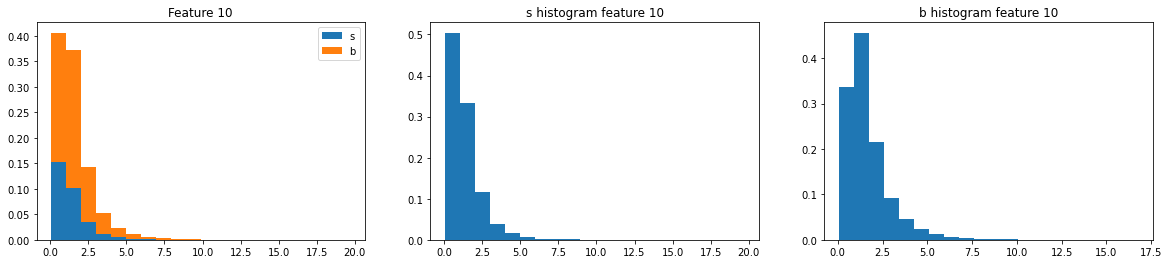

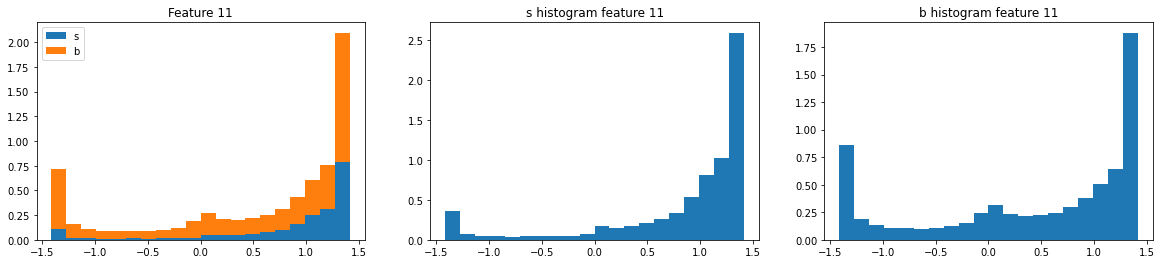

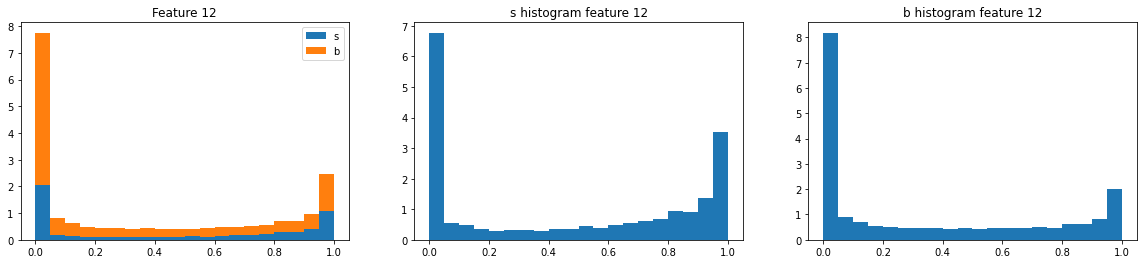

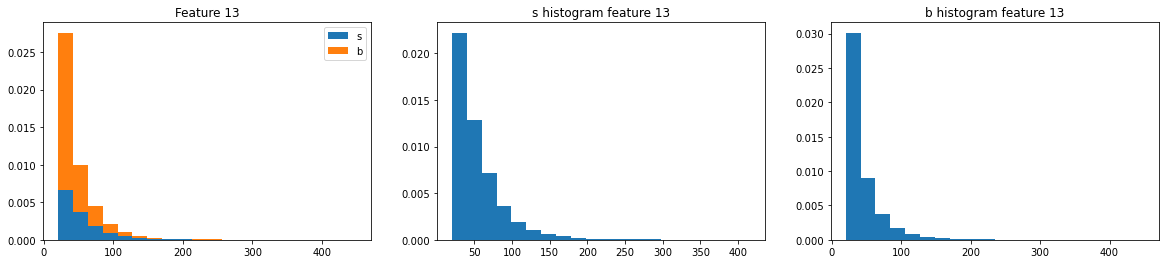

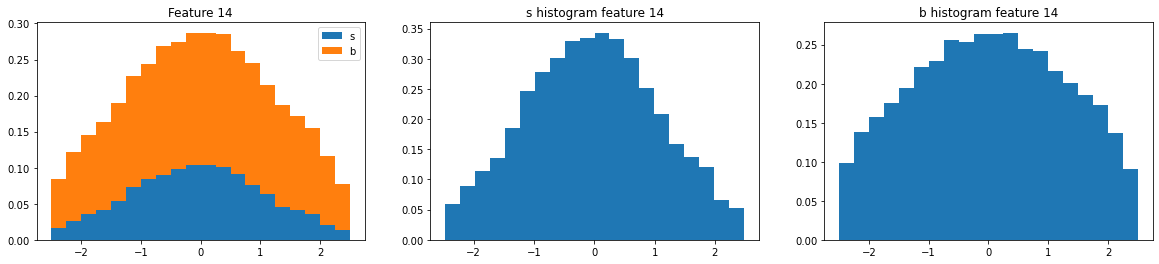

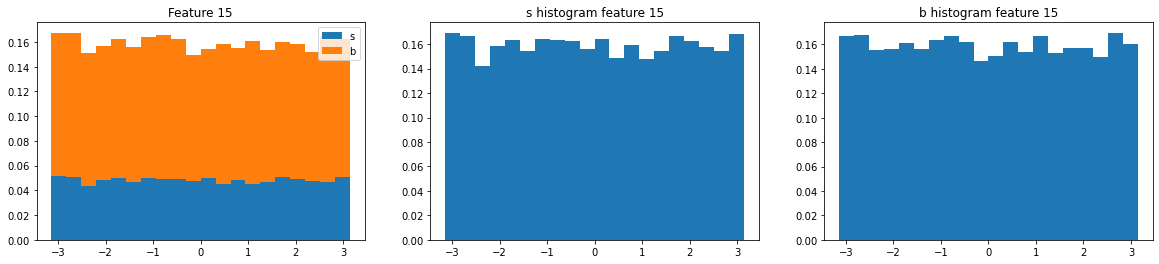

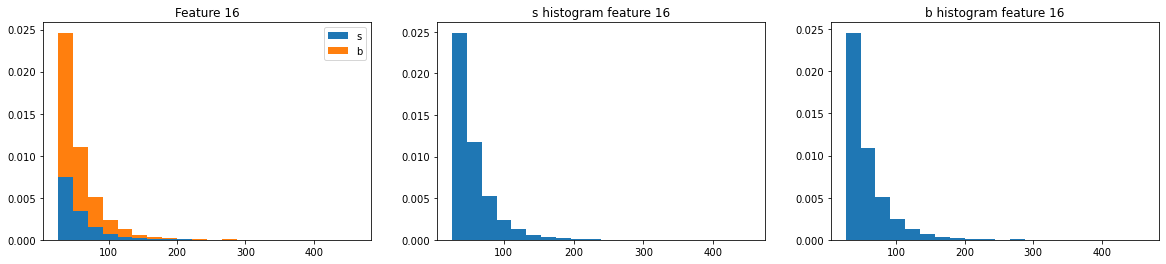

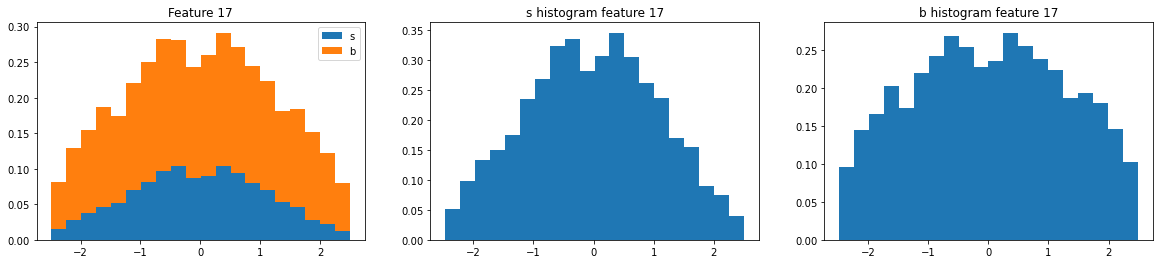

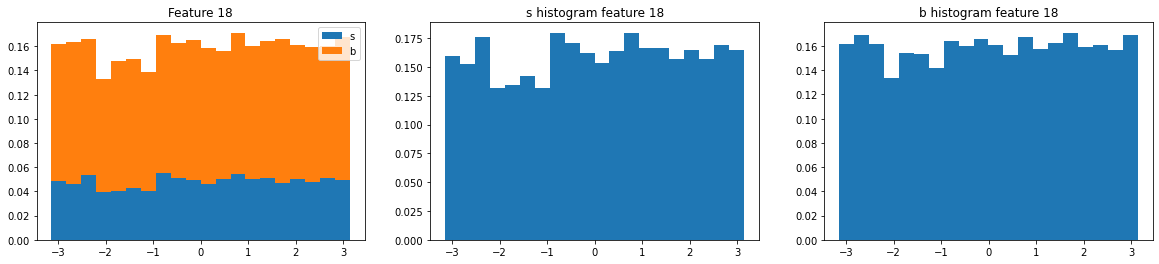

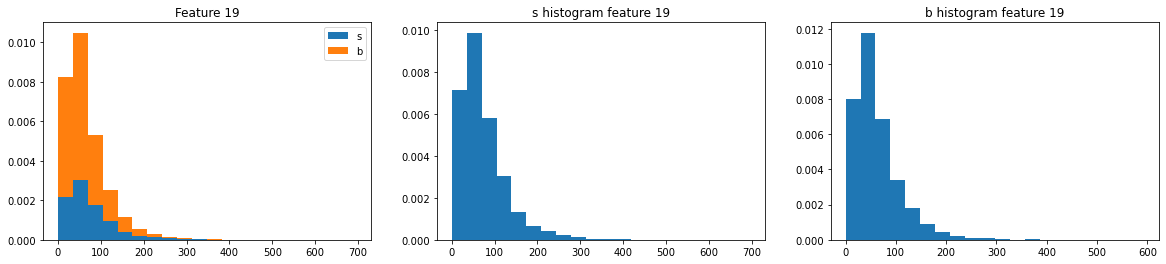

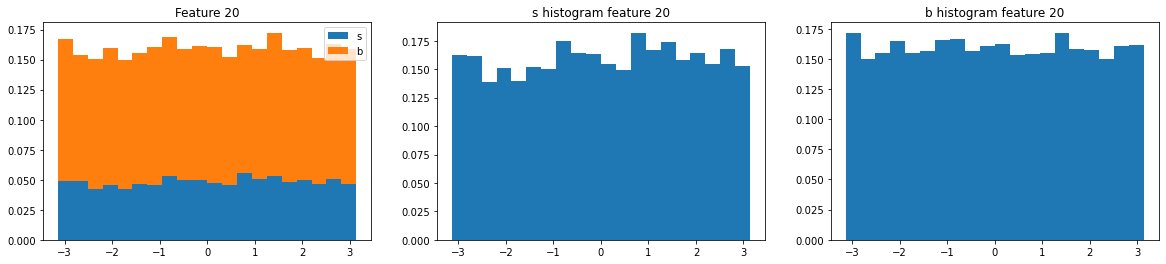

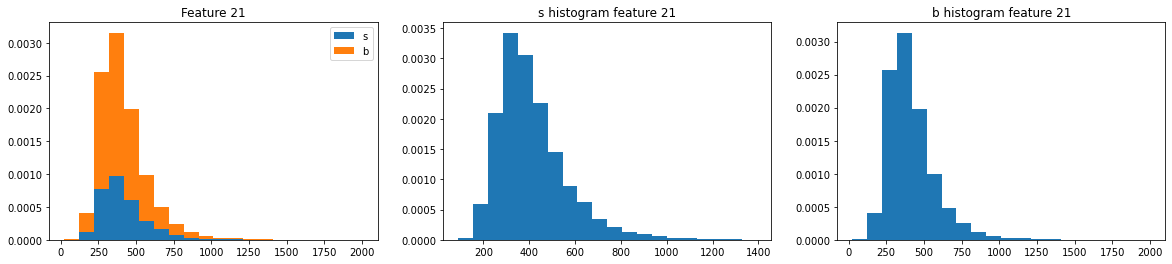

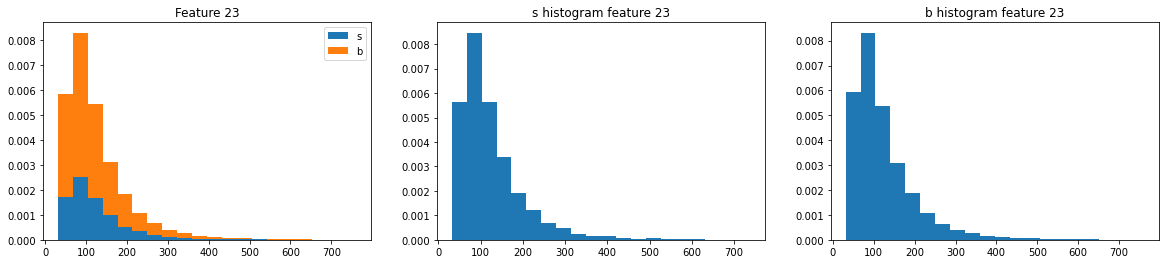

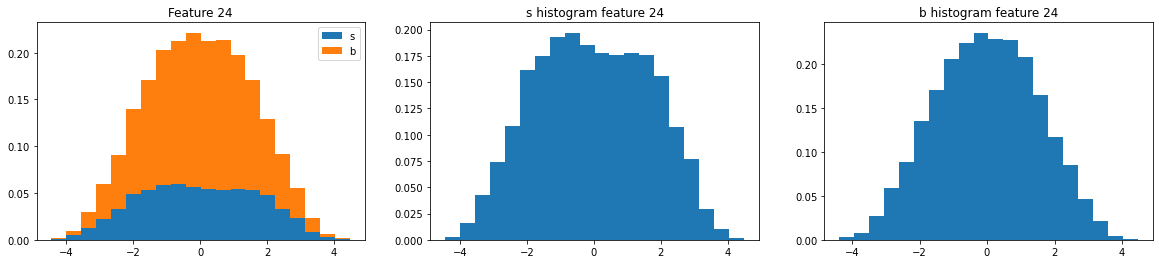

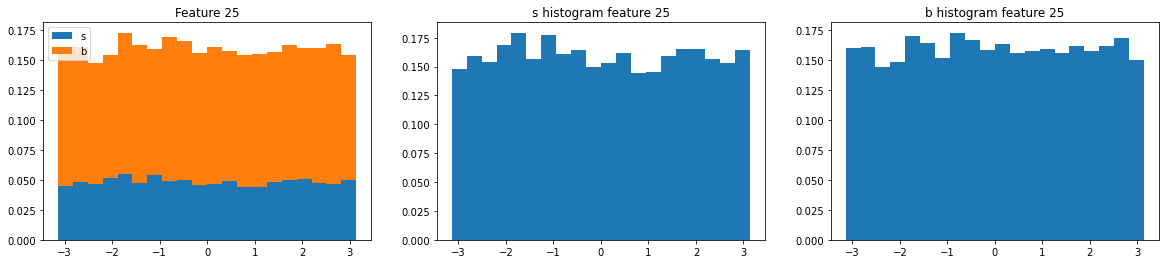

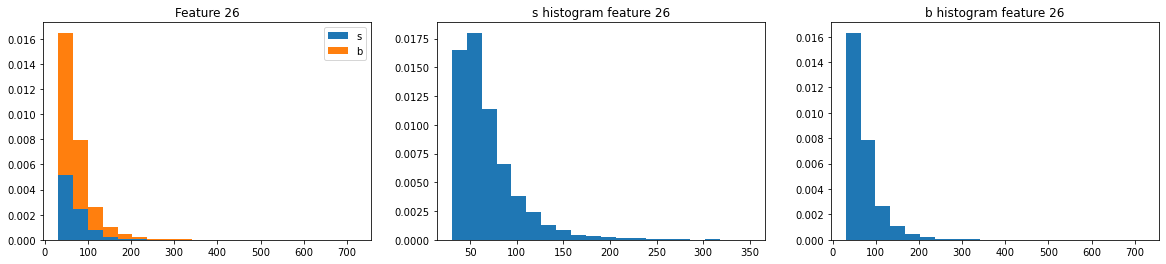

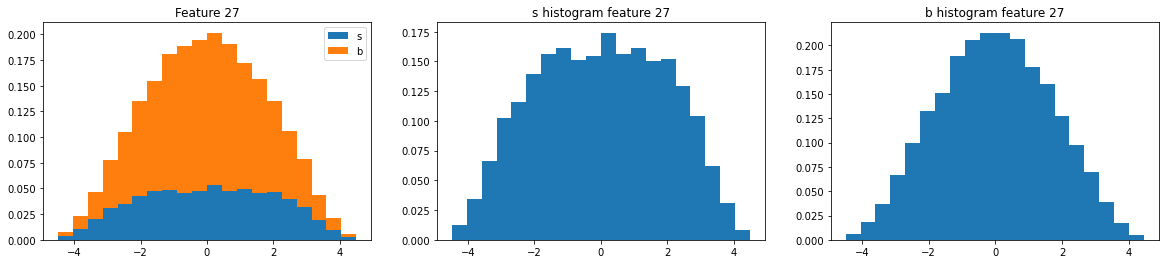

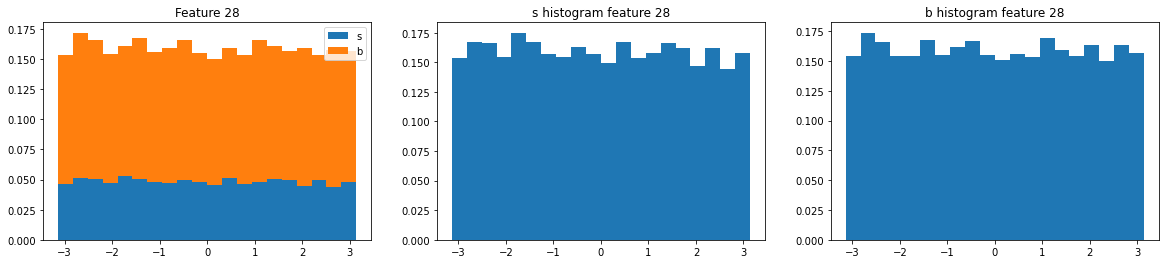

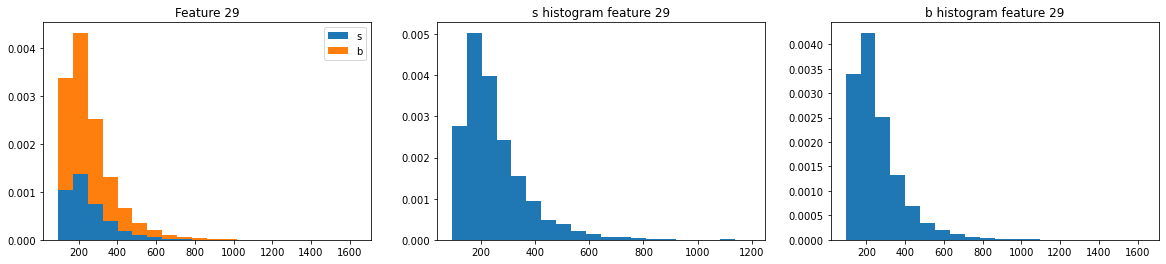

In [11]:
print("Overall: s: ",np.sum(y==1),", b: ",np.sum(y==-1)," ,total:",len(y))
for jet in range(4):
    print('Jet {:}: s: {:}, b: {:} ,total: {:}'.format(jet, np.sum(y_jet_nm[jet]==1),np.sum(y_jet_nm[jet]==-1),len(y_jet_nm[jet])))
    for n,feat in enumerate(idx_jet_undef_nm[jet]):
        plt.figure(figsize=(20,4))
        plt.subplot(131)
        plt.hist([tx_jet_nm[jet][y_jet_nm[jet]==1,n],tx_jet_nm[jet][y_jet_nm[jet]==-1,n]], 20, density=True, histtype='bar', stacked=True)
        plt.legend(['s','b'])
        plt.title('Feature '+str(feat))
        plt.subplot(132)
        plt.title('s histogram feature '+str(feat))
        plt.hist(tx_jet_nm[jet][y_jet_nm[jet]==1,n], 20, density=True, histtype='bar', stacked=True)
        plt.subplot(133)
        plt.title('b histogram feature '+str(feat))
        plt.hist(tx_jet_nm[jet][y_jet_nm[jet]==-1,n], 20, density=True, histtype='bar', stacked=True)    
        plt.show()

# Actual predictions start from here

After having looked at the data we will now do some actual predictions using different models andd parameters.

In [54]:
tx_full = tx_jet+tx_jet_nm
y_full = y_jet+y_jet_nm
for y_i in y_full:
    y_i[y_i==-1] = 0
max_iters = 2500
k_fold = 5

In [ ]:
# Logistic regression
gammas = np.geomspace(0.001,2,15)
loss_tr = np.zeros((8,len(gammas)))
loss_te = np.zeros((8,len(gammas)))
var_tr = np.zeros((8,len(gammas)))
var_te = np.zeros((8,len(gammas)))
for i in range(8):
    tx_i = tx_full[i]
    y_i = y_full[i]
    for g,gamma in enumerate(gammas):
        initial_w = np.zeros(tx_i.shape[1])
        loss_tr[i,g],loss_te[i,g], var_tr[i,g], var_te[i,g], ws = cross_validation_LR(y_i, tx_i, k_fold, initial_w, max_iters, gamma)
        print('set {:} - train_loss: {:}, test_loss: {:}, train_var: {:}, test_var: {:}'.format(i,loss_tr[i,g],loss_te[i,g], var_tr[i,g], var_te[i,g]))
        print(ws)

In [52]:
# Regularized logistic regression
gammas = np.logspace(1e-8,1e-5,8)
lambdas = np.logspace(1e-11,1,12)
loss_tr = np.zeros((8,len(lambdas),len(gammas)))
loss_te = np.zeros((8,len(lambdas),len(gammas)))
var_tr = np.zeros((8,len(lambdas),len(gammas)))
var_te = np.zeros((8,len(lambdas),len(gammas)))
for i in range(8):
    tx_i = tx_full[i]
    y_i = y_full[i]
    for l,lambda_ in enumerate(lambdas):
        for g,gamma in enumerate(gammas):
            initial_w = np.zeros(tx_i.shape[1])
            loss_tr[i,l,g],loss_te[i,l,g], var_tr[i,l,g], var_te[i,l,g], ws = cross_validation_RLR(y_i, tx_i, k_fold, lambda_, initial_w, max_iters, gamma)
            print('set {:} lambda {:} gamma {:} -\n train_loss: {:.6f}, test_loss: {:.6f}, train_var: {:.6f}, test_var: {:.6f}'.format(i,lambda_,gamma,loss_tr[i,l,g],loss_te[i,l,g], var_tr[i,l,g], var_te[i,l,g]))
    #         print(ws)

set 0 lambda 1e-11 gamma 1e-08 -
 train_loss: 48855.503458, test_loss: 12214.198261, train_var: 6226.993376, test_var: 241.522569
set 0 lambda 1e-11 gamma 2.682695795279727e-08 -
 train_loss: 46166.676907, test_loss: 11542.231563, train_var: 3057.532668, test_var: 701.722078
set 0 lambda 1e-11 gamma 7.196856730011513e-08 -
 train_loss: 43651.218795, test_loss: 10913.633979, train_var: 24666.957061, test_var: 2607.717321
set 0 lambda 1e-11 gamma 1.9306977288832497e-07 -
 train_loss: 41891.084583, test_loss: 10473.743145, train_var: 23843.088627, test_var: 1961.716989
set 0 lambda 1e-11 gamma 5.179474679231213e-07 -
 train_loss: 41020.531447, test_loss: 10256.232221, train_var: 37498.122841, test_var: 4419.339215
set 0 lambda 1e-11 gamma 1.389495494373136e-06 -
 train_loss: 40040.448922, test_loss: 10012.410587, train_var: 184313.032511, test_var: 14942.136974
set 0 lambda 1e-11 gamma 3.727593720314938e-06 -
 train_loss: 38842.232194, test_loss: 9721.670997, train_var: 644809.503356, tes

set 0 lambda 0.0001 gamma 2.682695795279727e-08 -
 train_loss: 46166.676914, test_loss: 11542.231565, train_var: 3057.532635, test_var: 701.722071
set 0 lambda 0.0001 gamma 7.196856730011513e-08 -
 train_loss: 43651.218812, test_loss: 10913.633983, train_var: 24666.956908, test_var: 2607.717289
set 0 lambda 0.0001 gamma 1.9306977288832497e-07 -
 train_loss: 41891.084609, test_loss: 10473.743152, train_var: 23843.089943, test_var: 1961.716996
set 0 lambda 0.0001 gamma 5.179474679231213e-07 -
 train_loss: 41020.531495, test_loss: 10256.232233, train_var: 37498.127019, test_var: 4419.339028
set 0 lambda 0.0001 gamma 1.389495494373136e-06 -
 train_loss: 40040.449136, test_loss: 10012.410640, train_var: 184313.056914, test_var: 14942.137466
set 0 lambda 0.0001 gamma 3.727593720314938e-06 -
 train_loss: 38842.232823, test_loss: 9721.671154, train_var: 644809.461625, test_var: 50298.008009
set 0 lambda 0.0001 gamma 1e-05 -
 train_loss: 40096.723591, test_loss: 10049.355780, train_var: 445961.

set 1 lambda 1e-09 gamma 1.9306977288832497e-07 -
 train_loss: 39397.716879, test_loss: 9850.814271, train_var: 27369.816581, test_var: 243.191036
set 1 lambda 1e-09 gamma 5.179474679231213e-07 -
 train_loss: 38555.495351, test_loss: 9639.760978, train_var: 77358.171310, test_var: 1739.558065
set 1 lambda 1e-09 gamma 1.389495494373136e-06 -
 train_loss: 37695.145461, test_loss: 9427.794901, train_var: 301100.370861, test_var: 15332.810315
set 1 lambda 1e-09 gamma 3.727593720314938e-06 -
 train_loss: 38222.256938, test_loss: 9569.588258, train_var: 922027.682378, test_var: 71724.158467
set 1 lambda 1e-09 gamma 1e-05 -
 train_loss: 44694.210203, test_loss: 11211.160060, train_var: 68077720.398811, test_var: 4395507.401111
set 1 lambda 1e-08 gamma 1e-08 -
 train_loss: 41620.621319, test_loss: 10405.419420, train_var: 1150.000026, test_var: 158.185955
set 1 lambda 1e-08 gamma 2.682695795279727e-08 -
 train_loss: 40627.557925, test_loss: 10157.521146, train_var: 2031.565481, test_var: 397.5

set 1 lambda 0.01 gamma 5.179474679231213e-07 -
 train_loss: 38555.500033, test_loss: 9639.762140, train_var: 77358.135303, test_var: 1739.557084
set 1 lambda 0.01 gamma 1.389495494373136e-06 -
 train_loss: 37695.156850, test_loss: 9427.797703, train_var: 301100.549854, test_var: 15332.821902
set 1 lambda 0.01 gamma 3.727593720314938e-06 -
 train_loss: 38222.268737, test_loss: 9569.590913, train_var: 922049.044738, test_var: 71725.620176
set 1 lambda 0.01 gamma 1e-05 -
 train_loss: 44694.075863, test_loss: 11211.125722, train_var: 68076492.028949, test_var: 4395432.062124
set 1 lambda 0.1 gamma 1e-08 -
 train_loss: 41620.622102, test_loss: 10405.419616, train_var: 1149.999758, test_var: 158.185893
set 1 lambda 0.1 gamma 2.682695795279727e-08 -
 train_loss: 40627.560311, test_loss: 10157.521743, train_var: 2031.569098, test_var: 397.539691
set 1 lambda 0.1 gamma 7.196856730011513e-08 -
 train_loss: 39941.451059, test_loss: 9986.586509, train_var: 5259.211547, test_var: 259.618248
set 1 

set 2 lambda 1e-07 gamma 3.727593720314938e-06 -
 train_loss: 25805.286359, test_loss: 6447.530079, train_var: 6673467.348629, test_var: 504502.728769
set 2 lambda 1e-07 gamma 1e-05 -
 train_loss: 34105.565968, test_loss: 8516.499163, train_var: 61328943.512794, test_var: 4513515.393362
set 2 lambda 1e-06 gamma 1e-08 -
 train_loss: 26133.029158, test_loss: 6533.449667, train_var: 1105.255392, test_var: 625.406070
set 2 lambda 1e-06 gamma 2.682695795279727e-08 -
 train_loss: 25214.441714, test_loss: 6305.042622, train_var: 5458.497719, test_var: 799.015888
set 2 lambda 1e-06 gamma 7.196856730011513e-08 -
 train_loss: 24396.532693, test_loss: 6103.000449, train_var: 6947.981362, test_var: 658.742243
set 2 lambda 1e-06 gamma 1.9306977288832497e-07 -
 train_loss: 24024.699620, test_loss: 6012.403423, train_var: 24526.275578, test_var: 2354.675468
set 2 lambda 1e-06 gamma 5.179474679231213e-07 -
 train_loss: 23816.688310, test_loss: 5964.184326, train_var: 119533.324733, test_var: 8661.2589

 train_loss: 34108.084970, test_loss: 8517.935885, train_var: 62380455.616544, test_var: 4583842.063871
set 3 lambda 1e-11 gamma 1e-08 -
 train_loss: 11081.981376, test_loss: 2771.973873, train_var: 1288.487741, test_var: 122.690289
set 3 lambda 1e-11 gamma 2.682695795279727e-08 -
 train_loss: 10874.736733, test_loss: 2721.138364, train_var: 1566.443139, test_var: 482.171639
set 3 lambda 1e-11 gamma 7.196856730011513e-08 -
 train_loss: 10673.107602, test_loss: 2671.078053, train_var: 3999.660556, test_var: 749.774080
set 3 lambda 1e-11 gamma 1.9306977288832497e-07 -
 train_loss: 10502.071391, test_loss: 2628.856726, train_var: 19637.704899, test_var: 1569.406187
set 3 lambda 1e-11 gamma 5.179474679231213e-07 -
 train_loss: 10340.798664, test_loss: 2590.049501, train_var: 113183.437392, test_var: 7440.858881
set 3 lambda 1e-11 gamma 1.389495494373136e-06 -
 train_loss: 10532.398767, test_loss: 2638.464395, train_var: 218243.721633, test_var: 16377.119640
set 3 lambda 1e-11 gamma 3.72759

set 3 lambda 0.0001 gamma 2.682695795279727e-08 -
 train_loss: 10874.736734, test_loss: 2721.138364, train_var: 1566.443130, test_var: 482.171637
set 3 lambda 0.0001 gamma 7.196856730011513e-08 -
 train_loss: 10673.107603, test_loss: 2671.078054, train_var: 3999.660537, test_var: 749.774077
set 3 lambda 0.0001 gamma 1.9306977288832497e-07 -
 train_loss: 10502.071395, test_loss: 2628.856727, train_var: 19637.704884, test_var: 1569.406190
set 3 lambda 0.0001 gamma 5.179474679231213e-07 -
 train_loss: 10340.798679, test_loss: 2590.049505, train_var: 113183.437806, test_var: 7440.858921
set 3 lambda 0.0001 gamma 1.389495494373136e-06 -
 train_loss: 10532.398798, test_loss: 2638.464402, train_var: 218243.732412, test_var: 16377.120388
set 3 lambda 0.0001 gamma 3.727593720314938e-06 -
 train_loss: 12659.982264, test_loss: 3187.124601, train_var: 9610945.477959, test_var: 665244.159524
set 3 lambda 0.0001 gamma 1e-05 -
 train_loss: 19597.599060, test_loss: 4974.719294, train_var: 70706484.946

set 4 lambda 1e-09 gamma 1.9306977288832497e-07 -
 train_loss: 45057.779105, test_loss: 11265.774757, train_var: 17205.290077, test_var: 1449.506519
set 4 lambda 1e-09 gamma 5.179474679231213e-07 -
 train_loss: 43293.285465, test_loss: 10827.515280, train_var: 29908.759633, test_var: 3072.902279
set 4 lambda 1e-09 gamma 1.389495494373136e-06 -
 train_loss: 40682.654632, test_loss: 10180.218059, train_var: 24930.936521, test_var: 3771.564847
set 4 lambda 1e-09 gamma 3.727593720314938e-06 -
 train_loss: 38275.298620, test_loss: 9585.319070, train_var: 71310.469280, test_var: 12545.889875
set 4 lambda 1e-09 gamma 1e-05 -
 train_loss: 37742.766955, test_loss: 9460.273611, train_var: 429586.499033, test_var: 48073.719790
set 4 lambda 1e-08 gamma 1e-08 -
 train_loss: 53430.916444, test_loss: 13357.749420, train_var: 3733.659065, test_var: 263.053430
set 4 lambda 1e-08 gamma 2.682695795279727e-08 -
 train_loss: 50990.067879, test_loss: 12747.602902, train_var: 15844.136491, test_var: 1102.294

set 4 lambda 0.01 gamma 5.179474679231213e-07 -
 train_loss: 43293.295239, test_loss: 10827.517724, train_var: 29908.492005, test_var: 3072.836710
set 4 lambda 0.01 gamma 1.389495494373136e-06 -
 train_loss: 40682.695459, test_loss: 10180.228247, train_var: 24930.860349, test_var: 3771.476868
set 4 lambda 0.01 gamma 3.727593720314938e-06 -
 train_loss: 38275.391302, test_loss: 9585.342145, train_var: 71308.044105, test_var: 12545.388007
set 4 lambda 0.01 gamma 1e-05 -
 train_loss: 37742.857606, test_loss: 9460.295746, train_var: 429576.323012, test_var: 48070.565076
set 4 lambda 0.1 gamma 1e-08 -
 train_loss: 53430.917791, test_loss: 13357.749757, train_var: 3733.654918, test_var: 263.053061
set 4 lambda 0.1 gamma 2.682695795279727e-08 -
 train_loss: 50990.074922, test_loss: 12747.604664, train_var: 15844.108880, test_var: 1102.291195
set 4 lambda 0.1 gamma 7.196856730011513e-08 -
 train_loss: 47548.202302, test_loss: 11887.409883, train_var: 32023.323602, test_var: 2166.648999
set 4 l

set 5 lambda 1e-07 gamma 3.727593720314938e-06 -
 train_loss: 37686.944463, test_loss: 9422.007861, train_var: 1024712.690472, test_var: 73545.259557
set 5 lambda 1e-07 gamma 1e-05 -
 train_loss: 41722.404610, test_loss: 10448.748628, train_var: 77155275.763844, test_var: 5038470.156837
set 5 lambda 1e-06 gamma 1e-08 -
 train_loss: 42105.066675, test_loss: 10526.396142, train_var: 2877.759076, test_var: 148.228390
set 5 lambda 1e-06 gamma 2.682695795279727e-08 -
 train_loss: 41476.434982, test_loss: 10369.298170, train_var: 3780.084200, test_var: 184.468726
set 5 lambda 1e-06 gamma 7.196856730011513e-08 -
 train_loss: 41009.723828, test_loss: 10252.497276, train_var: 2605.394964, test_var: 106.492219
set 5 lambda 1e-06 gamma 1.9306977288832497e-07 -
 train_loss: 40383.735299, test_loss: 10095.513038, train_var: 28251.126068, test_var: 1503.572114
set 5 lambda 1e-06 gamma 5.179474679231213e-07 -
 train_loss: 39263.596206, test_loss: 9813.816869, train_var: 78820.190779, test_var: 3750.6

set 5 lambda 1.0 gamma 1e-05 -
 train_loss: 41716.514612, test_loss: 10447.217223, train_var: 76972512.890714, test_var: 5026486.697132
set 6 lambda 1e-11 gamma 1e-08 -
 train_loss: 26306.874767, test_loss: 6576.729525, train_var: 906.788463, test_var: 570.588345
set 6 lambda 1e-11 gamma 2.682695795279727e-08 -
 train_loss: 25528.447448, test_loss: 6383.181845, train_var: 3695.181942, test_var: 826.511143
set 6 lambda 1e-11 gamma 7.196856730011513e-08 -
 train_loss: 24852.316986, test_loss: 6216.575160, train_var: 6030.864451, test_var: 1045.288949
set 6 lambda 1e-11 gamma 1.9306977288832497e-07 -
 train_loss: 24528.382030, test_loss: 6138.431009, train_var: 34301.551873, test_var: 4239.756003
set 6 lambda 1e-11 gamma 5.179474679231213e-07 -
 train_loss: 24297.387875, test_loss: 6086.187360, train_var: 212716.237591, test_var: 17378.145879
set 6 lambda 1e-11 gamma 1.389495494373136e-06 -
 train_loss: 23988.520515, test_loss: 6012.144144, train_var: 501001.438516, test_var: 39666.692964

 train_loss: 30340.861273, test_loss: 7599.767216, train_var: 39897818.381303, test_var: 2784300.341297
set 6 lambda 0.0001 gamma 1e-08 -
 train_loss: 26306.874767, test_loss: 6576.729525, train_var: 906.788463, test_var: 570.588345
set 6 lambda 0.0001 gamma 2.682695795279727e-08 -
 train_loss: 25528.447450, test_loss: 6383.181845, train_var: 3695.181946, test_var: 826.511141
set 6 lambda 0.0001 gamma 7.196856730011513e-08 -
 train_loss: 24852.316991, test_loss: 6216.575161, train_var: 6030.864533, test_var: 1045.288949
set 6 lambda 0.0001 gamma 1.9306977288832497e-07 -
 train_loss: 24528.382038, test_loss: 6138.431010, train_var: 34301.552826, test_var: 4239.756055
set 6 lambda 0.0001 gamma 5.179474679231213e-07 -
 train_loss: 24297.387902, test_loss: 6086.187367, train_var: 212716.238093, test_var: 17378.145904
set 6 lambda 0.0001 gamma 1.389495494373136e-06 -
 train_loss: 23988.520598, test_loss: 6012.144165, train_var: 501001.449968, test_var: 39666.693215
set 6 lambda 0.0001 gamma

set 7 lambda 1e-09 gamma 2.682695795279727e-08 -
 train_loss: 10974.161366, test_loss: 2745.985280, train_var: 1012.004469, test_var: 572.108563
set 7 lambda 1e-09 gamma 7.196856730011513e-08 -
 train_loss: 10816.774390, test_loss: 2706.760121, train_var: 2748.206026, test_var: 694.929898
set 7 lambda 1e-09 gamma 1.9306977288832497e-07 -
 train_loss: 10645.736064, test_loss: 2664.332937, train_var: 17151.649014, test_var: 1252.305306
set 7 lambda 1e-09 gamma 5.179474679231213e-07 -
 train_loss: 10458.086861, test_loss: 2619.194277, train_var: 95842.315367, test_var: 6360.632152
set 7 lambda 1e-09 gamma 1.389495494373136e-06 -
 train_loss: 10656.967402, test_loss: 2669.790338, train_var: 160459.859292, test_var: 14266.390084
set 7 lambda 1e-09 gamma 3.727593720314938e-06 -
 train_loss: 12629.399013, test_loss: 3176.365028, train_var: 4937302.319189, test_var: 353728.374078
set 7 lambda 1e-09 gamma 1e-05 -
 train_loss: 20311.797216, test_loss: 5126.332559, train_var: 98099020.550979, tes

set 7 lambda 0.01 gamma 7.196856730011513e-08 -
 train_loss: 10816.774495, test_loss: 2706.760147, train_var: 2748.204189, test_var: 694.929692
set 7 lambda 0.01 gamma 1.9306977288832497e-07 -
 train_loss: 10645.736495, test_loss: 2664.333046, train_var: 17151.638928, test_var: 1252.305543
set 7 lambda 0.01 gamma 5.179474679231213e-07 -
 train_loss: 10458.088509, test_loss: 2619.194692, train_var: 95842.319995, test_var: 6360.634065
set 7 lambda 0.01 gamma 1.389495494373136e-06 -
 train_loss: 10656.971494, test_loss: 2669.791358, train_var: 160460.733389, test_var: 14266.457666
set 7 lambda 0.01 gamma 3.727593720314938e-06 -
 train_loss: 12629.416704, test_loss: 3176.369257, train_var: 4937453.250861, test_var: 353737.849761
set 7 lambda 0.01 gamma 1e-05 -
 train_loss: 20311.742411, test_loss: 5126.317775, train_var: 98100381.384195, test_var: 6551647.164458
set 7 lambda 0.1 gamma 1e-08 -
 train_loss: 11125.631002, test_loss: 2782.954463, train_var: 841.387163, test_var: 160.393983
set

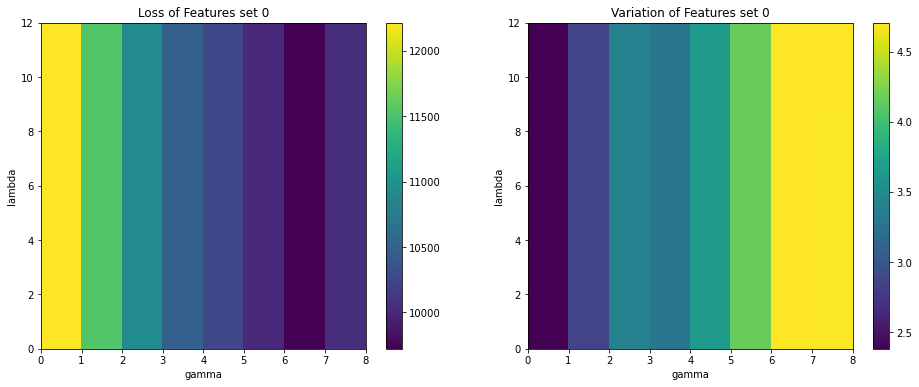

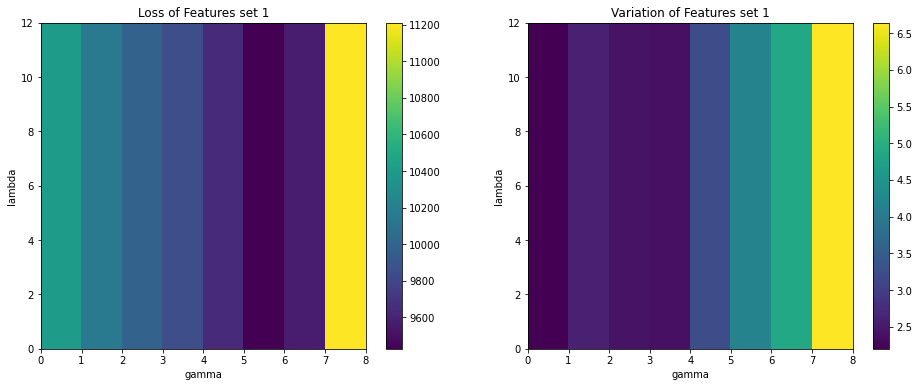

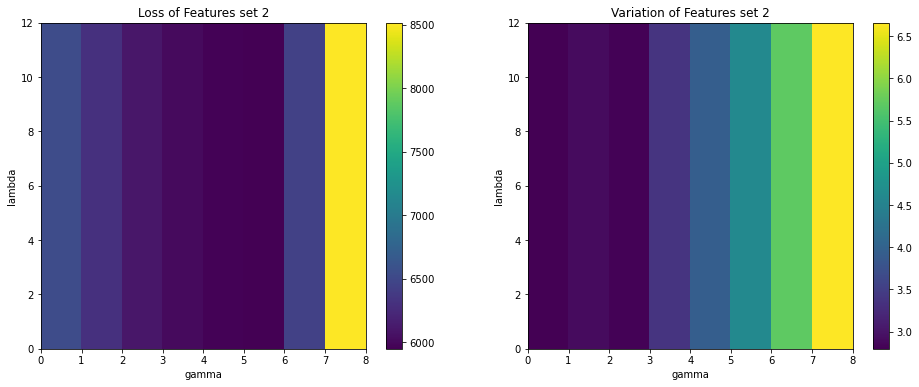

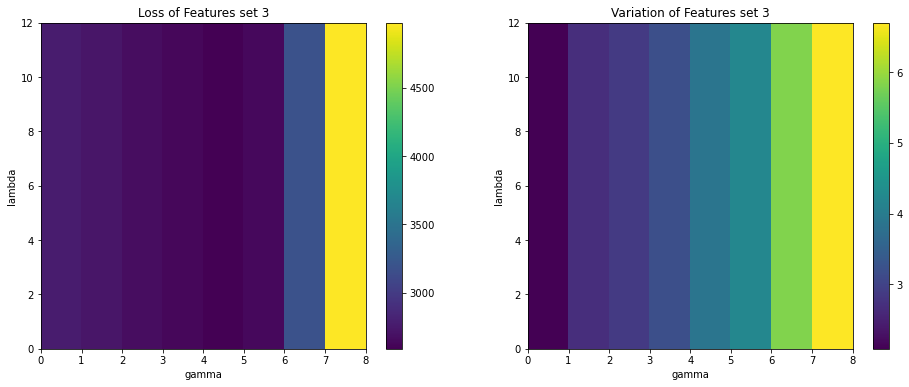

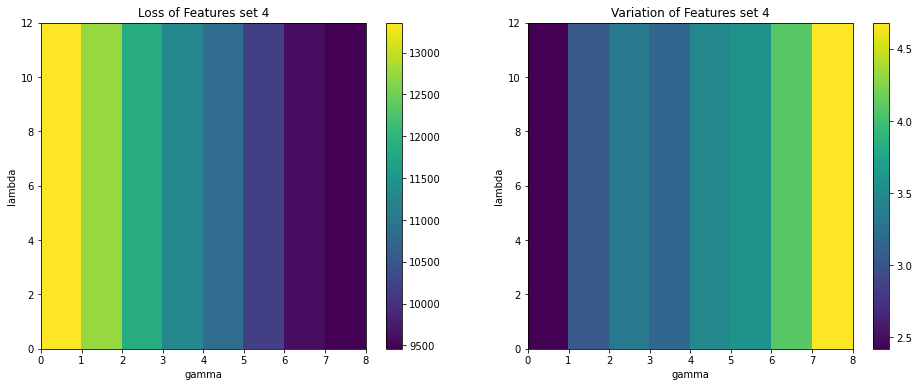

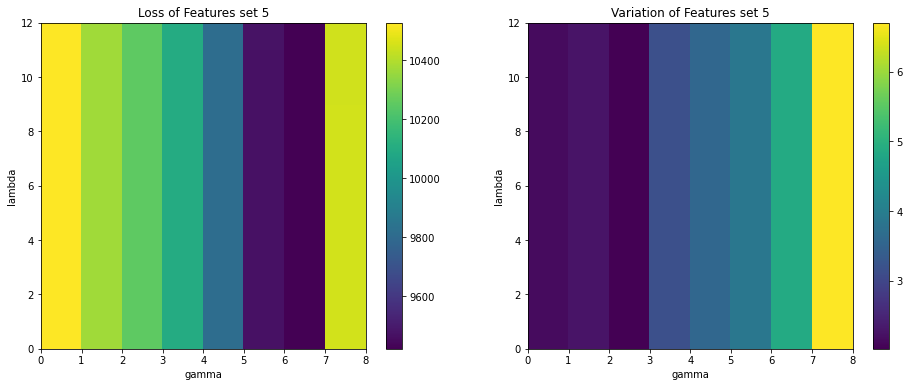

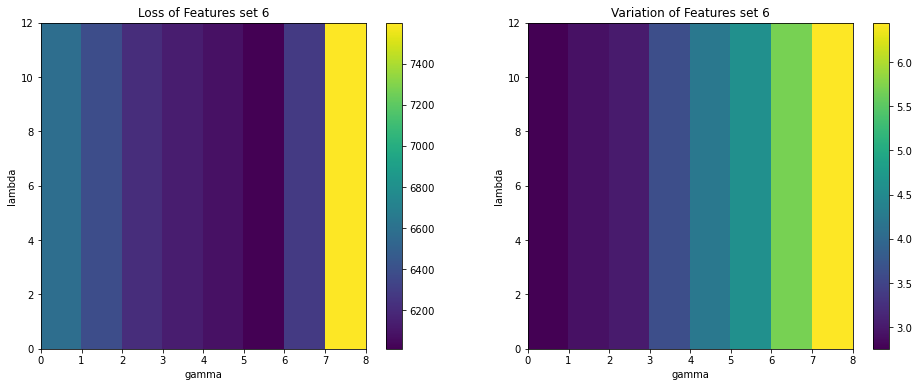

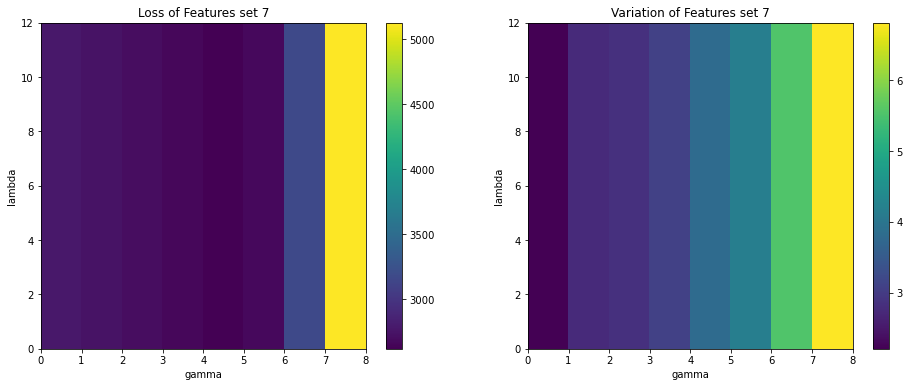

In [53]:
for i,var in enumerate(var_te):
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.pcolor(loss_te[i])
    plt.colorbar()
    plt.title('Loss of Features set '+str(i))
    plt.xlabel('gamma')
    plt.ylabel('lambda')
    plt.subplot(122)
    plt.pcolor(np.log10(var))
    plt.colorbar()
    plt.title('Variation of Features set '+str(i))
    plt.xlabel('gamma')
    plt.ylabel('lambda')
    plt.show()

## Load the test data

In [ ]:
from proj1_helpers import *
DATA_TEST_PATH = '../data/test.csv.zip' 
# test_y, test_X, ids = load_csv_data(DATA_TRAIN_PATH)

## Generate predictions using only features with no errrors throughought

This enables us to use some of the methods from the course directly, without having to adjust some of the functionnality to account for the fact that a lot of errors are in the dataset. First let us see which features from the test dataset are error free.

In [ ]:
# Import test data

import pandas as pd

test_x_df = pd.read_csv(DATA_TEST_PATH, index_col='Id').drop('Prediction', axis='columns')
test_x_df

train_x_df = pd.read_csv(DATA_TRAIN_PATH, index_col='Id').drop('Prediction', axis='columns')
train_y_df = pd.read_csv(DATA_TRAIN_PATH, index_col='Id', usecols=['Id', 'Prediction'])

In [ ]:
# Remove columns with -999 errors
error_cols_te = np.full(test_x_df.shape[1], False)
for i in range(test_x_df.shape[1]):
#     print(test_x_df.iloc[:,i].values)
#     print(-999.0 in test_x_df.iloc[:,i].values)
    if -999.0 in test_x_df.iloc[:,i].values:
        error_cols_te[i] = True
print(f"There are {error_cols_te.tolist().count(True)} test error columns are which are : \n{error_cols_te}\n")

error_cols_tr = np.full(train_x_df.shape[1], False)
for i in range(train_x_df.shape[1]):
    if -999.0 in train_x_df.iloc[:,i].values:
        error_cols_tr[i] = True
print(f"There are {error_cols_tr.tolist().count(True)} train error columns are which are : \n{error_cols_tr}")

no_error_cols_tr_te = (~(error_cols_tr | error_cols_te)).tolist()
print(f"They have {no_error_cols_tr_te.count(True)} following shared non error columns :\n{no_error_cols_tr_te}")

With this figured out we can now extract the valid columns from test and train data, do some training and testing on data, then generate answers for the test data and submit to aicrowd !

# Save prediction ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)